# Deep cortical reinforcement learning: Policy gradients + Q-learning + GAN


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [137]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [138]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [139]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [140]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [141]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 3.211562375932665 -3.078485968314027
actions: 1 0
rewards: 1.0 1.0


In [142]:
actions[:10]

array([0, 1, 1, 0, 1, 0, 0, 0, 1, 1])

In [143]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [144]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [145]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [146]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [171]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    reward = tf.placeholder(tf.float32, [], name='reward')
    return states, actions, targetQs, reward

In [172]:
# How to use batch-norm
#   x_norm = tf.layers.batch_normalization(x, training=training)

#   # ...

#   update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
#   with tf.control_dependencies(update_ops):
#     train_op = optimizer.minimize(loss)

In [173]:
# training: Either a Python boolean, or a TensorFlow boolean scalar tensor (e.g. a placeholder). 
# Whether to return the output in: 
# training mode (normalized with statistics of the current batch) or 
# inference mode (normalized with moving statistics). 
# NOTE: make sure to set this parameter correctly, or else your training/inference will not work properly.

In [174]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [175]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [193]:
def model_loss(action_size, hidden_size, states, actions, targetQs, reward):
    # G
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    rewards = reward * tf.ones_like(targetQs) # GAN using success rate
    Qs_labels = rewards[:-1] + (0.99*targetQs[1:]) # Q-learning using max future rewards
    g_loss = tf.reduce_mean(neg_log_prob_actions[:-1] * Qs_labels)# Policy gradient for state and action mapping
    
    # D
    Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    d_lossR = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits, [-1]),
                                                                     labels=rewards))
    d_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits[:-1], [-1]),
                                                                     labels=tf.nn.sigmoid(Qs_labels)))
    d_loss = d_lossR #+ d_lossQ

    return actions_logits, Qs_logits, g_loss, d_loss, d_lossR, d_lossQ

In [194]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [195]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.reward = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.d_lossR, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, # model input
            targetQs=self.targetQs, reward=self.reward) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [196]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(500, 4) actions:(500,)
action size:2


In [197]:
# Training parameters
# Network parameters
state_size = 4               # number of units for the input state/observation -- simulation
action_size = 2              # number of units for the output actions -- simulation
hidden_size = 64             # number of units in each Q-network hidden layer -- simulation
learning_rate = 0.001          # learning rate for adam

In [198]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [199]:
# import gym

# ## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# # env = gym.make('MountainCar-v0')
# # env = gym.make('Pendulum-v0')
# # env = gym.make('Blackjack-v0')
# # env = gym.make('FrozenLake-v0')
# # env = gym.make('AirRaid-ram-v0')
# # env = gym.make('AirRaid-v0')
# # env = gym.make('BipedalWalker-v2')
# # env = gym.make('Copy-v0')
# # env = gym.make('CarRacing-v0')
# # env = gym.make('Ant-v2') #mujoco
# # env = gym.make('FetchPickAndPlace-v1') # mujoco required!

In [200]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []
rates_list, d_lossR_list, d_lossQ_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(111111):
        batch = [] # every data batch
        total_reward = 0
        state = env.reset() # env first state

        # Training steps/batches
        while True:
            action_logits, Q_logits = sess.run(fetches=[model.actions_logits, model.Qs_logits], 
                                               feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            batch.append([state, action, Q_logits])
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done is True: # episode ended success/failure
                episodes_total_reward.append(total_reward) # stopping criteria
                rate = total_reward/ 500 # success is 500 points: 0-1
                break

        # Training using batches
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        targetQs = np.array([each[2] for each in batch])
        g_loss, d_loss, d_lossR, d_lossQ, _, _ = sess.run([model.g_loss, model.d_loss, 
                                                           model.d_lossR, model.d_lossQ, 
                                                           model.g_opt, model.d_opt],
                                                          feed_dict = {model.states: states, 
                                                                       model.actions: actions,
                                                                       model.reward: rate,
                                                                       model.targetQs: targetQs.reshape([-1])})
        # Average 100 episode total reward
        # Print out
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episodes_total_reward)),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(g_loss),
              'dloss:{:.4f}'.format(d_loss),
              'dlossR:{:.4f}'.format(d_lossR),
              'dlossQ:{:.4f}'.format(d_lossQ))
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        rates_list.append([ep, rate])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        d_lossR_list.append([ep, d_lossR])
        d_lossQ_list.append([ep, d_lossQ])
        # Break episode/epoch loop
        if np.mean(episodes_total_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/modelR2.ckpt')

Episode:0 meanR:9.0000 rate:0.0180 gloss:-0.0569 dloss:0.6438 dlossR:0.6438 dlossQ:0.6915
Episode:1 meanR:48.0000 rate:0.1740 gloss:0.0666 dloss:0.6697 dlossR:0.6697 dlossQ:0.6945
Episode:2 meanR:66.3333 rate:0.2060 gloss:0.0239 dloss:0.6489 dlossR:0.6489 dlossQ:0.6960
Episode:3 meanR:70.0000 rate:0.1620 gloss:0.0497 dloss:0.6648 dlossR:0.6648 dlossQ:0.6958
Episode:4 meanR:73.0000 rate:0.1700 gloss:0.0433 dloss:0.6601 dlossR:0.6601 dlossQ:0.6962
Episode:5 meanR:66.6667 rate:0.0700 gloss:-0.0466 dloss:0.6349 dlossR:0.6349 dlossQ:0.6932
Episode:6 meanR:67.1429 rate:0.1400 gloss:-0.0072 dloss:0.6416 dlossR:0.6416 dlossQ:0.6957
Episode:7 meanR:63.6250 rate:0.0780 gloss:-0.0748 dloss:0.6163 dlossR:0.6163 dlossQ:0.6923
Episode:8 meanR:64.3333 rate:0.1400 gloss:-0.0112 dloss:0.6395 dlossR:0.6395 dlossQ:0.6958
Episode:9 meanR:66.8000 rate:0.1780 gloss:-0.0254 dloss:0.6290 dlossR:0.6290 dlossQ:0.6970
Episode:10 meanR:64.8182 rate:0.0900 gloss:-0.1133 dloss:0.5932 dlossR:0.5932 dlossQ:0.6904
Epi

Episode:95 meanR:45.7812 rate:0.1040 gloss:-1.5999 dloss:0.3413 dlossR:0.3413 dlossQ:0.3086
Episode:96 meanR:46.0000 rate:0.1340 gloss:-1.5466 dloss:0.4114 dlossR:0.4114 dlossQ:0.3227
Episode:97 meanR:47.7449 rate:0.4340 gloss:-1.2182 dloss:1.0724 dlossR:1.0724 dlossQ:0.4341
Episode:98 meanR:50.0505 rate:0.5520 gloss:-1.1211 dloss:1.3200 dlossR:1.3200 dlossQ:0.4683
Episode:99 meanR:51.1600 rate:0.3220 gloss:-1.2518 dloss:0.8107 dlossR:0.8107 dlossQ:0.4191
Episode:100 meanR:52.1700 rate:0.2200 gloss:-1.3249 dloss:0.5932 dlossR:0.5932 dlossQ:0.3945
Episode:101 meanR:53.3700 rate:0.4140 gloss:-1.0931 dloss:0.9655 dlossR:0.9655 dlossQ:0.4737
Episode:102 meanR:55.9900 rate:0.7300 gloss:-0.8372 dloss:1.5692 dlossR:1.5692 dlossQ:0.5845
Episode:103 meanR:56.9300 rate:0.3500 gloss:-1.0596 dloss:0.8137 dlossR:0.8137 dlossQ:0.4826
Episode:104 meanR:57.8400 rate:0.3520 gloss:-1.0696 dloss:0.8257 dlossR:0.8257 dlossQ:0.4844
Episode:105 meanR:58.0200 rate:0.1060 gloss:-1.2813 dloss:0.3607 dlossR:0.3

Episode:185 meanR:66.8200 rate:0.2480 gloss:-1.1719 dloss:0.6198 dlossR:0.6198 dlossQ:0.4363
Episode:186 meanR:70.6200 rate:0.8740 gloss:-0.7754 dloss:1.8898 dlossR:1.8898 dlossQ:0.6211
Episode:187 meanR:72.2800 rate:0.4560 gloss:-0.9649 dloss:0.9979 dlossR:0.9979 dlossQ:0.5152
Episode:188 meanR:73.8100 rate:0.4040 gloss:-1.0414 dloss:0.9168 dlossR:0.9168 dlossQ:0.4865
Episode:189 meanR:76.4100 rate:0.5500 gloss:-0.8610 dloss:1.1500 dlossR:1.1500 dlossQ:0.5571
Episode:190 meanR:76.9900 rate:0.1420 gloss:-1.0139 dloss:0.4112 dlossR:0.4112 dlossQ:0.4856
Episode:191 meanR:78.9000 rate:0.4020 gloss:-0.8023 dloss:0.8231 dlossR:0.8231 dlossQ:0.5657
Episode:192 meanR:80.8500 rate:0.4960 gloss:-0.7350 dloss:0.9701 dlossR:0.9701 dlossQ:0.5934
Episode:193 meanR:82.3000 rate:0.3800 gloss:-0.7715 dloss:0.7744 dlossR:0.7744 dlossQ:0.5734
Episode:194 meanR:83.3400 rate:0.3020 gloss:-0.7420 dloss:0.6438 dlossR:0.6438 dlossQ:0.5790
Episode:195 meanR:83.9400 rate:0.2240 gloss:-0.7471 dloss:0.5338 dloss

Episode:276 meanR:75.8600 rate:0.0420 gloss:-1.0397 dloss:0.2602 dlossR:0.2602 dlossQ:0.4794
Episode:277 meanR:75.7500 rate:0.0440 gloss:-1.0981 dloss:0.2538 dlossR:0.2538 dlossQ:0.4611
Episode:278 meanR:75.5400 rate:0.0280 gloss:-1.2768 dloss:0.2014 dlossR:0.2014 dlossQ:0.4028
Episode:279 meanR:75.3300 rate:0.0360 gloss:-1.3244 dloss:0.2089 dlossR:0.2089 dlossQ:0.3888
Episode:280 meanR:75.0500 rate:0.0260 gloss:-1.3852 dloss:0.1856 dlossR:0.1856 dlossQ:0.3712
Episode:281 meanR:74.6000 rate:0.0220 gloss:-1.5683 dloss:0.1626 dlossR:0.1626 dlossQ:0.3191
Episode:282 meanR:74.2800 rate:0.0220 gloss:-1.6700 dloss:0.1547 dlossR:0.1547 dlossQ:0.2934
Episode:283 meanR:72.8800 rate:0.0200 gloss:-1.8936 dloss:0.1417 dlossR:0.1417 dlossQ:0.2457
Episode:284 meanR:70.4900 rate:0.0200 gloss:-1.9319 dloss:0.1402 dlossR:0.1402 dlossQ:0.2395
Episode:285 meanR:69.5700 rate:0.0640 gloss:-1.2293 dloss:0.2750 dlossR:0.2750 dlossQ:0.4228
Episode:286 meanR:65.6600 rate:0.0920 gloss:-1.0458 dloss:0.3377 dloss

Episode:367 meanR:39.7200 rate:0.0640 gloss:-1.5199 dloss:0.2467 dlossR:0.2467 dlossQ:0.3317
Episode:368 meanR:38.9500 rate:0.1060 gloss:-1.4275 dloss:0.3399 dlossR:0.3399 dlossQ:0.3561
Episode:369 meanR:38.0000 rate:0.0700 gloss:-1.4605 dloss:0.2604 dlossR:0.2604 dlossQ:0.3464
Episode:370 meanR:37.6900 rate:0.0420 gloss:-1.6033 dloss:0.1911 dlossR:0.1911 dlossQ:0.3101
Episode:371 meanR:36.9700 rate:0.0260 gloss:-2.2677 dloss:0.1306 dlossR:0.1306 dlossQ:0.1694
Episode:372 meanR:36.6900 rate:0.0260 gloss:-2.3330 dloss:0.1314 dlossR:0.1314 dlossQ:0.1614
Episode:373 meanR:36.6700 rate:0.0780 gloss:-1.4636 dloss:0.2776 dlossR:0.2776 dlossQ:0.3461
Episode:374 meanR:37.0800 rate:0.1220 gloss:-1.5398 dloss:0.3958 dlossR:0.3958 dlossQ:0.3471
Episode:375 meanR:38.4200 rate:0.3200 gloss:-1.2638 dloss:0.8117 dlossR:0.8117 dlossQ:0.4223
Episode:376 meanR:39.2000 rate:0.1980 gloss:-1.3956 dloss:0.5468 dlossR:0.5468 dlossQ:0.3698
Episode:377 meanR:39.5600 rate:0.1160 gloss:-1.5094 dloss:0.3684 dloss

Episode:461 meanR:69.2200 rate:0.1060 gloss:-1.0905 dloss:0.3517 dlossR:0.3517 dlossQ:0.4635
Episode:462 meanR:69.2600 rate:0.0500 gloss:-1.4128 dloss:0.2304 dlossR:0.2304 dlossQ:0.3750
Episode:463 meanR:69.2000 rate:0.0480 gloss:-1.3578 dloss:0.2314 dlossR:0.2314 dlossQ:0.3902
Episode:464 meanR:68.7400 rate:0.0440 gloss:-1.5175 dloss:0.2097 dlossR:0.2097 dlossQ:0.3450
Episode:465 meanR:68.6800 rate:0.2140 gloss:-1.0728 dloss:0.5504 dlossR:0.5504 dlossQ:0.4786
Episode:466 meanR:67.9400 rate:0.0920 gloss:-1.2829 dloss:0.3206 dlossR:0.3206 dlossQ:0.4058
Episode:467 meanR:67.9400 rate:0.0640 gloss:-1.2331 dloss:0.2784 dlossR:0.2784 dlossQ:0.4232
Episode:468 meanR:67.5100 rate:0.0200 gloss:-2.8694 dloss:0.1417 dlossR:0.1417 dlossQ:0.1498
Episode:469 meanR:67.2800 rate:0.0240 gloss:-1.2785 dloss:0.1951 dlossR:0.1951 dlossQ:0.4009
Episode:470 meanR:67.1700 rate:0.0200 gloss:-1.2680 dloss:0.1915 dlossR:0.1915 dlossQ:0.4032
Episode:471 meanR:67.1400 rate:0.0200 gloss:-1.2522 dloss:0.1929 dloss

Episode:551 meanR:44.2600 rate:0.0500 gloss:-1.7438 dloss:0.2043 dlossR:0.2043 dlossQ:0.2747
Episode:552 meanR:43.9500 rate:0.0460 gloss:-1.6992 dloss:0.1956 dlossR:0.1956 dlossQ:0.2849
Episode:553 meanR:44.8200 rate:0.2660 gloss:-1.4378 dloss:0.7239 dlossR:0.7239 dlossQ:0.3627
Episode:554 meanR:44.0600 rate:0.1800 gloss:-1.3430 dloss:0.4987 dlossR:0.4987 dlossQ:0.3889
Episode:555 meanR:44.0700 rate:0.1080 gloss:-1.7615 dloss:0.3700 dlossR:0.3700 dlossQ:0.2904
Episode:556 meanR:43.8500 rate:0.0720 gloss:-1.8403 dloss:0.2722 dlossR:0.2722 dlossQ:0.2670
Episode:557 meanR:43.5700 rate:0.0820 gloss:-1.9181 dloss:0.3052 dlossR:0.3052 dlossQ:0.2552
Episode:558 meanR:43.8400 rate:0.1040 gloss:-1.7023 dloss:0.3515 dlossR:0.3515 dlossQ:0.2963
Episode:559 meanR:44.5700 rate:0.2060 gloss:-1.5103 dloss:0.5882 dlossR:0.5882 dlossQ:0.3410
Episode:560 meanR:45.2300 rate:0.1980 gloss:-1.5365 dloss:0.5725 dlossR:0.5725 dlossQ:0.3341
Episode:561 meanR:45.8600 rate:0.2320 gloss:-1.2324 dloss:0.5968 dloss

Episode:647 meanR:73.4700 rate:0.8440 gloss:-0.3561 dloss:1.3859 dlossR:1.3859 dlossQ:0.7418
Episode:648 meanR:74.3400 rate:0.2100 gloss:-0.8090 dloss:0.5157 dlossR:0.5157 dlossQ:0.5559
Episode:649 meanR:74.4400 rate:0.0560 gloss:-1.0768 dloss:0.2758 dlossR:0.2758 dlossQ:0.4738
Episode:650 meanR:74.4200 rate:0.0440 gloss:-1.2058 dloss:0.2395 dlossR:0.2395 dlossQ:0.4333
Episode:651 meanR:74.3600 rate:0.0380 gloss:-1.2580 dloss:0.2232 dlossR:0.2232 dlossQ:0.4165
Episode:652 meanR:74.3500 rate:0.0440 gloss:-1.3001 dloss:0.2286 dlossR:0.2286 dlossQ:0.4038
Episode:653 meanR:73.2200 rate:0.0400 gloss:-1.3809 dloss:0.2126 dlossR:0.2126 dlossQ:0.3779
Episode:654 meanR:72.5200 rate:0.0400 gloss:-1.3076 dloss:0.2221 dlossR:0.2221 dlossQ:0.4023
Episode:655 meanR:72.1500 rate:0.0340 gloss:-1.3471 dloss:0.2062 dlossR:0.2062 dlossQ:0.3900
Episode:656 meanR:71.9700 rate:0.0360 gloss:-1.3835 dloss:0.2050 dlossR:0.2050 dlossQ:0.3788
Episode:657 meanR:71.8400 rate:0.0560 gloss:-1.2282 dloss:0.2577 dloss

Episode:739 meanR:103.6900 rate:0.1860 gloss:-0.9471 dloss:0.4914 dlossR:0.4914 dlossQ:0.5103
Episode:740 meanR:104.6700 rate:0.2280 gloss:-0.8373 dloss:0.5529 dlossR:0.5529 dlossQ:0.5458
Episode:741 meanR:105.3600 rate:0.1760 gloss:-0.9308 dloss:0.4761 dlossR:0.4761 dlossQ:0.5178
Episode:742 meanR:106.3000 rate:0.2100 gloss:-0.8403 dloss:0.5287 dlossR:0.5287 dlossQ:0.5467
Episode:743 meanR:107.3800 rate:0.2420 gloss:-0.7725 dloss:0.5738 dlossR:0.5738 dlossQ:0.5687
Episode:744 meanR:108.4100 rate:0.2260 gloss:-0.8749 dloss:0.5552 dlossR:0.5552 dlossQ:0.5380
Episode:745 meanR:109.5400 rate:0.2560 gloss:-0.7663 dloss:0.5884 dlossR:0.5884 dlossQ:0.5715
Episode:746 meanR:111.3300 rate:0.4180 gloss:-0.6249 dloss:0.8106 dlossR:0.8106 dlossQ:0.6151
Episode:747 meanR:112.1100 rate:1.0000 gloss:0.0018 dloss:1.3211 dlossR:1.3211 dlossQ:0.8234
Episode:748 meanR:116.0600 rate:1.0000 gloss:0.0276 dloss:1.2942 dlossR:1.2942 dlossQ:0.8246
Episode:749 meanR:117.9100 rate:0.4260 gloss:-0.4182 dloss:0.7

Episode:830 meanR:182.6600 rate:0.1080 gloss:-0.0054 dloss:0.6504 dlossR:0.6504 dlossQ:0.6942
Episode:831 meanR:182.2500 rate:0.1620 gloss:0.0404 dloss:0.6603 dlossR:0.6603 dlossQ:0.6954
Episode:832 meanR:182.0700 rate:0.1600 gloss:0.0282 dloss:0.6554 dlossR:0.6554 dlossQ:0.6953
Episode:833 meanR:182.2600 rate:0.1060 gloss:-0.0596 dloss:0.6240 dlossR:0.6240 dlossQ:0.6925
Episode:834 meanR:182.7100 rate:0.1320 gloss:-0.0341 dloss:0.6325 dlossR:0.6325 dlossQ:0.6935
Episode:835 meanR:183.2600 rate:0.1400 gloss:-0.0449 dloss:0.6269 dlossR:0.6269 dlossQ:0.6932
Episode:836 meanR:184.0500 rate:0.1820 gloss:-0.0050 dloss:0.6389 dlossR:0.6389 dlossQ:0.6961
Episode:837 meanR:184.6700 rate:0.2000 gloss:-0.0080 dloss:0.6372 dlossR:0.6372 dlossQ:0.6965
Episode:838 meanR:184.6200 rate:0.1640 gloss:-0.0837 dloss:0.6114 dlossR:0.6114 dlossQ:0.6912
Episode:839 meanR:184.5600 rate:0.1740 gloss:-0.0913 dloss:0.6098 dlossR:0.6098 dlossQ:0.6904
Episode:840 meanR:185.2600 rate:0.3680 gloss:0.1192 dloss:0.67

Episode:920 meanR:257.6400 rate:0.2260 gloss:-0.3825 dloss:0.5956 dlossR:0.5956 dlossQ:0.6282
Episode:921 meanR:258.7600 rate:0.3620 gloss:0.1816 dloss:0.6821 dlossR:0.6821 dlossQ:0.6996
Episode:922 meanR:259.0000 rate:0.2540 gloss:0.0839 dloss:0.6652 dlossR:0.6652 dlossQ:0.6968
Episode:923 meanR:259.1900 rate:0.1980 gloss:-0.4433 dloss:0.5578 dlossR:0.5578 dlossQ:0.6222
Episode:924 meanR:259.9400 rate:0.2920 gloss:-0.2188 dloss:0.6489 dlossR:0.6489 dlossQ:0.6560
Episode:925 meanR:260.3500 rate:0.2400 gloss:-0.3581 dloss:0.6255 dlossR:0.6255 dlossQ:0.6186
Episode:926 meanR:261.8300 rate:0.4420 gloss:0.2326 dloss:0.6903 dlossR:0.6903 dlossQ:0.7015
Episode:927 meanR:262.7200 rate:0.3260 gloss:-0.2107 dloss:0.6697 dlossR:0.6697 dlossQ:0.6579
Episode:928 meanR:263.0700 rate:0.1740 gloss:-0.6097 dloss:0.5321 dlossR:0.5321 dlossQ:0.5760
Episode:929 meanR:263.7100 rate:0.3020 gloss:-0.3202 dloss:0.6491 dlossR:0.6491 dlossQ:0.6446
Episode:930 meanR:264.4800 rate:0.2620 gloss:-0.5022 dloss:0.62

Episode:1015 meanR:97.5700 rate:1.0000 gloss:-0.5151 dloss:1.9199 dlossR:1.9199 dlossQ:0.7283
Episode:1016 meanR:97.0800 rate:0.1820 gloss:-1.0551 dloss:0.4927 dlossR:0.4927 dlossQ:0.4822
Episode:1017 meanR:92.1800 rate:0.0200 gloss:-2.2312 dloss:0.1381 dlossR:0.1381 dlossQ:0.2069
Episode:1018 meanR:92.3800 rate:0.2480 gloss:-1.0958 dloss:0.6283 dlossR:0.6283 dlossQ:0.4704
Episode:1019 meanR:96.2700 rate:1.0000 gloss:-0.2528 dloss:1.6045 dlossR:1.6045 dlossQ:0.7918
Episode:1020 meanR:96.0900 rate:0.1900 gloss:-1.1945 dloss:0.5233 dlossR:0.5233 dlossQ:0.4347
Episode:1021 meanR:94.5400 rate:0.0520 gloss:-1.3072 dloss:0.2506 dlossR:0.2506 dlossQ:0.4000
Episode:1022 meanR:93.4500 rate:0.0360 gloss:-1.5184 dloss:0.1996 dlossR:0.1996 dlossQ:0.3390
Episode:1023 meanR:92.6300 rate:0.0340 gloss:-1.4565 dloss:0.2023 dlossR:0.2023 dlossQ:0.3541
Episode:1024 meanR:91.2800 rate:0.0220 gloss:-1.9021 dloss:0.1652 dlossR:0.1652 dlossQ:0.2686
Episode:1025 meanR:90.3300 rate:0.0500 gloss:-1.2454 dloss:0

Episode:1107 meanR:95.2300 rate:1.0000 gloss:0.0462 dloss:1.2812 dlossR:1.2812 dlossQ:0.8095
Episode:1108 meanR:100.0400 rate:1.0000 gloss:0.1512 dloss:1.1699 dlossR:1.1699 dlossQ:0.8080
Episode:1109 meanR:104.8500 rate:1.0000 gloss:0.2336 dloss:1.0850 dlossR:1.0850 dlossQ:0.8045
Episode:1110 meanR:106.7100 rate:0.4040 gloss:-0.2563 dloss:0.6995 dlossR:0.6995 dlossQ:0.6921
Episode:1111 meanR:107.6100 rate:0.2000 gloss:-0.4499 dloss:0.5390 dlossR:0.5390 dlossQ:0.6409
Episode:1112 meanR:108.1800 rate:0.1380 gloss:-0.4728 dloss:0.4922 dlossR:0.4922 dlossQ:0.6337
Episode:1113 meanR:108.5200 rate:0.0920 gloss:-0.5272 dloss:0.4472 dlossR:0.4472 dlossQ:0.6214
Episode:1114 meanR:108.7400 rate:0.0980 gloss:-0.5147 dloss:0.4565 dlossR:0.4565 dlossQ:0.6249
Episode:1115 meanR:104.2400 rate:0.1000 gloss:-0.4981 dloss:0.4604 dlossR:0.4604 dlossQ:0.6294
Episode:1116 meanR:103.7600 rate:0.0860 gloss:-0.5071 dloss:0.4460 dlossR:0.4460 dlossQ:0.6290
Episode:1117 meanR:104.0500 rate:0.0780 gloss:-0.5183 

Episode:1194 meanR:216.6000 rate:0.7420 gloss:0.2332 dloss:0.8256 dlossR:0.8256 dlossQ:0.7331
Episode:1195 meanR:221.1800 rate:1.0000 gloss:0.6776 dloss:0.7049 dlossR:0.7049 dlossQ:0.6978
Episode:1196 meanR:222.5300 rate:0.5020 gloss:-0.0142 dloss:0.7417 dlossR:0.7417 dlossQ:0.7103
Episode:1197 meanR:223.7400 rate:0.5240 gloss:0.0118 dloss:0.7532 dlossR:0.7532 dlossQ:0.7107
Episode:1198 meanR:226.3500 rate:1.0000 gloss:0.7158 dloss:0.6772 dlossR:0.6772 dlossQ:0.6847
Episode:1199 meanR:223.9000 rate:0.5100 gloss:-0.0799 dloss:0.7704 dlossR:0.7704 dlossQ:0.6997
Episode:1200 meanR:221.2400 rate:0.4680 gloss:0.0166 dloss:0.7177 dlossR:0.7177 dlossQ:0.7055
Episode:1201 meanR:219.0600 rate:0.5640 gloss:0.0673 dloss:0.7614 dlossR:0.7614 dlossQ:0.7200
Episode:1202 meanR:219.0600 rate:1.0000 gloss:0.7136 dloss:0.6787 dlossR:0.6787 dlossQ:0.6855
Episode:1203 meanR:222.6900 rate:0.7520 gloss:0.5861 dloss:0.6744 dlossR:0.6744 dlossQ:0.6728
Episode:1204 meanR:227.3400 rate:1.0000 gloss:0.6493 dloss

Episode:1284 meanR:199.1600 rate:0.0820 gloss:-1.6538 dloss:0.3043 dlossR:0.3043 dlossQ:0.3110
Episode:1285 meanR:198.8500 rate:0.1420 gloss:-1.3259 dloss:0.4428 dlossR:0.4428 dlossQ:0.4046
Episode:1286 meanR:198.6300 rate:0.1020 gloss:-1.6579 dloss:0.3518 dlossR:0.3518 dlossQ:0.3089
Episode:1287 meanR:197.8700 rate:0.1320 gloss:-1.4789 dloss:0.4207 dlossR:0.4207 dlossQ:0.3586
Episode:1288 meanR:197.7100 rate:0.2300 gloss:-1.2303 dloss:0.6127 dlossR:0.6127 dlossQ:0.4313
Episode:1289 meanR:197.5900 rate:0.2280 gloss:-1.3637 dloss:0.6265 dlossR:0.6265 dlossQ:0.3881
Episode:1290 meanR:194.7100 rate:0.4240 gloss:-1.1324 dloss:1.0086 dlossR:1.0086 dlossQ:0.4560
Episode:1291 meanR:191.7200 rate:0.4020 gloss:-0.9945 dloss:0.8976 dlossR:0.8976 dlossQ:0.4994
Episode:1292 meanR:193.7500 rate:0.8720 gloss:-0.5612 dloss:1.6788 dlossR:1.6788 dlossQ:0.6742
Episode:1293 meanR:195.1400 rate:1.0000 gloss:-0.2756 dloss:1.6310 dlossR:1.6310 dlossQ:0.7869
Episode:1294 meanR:196.4300 rate:1.0000 gloss:-0.1

Episode:1372 meanR:93.6700 rate:0.1940 gloss:-1.1068 dloss:0.5091 dlossR:0.5091 dlossQ:0.4613
Episode:1373 meanR:94.6100 rate:0.2760 gloss:-0.9969 dloss:0.6498 dlossR:0.6498 dlossQ:0.4976
Episode:1374 meanR:96.3200 rate:0.4280 gloss:-0.6813 dloss:0.8325 dlossR:0.8325 dlossQ:0.6027
Episode:1375 meanR:96.7900 rate:0.1720 gloss:-1.0755 dloss:0.4675 dlossR:0.4675 dlossQ:0.4700
Episode:1376 meanR:97.1600 rate:0.1440 gloss:-0.8982 dloss:0.4285 dlossR:0.4285 dlossQ:0.5252
Episode:1377 meanR:97.0500 rate:0.0380 gloss:-1.2947 dloss:0.2277 dlossR:0.2277 dlossQ:0.4039
Episode:1378 meanR:97.8300 rate:0.2380 gloss:-0.7491 dloss:0.5607 dlossR:0.5607 dlossQ:0.5723
Episode:1379 meanR:98.5800 rate:0.2340 gloss:-0.7709 dloss:0.5565 dlossR:0.5565 dlossQ:0.5658
Episode:1380 meanR:98.7600 rate:0.1220 gloss:-0.9231 dloss:0.3948 dlossR:0.3948 dlossQ:0.5170
Episode:1381 meanR:99.1500 rate:0.1820 gloss:-1.0855 dloss:0.4890 dlossR:0.4890 dlossQ:0.4654
Episode:1382 meanR:99.8000 rate:0.1980 gloss:-0.9856 dloss:0

Episode:1461 meanR:109.6000 rate:0.1640 gloss:-0.5743 dloss:0.4962 dlossR:0.4962 dlossQ:0.6102
Episode:1462 meanR:109.5800 rate:0.1060 gloss:-0.7251 dloss:0.4178 dlossR:0.4178 dlossQ:0.5709
Episode:1463 meanR:107.7200 rate:0.1680 gloss:-0.5909 dloss:0.5066 dlossR:0.5066 dlossQ:0.6038
Episode:1464 meanR:106.3400 rate:0.2140 gloss:-0.5532 dloss:0.5516 dlossR:0.5516 dlossQ:0.6161
Episode:1465 meanR:107.3800 rate:0.2480 gloss:-0.4807 dloss:0.5851 dlossR:0.5851 dlossQ:0.6336
Episode:1466 meanR:103.5800 rate:0.0820 gloss:-0.9259 dloss:0.3804 dlossR:0.3804 dlossQ:0.5180
Episode:1467 meanR:104.2700 rate:0.1920 gloss:-0.7626 dloss:0.5284 dlossR:0.5284 dlossQ:0.5628
Episode:1468 meanR:104.3800 rate:0.1180 gloss:-0.8669 dloss:0.4220 dlossR:0.4220 dlossQ:0.5349
Episode:1469 meanR:103.2000 rate:0.1140 gloss:-1.0241 dloss:0.3958 dlossR:0.3958 dlossQ:0.4929
Episode:1470 meanR:102.5800 rate:0.1240 gloss:-1.1074 dloss:0.4080 dlossR:0.4080 dlossQ:0.4644
Episode:1471 meanR:102.1800 rate:0.1180 gloss:-0.7

Episode:1550 meanR:64.7300 rate:0.2300 gloss:-0.9552 dloss:0.5631 dlossR:0.5631 dlossQ:0.5121
Episode:1551 meanR:65.4100 rate:0.2860 gloss:-0.8686 dloss:0.6504 dlossR:0.6504 dlossQ:0.5418
Episode:1552 meanR:69.8100 rate:1.0000 gloss:-0.2776 dloss:1.6333 dlossR:1.6333 dlossQ:0.7888
Episode:1553 meanR:69.8900 rate:0.1600 gloss:-1.0679 dloss:0.4567 dlossR:0.4567 dlossQ:0.4754
Episode:1554 meanR:74.0600 rate:1.0000 gloss:-0.0938 dloss:1.4251 dlossR:1.4251 dlossQ:0.8167
Episode:1555 meanR:74.5400 rate:0.2940 gloss:-0.6875 dloss:0.6362 dlossR:0.6362 dlossQ:0.5943
Episode:1556 meanR:74.1100 rate:0.0660 gloss:-1.4266 dloss:0.2677 dlossR:0.2677 dlossQ:0.3651
Episode:1557 meanR:73.9400 rate:0.0840 gloss:-1.2590 dloss:0.3190 dlossR:0.3190 dlossQ:0.4158
Episode:1558 meanR:73.4900 rate:0.0600 gloss:-1.2156 dloss:0.2788 dlossR:0.2788 dlossQ:0.4308
Episode:1559 meanR:73.1400 rate:0.0620 gloss:-1.1876 dloss:0.2870 dlossR:0.2870 dlossQ:0.4419
Episode:1560 meanR:72.9000 rate:0.0620 gloss:-1.1480 dloss:0

Episode:1638 meanR:262.2100 rate:0.3180 gloss:0.3014 dloss:0.7183 dlossR:0.7183 dlossQ:0.6811
Episode:1639 meanR:263.5700 rate:0.3080 gloss:0.2396 dloss:0.7019 dlossR:0.7019 dlossQ:0.6894
Episode:1640 meanR:264.9200 rate:0.3080 gloss:0.1910 dloss:0.6886 dlossR:0.6886 dlossQ:0.6946
Episode:1641 meanR:266.1500 rate:0.2760 gloss:0.0959 dloss:0.6674 dlossR:0.6674 dlossQ:0.6979
Episode:1642 meanR:267.0300 rate:0.2080 gloss:0.1017 dloss:0.6852 dlossR:0.6852 dlossQ:0.6867
Episode:1643 meanR:268.0200 rate:0.2360 gloss:0.0020 dloss:0.6485 dlossR:0.6485 dlossQ:0.6901
Episode:1644 meanR:268.9800 rate:0.2300 gloss:0.0449 dloss:0.6585 dlossR:0.6585 dlossQ:0.6929
Episode:1645 meanR:269.5900 rate:0.1640 gloss:-0.0493 dloss:0.6310 dlossR:0.6310 dlossQ:0.6867
Episode:1646 meanR:270.6600 rate:0.2460 gloss:0.0147 dloss:0.6525 dlossR:0.6525 dlossQ:0.6905
Episode:1647 meanR:271.6500 rate:0.2440 gloss:0.0426 dloss:0.6598 dlossR:0.6598 dlossQ:0.6910
Episode:1648 meanR:272.6300 rate:0.2820 gloss:0.0741 dloss:

Episode:1727 meanR:214.5400 rate:0.4980 gloss:0.2331 dloss:0.7170 dlossR:0.7170 dlossQ:0.6875
Episode:1728 meanR:212.5200 rate:0.1780 gloss:-0.3095 dloss:0.5607 dlossR:0.5607 dlossQ:0.6548
Episode:1729 meanR:212.9500 rate:0.5440 gloss:0.3135 dloss:0.7173 dlossR:0.7173 dlossQ:0.6839
Episode:1730 meanR:212.0100 rate:0.2220 gloss:-0.4243 dloss:0.5916 dlossR:0.5916 dlossQ:0.6202
Episode:1731 meanR:212.2900 rate:0.2620 gloss:-0.2759 dloss:0.6442 dlossR:0.6442 dlossQ:0.6355
Episode:1732 meanR:211.0600 rate:0.2220 gloss:-0.2220 dloss:0.6089 dlossR:0.6089 dlossQ:0.6581
Episode:1733 meanR:209.7700 rate:0.1600 gloss:-0.3596 dloss:0.5429 dlossR:0.5429 dlossQ:0.6435
Episode:1734 meanR:208.9000 rate:0.1660 gloss:-0.3125 dloss:0.5603 dlossR:0.5603 dlossQ:0.6489
Episode:1735 meanR:208.3900 rate:0.1860 gloss:-0.3270 dloss:0.5631 dlossR:0.5631 dlossQ:0.6498
Episode:1736 meanR:207.3100 rate:0.1920 gloss:-0.4272 dloss:0.5502 dlossR:0.5502 dlossQ:0.6318
Episode:1737 meanR:207.8000 rate:0.4800 gloss:0.2345

Episode:1821 meanR:133.1200 rate:0.1060 gloss:-0.5418 dloss:0.4508 dlossR:0.4508 dlossQ:0.6396
Episode:1822 meanR:130.9800 rate:0.0820 gloss:-0.6659 dloss:0.4021 dlossR:0.4021 dlossQ:0.6048
Episode:1823 meanR:129.7300 rate:0.1120 gloss:-0.6142 dloss:0.4418 dlossR:0.4418 dlossQ:0.6095
Episode:1824 meanR:125.4700 rate:0.1480 gloss:-0.5618 dloss:0.4796 dlossR:0.4796 dlossQ:0.6220
Episode:1825 meanR:125.6500 rate:0.2280 gloss:-0.4267 dloss:0.5621 dlossR:0.5621 dlossQ:0.6524
Episode:1826 meanR:127.8000 rate:0.6900 gloss:-0.1566 dloss:0.9791 dlossR:0.9791 dlossQ:0.7541
Episode:1827 meanR:130.3100 rate:1.0000 gloss:0.1824 dloss:1.1374 dlossR:1.1374 dlossQ:0.8120
Episode:1828 meanR:129.8600 rate:0.0880 gloss:-1.2897 dloss:0.3473 dlossR:0.3473 dlossQ:0.4253
Episode:1829 meanR:127.5600 rate:0.0840 gloss:-1.2863 dloss:0.3396 dlossR:0.3396 dlossQ:0.4288
Episode:1830 meanR:126.9000 rate:0.0900 gloss:-1.2674 dloss:0.3566 dlossR:0.3566 dlossQ:0.4379
Episode:1831 meanR:126.2500 rate:0.1320 gloss:-1.06

Episode:1910 meanR:231.0600 rate:0.0860 gloss:-0.3008 dloss:0.5630 dlossR:0.5630 dlossQ:0.6385
Episode:1911 meanR:231.1900 rate:0.0560 gloss:-0.4622 dloss:0.4763 dlossR:0.4763 dlossQ:0.6227
Episode:1912 meanR:231.3500 rate:0.0600 gloss:-0.5318 dloss:0.4557 dlossR:0.4557 dlossQ:0.6073
Episode:1913 meanR:231.6400 rate:0.0800 gloss:-0.4223 dloss:0.5087 dlossR:0.5087 dlossQ:0.6261
Episode:1914 meanR:231.9200 rate:0.0860 gloss:-0.3891 dloss:0.5300 dlossR:0.5300 dlossQ:0.6274
Episode:1915 meanR:232.1300 rate:0.0740 gloss:-0.4946 dloss:0.4864 dlossR:0.4864 dlossQ:0.6077
Episode:1916 meanR:232.3100 rate:0.0700 gloss:-0.6395 dloss:0.4263 dlossR:0.4263 dlossQ:0.5835
Episode:1917 meanR:232.5900 rate:0.0960 gloss:-0.3981 dloss:0.5360 dlossR:0.5360 dlossQ:0.6237
Episode:1918 meanR:232.8300 rate:0.0900 gloss:-0.5970 dloss:0.4612 dlossR:0.4612 dlossQ:0.5889
Episode:1919 meanR:233.0400 rate:0.0880 gloss:-0.5911 dloss:0.4659 dlossR:0.4659 dlossQ:0.5885
Episode:1920 meanR:233.1100 rate:0.0880 gloss:-0.7

Episode:1997 meanR:140.9800 rate:0.7160 gloss:-0.0692 dloss:0.9889 dlossR:0.9889 dlossQ:0.7352
Episode:1998 meanR:140.8800 rate:0.2780 gloss:-0.3663 dloss:0.6266 dlossR:0.6266 dlossQ:0.6615
Episode:1999 meanR:140.3200 rate:0.1760 gloss:-0.5655 dloss:0.5216 dlossR:0.5216 dlossQ:0.6191
Episode:2000 meanR:142.0300 rate:0.6260 gloss:0.2557 dloss:0.7402 dlossR:0.7402 dlossQ:0.7250
Episode:2001 meanR:143.8300 rate:0.6140 gloss:-0.1058 dloss:0.8807 dlossR:0.8807 dlossQ:0.7219
Episode:2002 meanR:147.2600 rate:1.0000 gloss:0.3204 dloss:1.0051 dlossR:1.0051 dlossQ:0.7946
Episode:2003 meanR:150.3300 rate:0.9020 gloss:0.4644 dloss:0.7971 dlossR:0.7971 dlossQ:0.7393
Episode:2004 meanR:154.0800 rate:1.0000 gloss:0.5290 dloss:0.8222 dlossR:0.8222 dlossQ:0.7452
Episode:2005 meanR:156.9400 rate:0.8120 gloss:0.0911 dloss:0.9782 dlossR:0.9782 dlossQ:0.7642
Episode:2006 meanR:159.8300 rate:0.7160 gloss:0.0514 dloss:0.8979 dlossR:0.8979 dlossQ:0.7461
Episode:2007 meanR:163.8400 rate:0.9180 gloss:0.6487 dlo

Episode:2084 meanR:241.7000 rate:0.3800 gloss:-0.0035 dloss:0.6720 dlossR:0.6720 dlossQ:0.7053
Episode:2085 meanR:242.4100 rate:0.2160 gloss:-0.1585 dloss:0.6267 dlossR:0.6267 dlossQ:0.6583
Episode:2086 meanR:243.4200 rate:0.3100 gloss:-0.0259 dloss:0.6713 dlossR:0.6713 dlossQ:0.6763
Episode:2087 meanR:243.8700 rate:0.1780 gloss:-0.3039 dloss:0.5662 dlossR:0.5662 dlossQ:0.6470
Episode:2088 meanR:245.1400 rate:0.3560 gloss:0.0400 dloss:0.6803 dlossR:0.6803 dlossQ:0.6891
Episode:2089 meanR:243.3100 rate:0.2460 gloss:-0.1872 dloss:0.6267 dlossR:0.6267 dlossQ:0.6604
Episode:2090 meanR:242.9600 rate:0.2460 gloss:-0.2020 dloss:0.6281 dlossR:0.6281 dlossQ:0.6560
Episode:2091 meanR:241.8300 rate:0.3540 gloss:-0.0438 dloss:0.6656 dlossR:0.6656 dlossQ:0.6962
Episode:2092 meanR:238.3100 rate:0.2440 gloss:-0.2660 dloss:0.6166 dlossR:0.6166 dlossQ:0.6490
Episode:2093 meanR:236.7400 rate:0.2460 gloss:-0.2114 dloss:0.6264 dlossR:0.6264 dlossQ:0.6573
Episode:2094 meanR:234.6900 rate:0.2480 gloss:-0.23

Episode:2173 meanR:200.0200 rate:0.4160 gloss:0.1506 dloss:0.7033 dlossR:0.7033 dlossQ:0.6858
Episode:2174 meanR:199.4400 rate:0.1100 gloss:-0.4357 dloss:0.4966 dlossR:0.4966 dlossQ:0.6243
Episode:2175 meanR:198.8700 rate:0.1740 gloss:-0.2158 dloss:0.6007 dlossR:0.6007 dlossQ:0.6519
Episode:2176 meanR:198.8800 rate:0.2000 gloss:-0.1644 dloss:0.6196 dlossR:0.6196 dlossQ:0.6602
Episode:2177 meanR:199.7400 rate:0.3400 gloss:0.0158 dloss:0.6778 dlossR:0.6778 dlossQ:0.6850
Episode:2178 meanR:203.0500 rate:0.7920 gloss:0.4753 dloss:0.7249 dlossR:0.7249 dlossQ:0.6875
Episode:2179 meanR:202.8400 rate:0.2100 gloss:-0.3055 dloss:0.5793 dlossR:0.5793 dlossQ:0.6481
Episode:2180 meanR:203.1800 rate:0.3060 gloss:-0.0063 dloss:0.6724 dlossR:0.6724 dlossQ:0.6780
Episode:2181 meanR:203.4300 rate:0.2000 gloss:-0.2602 dloss:0.5888 dlossR:0.5888 dlossQ:0.6515
Episode:2182 meanR:205.5800 rate:0.5500 gloss:0.1429 dloss:0.7431 dlossR:0.7431 dlossQ:0.7033
Episode:2183 meanR:205.0500 rate:0.1020 gloss:-0.5629 

Episode:2262 meanR:96.6900 rate:0.0220 gloss:-1.9652 dloss:0.1399 dlossR:0.1399 dlossQ:0.2297
Episode:2263 meanR:94.9300 rate:0.0200 gloss:-2.0381 dloss:0.1412 dlossR:0.1412 dlossQ:0.2237
Episode:2264 meanR:94.1600 rate:0.0260 gloss:-1.8974 dloss:0.1684 dlossR:0.1684 dlossQ:0.2538
Episode:2265 meanR:93.1200 rate:0.0240 gloss:-2.0661 dloss:0.1581 dlossR:0.1581 dlossQ:0.2257
Episode:2266 meanR:91.1900 rate:0.0220 gloss:-2.0877 dloss:0.1586 dlossR:0.1586 dlossQ:0.2302
Episode:2267 meanR:90.5300 rate:0.0180 gloss:-2.1839 dloss:0.1447 dlossR:0.1447 dlossQ:0.2200
Episode:2268 meanR:88.6500 rate:0.0280 gloss:-2.0004 dloss:0.1687 dlossR:0.1687 dlossQ:0.2343
Episode:2269 meanR:87.2700 rate:0.0260 gloss:-2.0775 dloss:0.1639 dlossR:0.1639 dlossQ:0.2248
Episode:2270 meanR:84.9600 rate:0.0300 gloss:-2.0869 dloss:0.1638 dlossR:0.1638 dlossQ:0.2138
Episode:2271 meanR:83.5800 rate:0.0220 gloss:-2.1690 dloss:0.1373 dlossR:0.1373 dlossQ:0.1990
Episode:2272 meanR:82.8000 rate:0.0280 gloss:-2.1376 dloss:0

Episode:2354 meanR:84.3200 rate:0.0680 gloss:-0.8481 dloss:0.3547 dlossR:0.3547 dlossQ:0.5345
Episode:2355 meanR:84.0800 rate:0.0580 gloss:-0.8679 dloss:0.3389 dlossR:0.3389 dlossQ:0.5298
Episode:2356 meanR:83.8600 rate:0.0460 gloss:-0.9285 dloss:0.3122 dlossR:0.3122 dlossQ:0.5126
Episode:2357 meanR:83.8100 rate:0.0480 gloss:-0.9727 dloss:0.3071 dlossR:0.3071 dlossQ:0.5020
Episode:2358 meanR:83.7500 rate:0.0500 gloss:-0.9737 dloss:0.3101 dlossR:0.3101 dlossQ:0.5025
Episode:2359 meanR:83.7200 rate:0.0320 gloss:-1.1549 dloss:0.2512 dlossR:0.2512 dlossQ:0.4473
Episode:2360 meanR:83.7900 rate:0.0440 gloss:-1.0697 dloss:0.2849 dlossR:0.2849 dlossQ:0.4753
Episode:2361 meanR:83.7500 rate:0.0420 gloss:-1.0950 dloss:0.2749 dlossR:0.2749 dlossQ:0.4695
Episode:2362 meanR:83.8700 rate:0.0460 gloss:-1.0278 dloss:0.2917 dlossR:0.2917 dlossQ:0.4881
Episode:2363 meanR:83.9800 rate:0.0420 gloss:-1.1065 dloss:0.2755 dlossR:0.2755 dlossQ:0.4641
Episode:2364 meanR:84.0200 rate:0.0340 gloss:-1.2802 dloss:0

Episode:2443 meanR:167.1100 rate:0.3360 gloss:-0.0684 dloss:0.6547 dlossR:0.6547 dlossQ:0.6983
Episode:2444 meanR:168.6900 rate:0.4200 gloss:0.0012 dloss:0.6893 dlossR:0.6893 dlossQ:0.7085
Episode:2445 meanR:170.2100 rate:0.3700 gloss:-0.0416 dloss:0.6720 dlossR:0.6720 dlossQ:0.6996
Episode:2446 meanR:171.0300 rate:0.3100 gloss:-0.1280 dloss:0.6410 dlossR:0.6410 dlossQ:0.6914
Episode:2447 meanR:169.9900 rate:0.6020 gloss:0.1304 dloss:0.7629 dlossR:0.7629 dlossQ:0.7291
Episode:2448 meanR:169.8400 rate:0.5280 gloss:0.1109 dloss:0.7324 dlossR:0.7324 dlossQ:0.7133
Episode:2449 meanR:170.9600 rate:0.5140 gloss:0.0551 dloss:0.7291 dlossR:0.7291 dlossQ:0.7204
Episode:2450 meanR:174.2700 rate:0.8600 gloss:0.6670 dloss:0.6579 dlossR:0.6579 dlossQ:0.6689
Episode:2451 meanR:174.9600 rate:0.2720 gloss:-0.1950 dloss:0.6146 dlossR:0.6146 dlossQ:0.6849
Episode:2452 meanR:177.5600 rate:0.6420 gloss:0.1634 dloss:0.7770 dlossR:0.7770 dlossQ:0.7331
Episode:2453 meanR:178.9200 rate:0.3680 gloss:-0.0615 dl

Episode:2537 meanR:183.9400 rate:0.0240 gloss:-0.6388 dloss:0.4081 dlossR:0.4081 dlossQ:0.5850
Episode:2538 meanR:180.8000 rate:0.0200 gloss:-0.8786 dloss:0.3362 dlossR:0.3362 dlossQ:0.5213
Episode:2539 meanR:179.1600 rate:0.0260 gloss:-0.8673 dloss:0.3334 dlossR:0.3334 dlossQ:0.5276
Episode:2540 meanR:177.5100 rate:0.0320 gloss:-0.8730 dloss:0.3176 dlossR:0.3176 dlossQ:0.5309
Episode:2541 meanR:177.5800 rate:0.1540 gloss:-0.5832 dloss:0.5002 dlossR:0.5002 dlossQ:0.6004
Episode:2542 meanR:177.4500 rate:0.1300 gloss:-0.8454 dloss:0.4351 dlossR:0.4351 dlossQ:0.5353
Episode:2543 meanR:176.4500 rate:0.1360 gloss:-0.6444 dloss:0.4628 dlossR:0.4628 dlossQ:0.5921
Episode:2544 meanR:175.0500 rate:0.1400 gloss:-0.5672 dloss:0.4892 dlossR:0.4892 dlossQ:0.6082
Episode:2545 meanR:174.2100 rate:0.2020 gloss:-0.3510 dloss:0.5805 dlossR:0.5805 dlossQ:0.6480
Episode:2546 meanR:173.5300 rate:0.1740 gloss:-0.3809 dloss:0.5567 dlossR:0.5567 dlossQ:0.6445
Episode:2547 meanR:171.4200 rate:0.1800 gloss:-0.3

Episode:2625 meanR:165.6700 rate:0.4700 gloss:0.1071 dloss:0.7042 dlossR:0.7042 dlossQ:0.7097
Episode:2626 meanR:167.0700 rate:0.4360 gloss:-0.0071 dloss:0.7020 dlossR:0.7020 dlossQ:0.7039
Episode:2627 meanR:168.1700 rate:0.4720 gloss:0.0656 dloss:0.7122 dlossR:0.7122 dlossQ:0.7077
Episode:2628 meanR:169.6400 rate:0.4400 gloss:0.0199 dloss:0.6991 dlossR:0.6991 dlossQ:0.7074
Episode:2629 meanR:170.7800 rate:0.3700 gloss:-0.0322 dloss:0.6704 dlossR:0.6704 dlossQ:0.7000
Episode:2630 meanR:172.4400 rate:0.4780 gloss:0.0452 dloss:0.7205 dlossR:0.7205 dlossQ:0.7058
Episode:2631 meanR:173.9100 rate:0.3360 gloss:-0.1082 dloss:0.6489 dlossR:0.6489 dlossQ:0.6977
Episode:2632 meanR:175.9600 rate:0.4520 gloss:0.0499 dloss:0.7045 dlossR:0.7045 dlossQ:0.7061
Episode:2633 meanR:178.0300 rate:0.4620 gloss:0.0013 dloss:0.7180 dlossR:0.7180 dlossQ:0.7034
Episode:2634 meanR:180.2500 rate:0.4700 gloss:0.0536 dloss:0.7089 dlossR:0.7089 dlossQ:0.7119
Episode:2635 meanR:182.1800 rate:0.4120 gloss:-0.0029 dlo

Episode:2713 meanR:196.9000 rate:0.3400 gloss:-0.0264 dloss:0.6546 dlossR:0.6546 dlossQ:0.7029
Episode:2714 meanR:197.4700 rate:0.3780 gloss:0.0156 dloss:0.6700 dlossR:0.6700 dlossQ:0.7062
Episode:2715 meanR:198.1500 rate:0.4480 gloss:0.1010 dloss:0.6964 dlossR:0.6964 dlossQ:0.7077
Episode:2716 meanR:198.1000 rate:0.2580 gloss:-0.1201 dloss:0.6151 dlossR:0.6151 dlossQ:0.6938
Episode:2717 meanR:199.5700 rate:0.5300 gloss:0.1447 dloss:0.7226 dlossR:0.7226 dlossQ:0.7154
Episode:2718 meanR:199.0300 rate:0.2560 gloss:-0.0937 dloss:0.6209 dlossR:0.6209 dlossQ:0.6943
Episode:2719 meanR:199.5400 rate:0.4540 gloss:0.0856 dloss:0.6992 dlossR:0.6992 dlossQ:0.7090
Episode:2720 meanR:199.6200 rate:0.3740 gloss:-0.0045 dloss:0.6679 dlossR:0.6679 dlossQ:0.7056
Episode:2721 meanR:199.7900 rate:0.3760 gloss:-0.1526 dloss:0.6671 dlossR:0.6671 dlossQ:0.7009
Episode:2722 meanR:200.0300 rate:0.4300 gloss:0.0067 dloss:0.6901 dlossR:0.6901 dlossQ:0.7121
Episode:2723 meanR:197.6900 rate:0.3600 gloss:-0.0142 d

Episode:2800 meanR:188.0700 rate:1.0000 gloss:0.3328 dloss:0.9904 dlossR:0.9904 dlossQ:0.7892
Episode:2801 meanR:187.8400 rate:0.3280 gloss:-0.0372 dloss:0.6611 dlossR:0.6611 dlossQ:0.6909
Episode:2802 meanR:188.0800 rate:0.4140 gloss:0.0943 dloss:0.6852 dlossR:0.6852 dlossQ:0.7063
Episode:2803 meanR:187.9100 rate:0.4160 gloss:0.0931 dloss:0.6847 dlossR:0.6847 dlossQ:0.7075
Episode:2804 meanR:187.5200 rate:0.7180 gloss:0.3226 dloss:0.7619 dlossR:0.7619 dlossQ:0.7237
Episode:2805 meanR:187.3000 rate:0.6120 gloss:0.2839 dloss:0.7270 dlossR:0.7270 dlossQ:0.7120
Episode:2806 meanR:190.1100 rate:1.0000 gloss:0.3186 dloss:1.0059 dlossR:1.0059 dlossQ:0.7886
Episode:2807 meanR:192.8300 rate:1.0000 gloss:0.4388 dloss:0.8962 dlossR:0.8962 dlossQ:0.7660
Episode:2808 meanR:193.2000 rate:0.3060 gloss:-0.1447 dloss:0.6382 dlossR:0.6382 dlossQ:0.6870
Episode:2809 meanR:193.2000 rate:0.2240 gloss:-0.2689 dloss:0.5824 dlossR:0.5824 dlossQ:0.6691
Episode:2810 meanR:193.1400 rate:0.3660 gloss:0.0116 dlos

Episode:2889 meanR:181.0100 rate:0.3320 gloss:0.0498 dloss:0.6643 dlossR:0.6643 dlossQ:0.6996
Episode:2890 meanR:182.9400 rate:0.5360 gloss:0.2167 dloss:0.7115 dlossR:0.7115 dlossQ:0.7118
Episode:2891 meanR:186.1300 rate:1.0000 gloss:0.4958 dloss:0.8466 dlossR:0.8466 dlossQ:0.7519
Episode:2892 meanR:186.8800 rate:0.3660 gloss:0.0385 dloss:0.6685 dlossR:0.6685 dlossQ:0.7043
Episode:2893 meanR:190.7500 rate:1.0000 gloss:0.4561 dloss:0.8811 dlossR:0.8811 dlossQ:0.7612
Episode:2894 meanR:194.6000 rate:1.0000 gloss:0.4575 dloss:0.8791 dlossR:0.8791 dlossQ:0.7622
Episode:2895 meanR:194.7900 rate:0.2520 gloss:-0.1528 dloss:0.6295 dlossR:0.6295 dlossQ:0.6784
Episode:2896 meanR:194.8400 rate:0.3400 gloss:-0.0362 dloss:0.6691 dlossR:0.6691 dlossQ:0.6929
Episode:2897 meanR:193.6300 rate:0.3600 gloss:0.0625 dloss:0.6698 dlossR:0.6698 dlossQ:0.7026
Episode:2898 meanR:193.7200 rate:0.2180 gloss:-0.1818 dloss:0.5928 dlossR:0.5928 dlossQ:0.6841
Episode:2899 meanR:192.7400 rate:0.1640 gloss:-0.3110 dlo

Episode:2976 meanR:216.9500 rate:0.7840 gloss:0.4691 dloss:0.7282 dlossR:0.7282 dlossQ:0.7075
Episode:2977 meanR:214.4100 rate:0.4920 gloss:0.2584 dloss:0.7127 dlossR:0.7127 dlossQ:0.6891
Episode:2978 meanR:215.5900 rate:0.4240 gloss:0.1205 dloss:0.6899 dlossR:0.6899 dlossQ:0.7040
Episode:2979 meanR:213.4900 rate:0.3800 gloss:0.0921 dloss:0.6842 dlossR:0.6842 dlossQ:0.6962
Episode:2980 meanR:215.0600 rate:0.4840 gloss:0.2274 dloss:0.7029 dlossR:0.7029 dlossQ:0.6996
Episode:2981 meanR:216.3800 rate:0.3500 gloss:0.0255 dloss:0.6752 dlossR:0.6752 dlossQ:0.6918
Episode:2982 meanR:217.2100 rate:0.3980 gloss:0.1267 dloss:0.7002 dlossR:0.7002 dlossQ:0.6865
Episode:2983 meanR:218.6800 rate:0.4960 gloss:0.1553 dloss:0.7178 dlossR:0.7178 dlossQ:0.7007
Episode:2984 meanR:220.2000 rate:0.3600 gloss:-0.0417 dloss:0.6682 dlossR:0.6682 dlossQ:0.6968
Episode:2985 meanR:221.1000 rate:0.3460 gloss:-0.0313 dloss:0.6715 dlossR:0.6715 dlossQ:0.6883
Episode:2986 meanR:222.1400 rate:0.2700 gloss:-0.2864 dlos

Episode:3064 meanR:189.9000 rate:0.0520 gloss:-0.7145 dloss:0.3767 dlossR:0.3767 dlossQ:0.5660
Episode:3065 meanR:187.9500 rate:0.1340 gloss:-0.4458 dloss:0.5224 dlossR:0.5224 dlossQ:0.6187
Episode:3066 meanR:183.4100 rate:0.0920 gloss:-0.5934 dloss:0.4333 dlossR:0.4333 dlossQ:0.6005
Episode:3067 meanR:181.7500 rate:0.2060 gloss:-0.4318 dloss:0.5578 dlossR:0.5578 dlossQ:0.6323
Episode:3068 meanR:180.5300 rate:0.1200 gloss:-0.6196 dloss:0.4537 dlossR:0.4537 dlossQ:0.5924
Episode:3069 meanR:176.6600 rate:0.2260 gloss:-0.4216 dloss:0.5824 dlossR:0.5824 dlossQ:0.6289
Episode:3070 meanR:173.4400 rate:0.0800 gloss:-0.7126 dloss:0.3977 dlossR:0.3977 dlossQ:0.5700
Episode:3071 meanR:171.5300 rate:0.0980 gloss:-0.6207 dloss:0.4378 dlossR:0.4378 dlossQ:0.5923
Episode:3072 meanR:169.3300 rate:0.1480 gloss:-0.8155 dloss:0.4727 dlossR:0.4727 dlossQ:0.5376
Episode:3073 meanR:167.0500 rate:0.0560 gloss:-0.7506 dloss:0.3808 dlossR:0.3808 dlossQ:0.5550
Episode:3074 meanR:162.3100 rate:0.0520 gloss:-0.9

Episode:3152 meanR:197.9300 rate:0.1260 gloss:-0.6395 dloss:0.4558 dlossR:0.4558 dlossQ:0.5849
Episode:3153 meanR:196.9600 rate:0.0740 gloss:-0.7628 dloss:0.4285 dlossR:0.4285 dlossQ:0.5347
Episode:3154 meanR:194.9800 rate:0.1000 gloss:-0.6917 dloss:0.4202 dlossR:0.4202 dlossQ:0.5744
Episode:3155 meanR:194.5300 rate:0.0720 gloss:-0.6187 dloss:0.4666 dlossR:0.4666 dlossQ:0.5650
Episode:3156 meanR:192.7200 rate:0.0600 gloss:-0.8414 dloss:0.3880 dlossR:0.3880 dlossQ:0.5206
Episode:3157 meanR:191.9900 rate:0.0660 gloss:-0.6523 dloss:0.4489 dlossR:0.4489 dlossQ:0.5623
Episode:3158 meanR:190.8200 rate:0.0560 gloss:-0.7721 dloss:0.3943 dlossR:0.3943 dlossQ:0.5409
Episode:3159 meanR:189.6500 rate:0.0520 gloss:-0.8956 dloss:0.3536 dlossR:0.3536 dlossQ:0.5136
Episode:3160 meanR:188.3800 rate:0.0480 gloss:-0.9533 dloss:0.3325 dlossR:0.3325 dlossQ:0.4989
Episode:3161 meanR:187.2500 rate:0.0380 gloss:-1.1470 dloss:0.2674 dlossR:0.2674 dlossQ:0.4468
Episode:3162 meanR:187.0700 rate:0.0840 gloss:-0.6

Episode:3240 meanR:214.1400 rate:0.4720 gloss:0.3076 dloss:0.7002 dlossR:0.7002 dlossQ:0.6873
Episode:3241 meanR:214.9000 rate:0.3580 gloss:0.1689 dloss:0.6881 dlossR:0.6881 dlossQ:0.6926
Episode:3242 meanR:216.1800 rate:0.4640 gloss:0.2761 dloss:0.7000 dlossR:0.7000 dlossQ:0.6907
Episode:3243 meanR:218.8900 rate:0.7380 gloss:0.5182 dloss:0.6905 dlossR:0.6905 dlossQ:0.6828
Episode:3244 meanR:219.4700 rate:0.3080 gloss:0.0834 dloss:0.6675 dlossR:0.6675 dlossQ:0.6978
Episode:3245 meanR:220.0600 rate:0.3240 gloss:0.0848 dloss:0.6713 dlossR:0.6713 dlossQ:0.6966
Episode:3246 meanR:220.7300 rate:0.3880 gloss:0.2021 dloss:0.6929 dlossR:0.6929 dlossQ:0.6921
Episode:3247 meanR:221.4600 rate:0.3420 gloss:0.1146 dloss:0.6794 dlossR:0.6794 dlossQ:0.6947
Episode:3248 meanR:221.9400 rate:0.2960 gloss:0.0489 dloss:0.6635 dlossR:0.6635 dlossQ:0.6940
Episode:3249 meanR:222.7900 rate:0.3380 gloss:0.1111 dloss:0.6776 dlossR:0.6776 dlossQ:0.6957
Episode:3250 meanR:223.0100 rate:0.2640 gloss:-0.0075 dloss:

Episode:3327 meanR:221.4100 rate:0.3520 gloss:0.0370 dloss:0.6672 dlossR:0.6672 dlossQ:0.7016
Episode:3328 meanR:220.0700 rate:0.4140 gloss:0.0935 dloss:0.6904 dlossR:0.6904 dlossQ:0.7004
Episode:3329 meanR:219.2800 rate:0.3940 gloss:0.0013 dloss:0.6783 dlossR:0.6783 dlossQ:0.7049
Episode:3330 meanR:218.1900 rate:0.3440 gloss:-0.0219 dloss:0.6585 dlossR:0.6585 dlossQ:0.7014
Episode:3331 meanR:220.9800 rate:1.0000 gloss:1.1349 dloss:0.3818 dlossR:0.3818 dlossQ:0.4832
Episode:3332 meanR:218.6100 rate:0.5260 gloss:0.2106 dloss:0.7202 dlossR:0.7202 dlossQ:0.6975
Episode:3333 meanR:215.3600 rate:0.3220 gloss:-0.0601 dloss:0.6482 dlossR:0.6482 dlossQ:0.6983
Episode:3334 meanR:213.1300 rate:0.3580 gloss:0.0022 dloss:0.6691 dlossR:0.6691 dlossQ:0.6991
Episode:3335 meanR:211.7800 rate:0.3440 gloss:-0.0601 dloss:0.6583 dlossR:0.6583 dlossQ:0.6977
Episode:3336 meanR:211.0900 rate:0.4100 gloss:0.0599 dloss:0.6921 dlossR:0.6921 dlossQ:0.6981
Episode:3337 meanR:209.7400 rate:0.2880 gloss:-0.0893 dlo

Episode:3414 meanR:202.8500 rate:0.4460 gloss:0.0580 dloss:0.6962 dlossR:0.6962 dlossQ:0.7111
Episode:3415 meanR:202.0900 rate:0.3400 gloss:-0.0668 dloss:0.6490 dlossR:0.6490 dlossQ:0.7047
Episode:3416 meanR:202.1700 rate:0.3800 gloss:-0.0264 dloss:0.6679 dlossR:0.6679 dlossQ:0.7087
Episode:3417 meanR:201.2000 rate:0.3480 gloss:-0.0449 dloss:0.6544 dlossR:0.6544 dlossQ:0.7056
Episode:3418 meanR:200.4800 rate:0.3560 gloss:-0.0441 dloss:0.6570 dlossR:0.6570 dlossQ:0.7066
Episode:3419 meanR:200.3500 rate:0.3600 gloss:-0.0310 dloss:0.6587 dlossR:0.6587 dlossQ:0.7076
Episode:3420 meanR:199.8100 rate:0.3660 gloss:-0.0184 dloss:0.6618 dlossR:0.6618 dlossQ:0.7084
Episode:3421 meanR:199.7600 rate:0.3920 gloss:0.0161 dloss:0.6737 dlossR:0.6737 dlossQ:0.7098
Episode:3422 meanR:199.5200 rate:0.4000 gloss:0.0223 dloss:0.6762 dlossR:0.6762 dlossQ:0.7109
Episode:3423 meanR:199.2300 rate:0.3500 gloss:-0.0228 dloss:0.6558 dlossR:0.6558 dlossQ:0.7069
Episode:3424 meanR:198.6000 rate:0.3900 gloss:0.0088 

Episode:3502 meanR:198.0900 rate:0.4460 gloss:0.0304 dloss:0.6941 dlossR:0.6941 dlossQ:0.7157
Episode:3503 meanR:198.2700 rate:0.4540 gloss:0.0276 dloss:0.6988 dlossR:0.6988 dlossQ:0.7157
Episode:3504 meanR:198.7200 rate:0.4540 gloss:0.0729 dloss:0.6949 dlossR:0.6949 dlossQ:0.7154
Episode:3505 meanR:199.1400 rate:0.4760 gloss:0.0531 dloss:0.7059 dlossR:0.7059 dlossQ:0.7184
Episode:3506 meanR:199.3000 rate:0.4160 gloss:0.0114 dloss:0.6815 dlossR:0.6815 dlossQ:0.7131
Episode:3507 meanR:199.5800 rate:0.4300 gloss:0.0541 dloss:0.6860 dlossR:0.6860 dlossQ:0.7141
Episode:3508 meanR:199.7900 rate:0.4660 gloss:0.0574 dloss:0.7010 dlossR:0.7010 dlossQ:0.7168
Episode:3509 meanR:200.2500 rate:0.4980 gloss:0.0896 dloss:0.7119 dlossR:0.7119 dlossQ:0.7190
Episode:3510 meanR:200.2000 rate:0.3360 gloss:-0.0226 dloss:0.6505 dlossR:0.6505 dlossQ:0.7064
Episode:3511 meanR:200.2300 rate:0.4220 gloss:0.0250 dloss:0.6828 dlossR:0.6828 dlossQ:0.7145
Episode:3512 meanR:200.3700 rate:0.3540 gloss:-0.0176 dloss

Episode:3590 meanR:197.0400 rate:0.3800 gloss:-0.0723 dloss:0.6651 dlossR:0.6651 dlossQ:0.7094
Episode:3591 meanR:196.7100 rate:0.3280 gloss:-0.1094 dloss:0.6392 dlossR:0.6392 dlossQ:0.7027
Episode:3592 meanR:196.3000 rate:0.3040 gloss:-0.1252 dloss:0.6278 dlossR:0.6278 dlossQ:0.6995
Episode:3593 meanR:195.7300 rate:0.3160 gloss:-0.1148 dloss:0.6339 dlossR:0.6339 dlossQ:0.7010
Episode:3594 meanR:195.7200 rate:0.3940 gloss:-0.0583 dloss:0.6724 dlossR:0.6724 dlossQ:0.7107
Episode:3595 meanR:195.8100 rate:0.3560 gloss:-0.0829 dloss:0.6540 dlossR:0.6540 dlossQ:0.7060
Episode:3596 meanR:195.8200 rate:0.3860 gloss:-0.0468 dloss:0.6687 dlossR:0.6687 dlossQ:0.7102
Episode:3597 meanR:195.6000 rate:0.3620 gloss:-0.0854 dloss:0.6569 dlossR:0.6569 dlossQ:0.7063
Episode:3598 meanR:195.3200 rate:0.3160 gloss:-0.1011 dloss:0.6359 dlossR:0.6359 dlossQ:0.7014
Episode:3599 meanR:195.2500 rate:0.3660 gloss:-0.0474 dloss:0.6604 dlossR:0.6604 dlossQ:0.7075
Episode:3600 meanR:194.8600 rate:0.3380 gloss:-0.0

Episode:3677 meanR:178.6200 rate:0.7260 gloss:0.7398 dloss:0.6686 dlossR:0.6686 dlossQ:0.5923
Episode:3678 meanR:180.6800 rate:0.7840 gloss:0.8509 dloss:0.6457 dlossR:0.6457 dlossQ:0.5487
Episode:3679 meanR:184.0100 rate:1.0000 gloss:0.8974 dloss:0.7178 dlossR:0.7178 dlossQ:0.4778
Episode:3680 meanR:186.5800 rate:0.9260 gloss:0.9975 dloss:0.6381 dlossR:0.6381 dlossQ:0.4581
Episode:3681 meanR:189.2200 rate:0.8380 gloss:1.1198 dloss:0.6007 dlossR:0.6007 dlossQ:0.4329
Episode:3682 meanR:192.4700 rate:1.0000 gloss:0.9955 dloss:0.4645 dlossR:0.4645 dlossQ:0.5484
Episode:3683 meanR:195.4700 rate:1.0000 gloss:0.7264 dloss:0.6356 dlossR:0.6356 dlossQ:0.6640
Episode:3684 meanR:198.5400 rate:1.0000 gloss:0.4524 dloss:0.8594 dlossR:0.8594 dlossQ:0.7565
Episode:3685 meanR:199.4200 rate:0.5540 gloss:0.0751 dloss:0.7528 dlossR:0.7528 dlossQ:0.7192
Episode:3686 meanR:200.7500 rate:0.6240 gloss:0.1162 dloss:0.7846 dlossR:0.7846 dlossQ:0.7259
Episode:3687 meanR:201.7600 rate:0.5340 gloss:0.0828 dloss:0

Episode:3764 meanR:218.6300 rate:0.0680 gloss:-0.5114 dloss:0.4507 dlossR:0.4507 dlossQ:0.6989
Episode:3765 meanR:218.3200 rate:0.0580 gloss:-0.8422 dloss:0.3217 dlossR:0.3217 dlossQ:0.5529
Episode:3766 meanR:217.9300 rate:0.0540 gloss:-0.9781 dloss:0.2836 dlossR:0.2836 dlossQ:0.5036
Episode:3767 meanR:218.0600 rate:0.0620 gloss:-0.9245 dloss:0.3072 dlossR:0.3072 dlossQ:0.5315
Episode:3768 meanR:218.3000 rate:0.0740 gloss:-1.0864 dloss:0.3046 dlossR:0.3046 dlossQ:0.4714
Episode:3769 meanR:218.6100 rate:0.0820 gloss:-1.1999 dloss:0.3140 dlossR:0.3140 dlossQ:0.4417
Episode:3770 meanR:218.9900 rate:0.0980 gloss:-1.2342 dloss:0.3531 dlossR:0.3531 dlossQ:0.4456
Episode:3771 meanR:219.3300 rate:0.1100 gloss:-1.4379 dloss:0.3850 dlossR:0.3850 dlossQ:0.4031
Episode:3772 meanR:219.9100 rate:0.1360 gloss:-1.3357 dloss:0.4486 dlossR:0.4486 dlossQ:0.4415
Episode:3773 meanR:220.2000 rate:0.1520 gloss:-1.2388 dloss:0.4583 dlossR:0.4583 dlossQ:0.4342
Episode:3774 meanR:216.8200 rate:0.1800 gloss:-1.1

Episode:3851 meanR:183.5700 rate:0.2720 gloss:-0.4006 dloss:0.5938 dlossR:0.5938 dlossQ:0.6616
Episode:3852 meanR:183.1800 rate:0.2500 gloss:-0.4735 dloss:0.5685 dlossR:0.5685 dlossQ:0.6340
Episode:3853 meanR:183.0000 rate:0.2440 gloss:-0.5160 dloss:0.5641 dlossR:0.5641 dlossQ:0.6292
Episode:3854 meanR:182.7500 rate:0.2060 gloss:-0.6151 dloss:0.5138 dlossR:0.5138 dlossQ:0.5882
Episode:3855 meanR:182.9900 rate:0.2680 gloss:-0.5483 dloss:0.6036 dlossR:0.6036 dlossQ:0.6511
Episode:3856 meanR:182.9500 rate:0.2020 gloss:-0.6929 dloss:0.5086 dlossR:0.5086 dlossQ:0.5695
Episode:3857 meanR:183.1000 rate:0.2340 gloss:-0.6574 dloss:0.5576 dlossR:0.5576 dlossQ:0.5957
Episode:3858 meanR:183.2000 rate:0.2160 gloss:-0.7026 dloss:0.5330 dlossR:0.5330 dlossQ:0.5783
Episode:3859 meanR:183.2600 rate:0.2140 gloss:-0.7023 dloss:0.5303 dlossR:0.5303 dlossQ:0.5755
Episode:3860 meanR:183.7900 rate:0.1760 gloss:-0.7768 dloss:0.4815 dlossR:0.4815 dlossQ:0.5465
Episode:3861 meanR:183.8600 rate:0.1980 gloss:-0.7

Episode:3939 meanR:172.6000 rate:0.2200 gloss:-0.3797 dloss:0.5566 dlossR:0.5566 dlossQ:0.6501
Episode:3940 meanR:172.8800 rate:0.4280 gloss:-0.1372 dloss:0.7153 dlossR:0.7153 dlossQ:0.7223
Episode:3941 meanR:175.6900 rate:1.0000 gloss:1.5228 dloss:0.2341 dlossR:0.2341 dlossQ:0.3426
Episode:3942 meanR:176.7700 rate:0.5880 gloss:0.0325 dloss:0.7658 dlossR:0.7658 dlossQ:0.7511
Episode:3943 meanR:177.1000 rate:0.4440 gloss:-0.0482 dloss:0.7102 dlossR:0.7102 dlossQ:0.7170
Episode:3944 meanR:180.4300 rate:1.0000 gloss:2.0891 dloss:0.1783 dlossR:0.1783 dlossQ:0.2448
Episode:3945 meanR:181.6500 rate:0.6160 gloss:0.1389 dloss:0.7442 dlossR:0.7442 dlossQ:0.7275
Episode:3946 meanR:185.2200 rate:1.0000 gloss:2.3522 dloss:0.1546 dlossR:0.1546 dlossQ:0.2160
Episode:3947 meanR:188.7500 rate:1.0000 gloss:1.1265 dloss:0.3142 dlossR:0.3142 dlossQ:0.4327
Episode:3948 meanR:191.9400 rate:0.9740 gloss:0.4165 dloss:0.7184 dlossR:0.7184 dlossQ:0.7065
Episode:3949 meanR:195.4600 rate:1.0000 gloss:1.1504 dlos

Episode:4027 meanR:417.3600 rate:0.7100 gloss:0.2406 dloss:0.8037 dlossR:0.8037 dlossQ:0.5441
Episode:4028 meanR:422.0700 rate:1.0000 gloss:0.5403 dloss:0.2548 dlossR:0.2548 dlossQ:0.4109
Episode:4029 meanR:425.6500 rate:0.7900 gloss:0.2313 dloss:0.6167 dlossR:0.6167 dlossQ:0.5960
Episode:4030 meanR:430.3500 rate:1.0000 gloss:0.8758 dloss:0.0911 dlossR:0.0911 dlossQ:0.1808
Episode:4031 meanR:432.9200 rate:0.5700 gloss:0.1807 dloss:0.7958 dlossR:0.7958 dlossQ:0.6384
Episode:4032 meanR:436.4400 rate:0.7840 gloss:0.2734 dloss:0.6267 dlossR:0.6267 dlossQ:0.5833
Episode:4033 meanR:440.1000 rate:0.8340 gloss:0.3211 dloss:0.5719 dlossR:0.5719 dlossQ:0.5806
Episode:4034 meanR:444.1000 rate:0.9020 gloss:0.3367 dloss:0.4832 dlossR:0.4832 dlossQ:0.5186
Episode:4035 meanR:448.2700 rate:1.0000 gloss:0.5491 dloss:0.3014 dlossR:0.3014 dlossQ:0.4362
Episode:4036 meanR:452.6300 rate:1.0000 gloss:0.4074 dloss:0.2408 dlossR:0.2408 dlossQ:0.3534
Episode:4037 meanR:455.4900 rate:0.8220 gloss:0.4966 dloss:0

Episode:4114 meanR:377.5200 rate:0.2900 gloss:-0.0154 dloss:0.6803 dlossR:0.6803 dlossQ:0.7857
Episode:4115 meanR:374.1700 rate:0.3300 gloss:0.0079 dloss:0.6985 dlossR:0.6985 dlossQ:0.7786
Episode:4116 meanR:371.6500 rate:0.3360 gloss:0.0013 dloss:0.6964 dlossR:0.6964 dlossQ:0.7620
Episode:4117 meanR:368.2600 rate:0.3220 gloss:-0.0038 dloss:0.6854 dlossR:0.6854 dlossQ:0.7416
Episode:4118 meanR:365.5100 rate:0.3100 gloss:-0.0049 dloss:0.6743 dlossR:0.6743 dlossQ:0.7299
Episode:4119 meanR:363.1300 rate:0.3240 gloss:0.0051 dloss:0.6790 dlossR:0.6790 dlossQ:0.7231
Episode:4120 meanR:361.1300 rate:0.3600 gloss:0.0018 dloss:0.6918 dlossR:0.6918 dlossQ:0.7093
Episode:4121 meanR:359.6100 rate:0.4420 gloss:0.0178 dloss:0.7163 dlossR:0.7163 dlossQ:0.6999
Episode:4122 meanR:356.1400 rate:0.3060 gloss:0.0002 dloss:0.6618 dlossR:0.6618 dlossQ:0.7009
Episode:4123 meanR:353.9100 rate:0.3520 gloss:-0.0002 dloss:0.6802 dlossR:0.6802 dlossQ:0.6978
Episode:4124 meanR:352.5600 rate:0.3140 gloss:-0.0028 dl

Episode:4201 meanR:287.8800 rate:1.0000 gloss:0.9722 dloss:0.1522 dlossR:0.1522 dlossQ:0.2747
Episode:4202 meanR:290.8700 rate:1.0000 gloss:0.9416 dloss:0.1489 dlossR:0.1489 dlossQ:0.2711
Episode:4203 meanR:293.9100 rate:1.0000 gloss:0.9906 dloss:0.1216 dlossR:0.1216 dlossQ:0.2306
Episode:4204 meanR:297.3200 rate:1.0000 gloss:1.0488 dloss:0.1231 dlossR:0.1231 dlossQ:0.2348
Episode:4205 meanR:297.3200 rate:1.0000 gloss:0.9666 dloss:0.1259 dlossR:0.1259 dlossQ:0.2431
Episode:4206 meanR:298.8100 rate:0.6560 gloss:0.8850 dloss:0.9291 dlossR:0.9291 dlossQ:0.3220
Episode:4207 meanR:300.4600 rate:0.6640 gloss:0.9070 dloss:0.9115 dlossR:0.9115 dlossQ:0.3296
Episode:4208 meanR:303.8100 rate:1.0000 gloss:0.9833 dloss:0.1269 dlossR:0.1269 dlossQ:0.2568
Episode:4209 meanR:306.7400 rate:1.0000 gloss:1.0651 dloss:0.1093 dlossR:0.1093 dlossQ:0.2160
Episode:4210 meanR:310.0400 rate:1.0000 gloss:1.0026 dloss:0.1248 dlossR:0.1248 dlossQ:0.2470
Episode:4211 meanR:313.5500 rate:1.0000 gloss:1.0539 dloss:0

Episode:4289 meanR:494.4500 rate:1.0000 gloss:2.5406 dloss:0.0077 dlossR:0.0077 dlossQ:0.0363
Episode:4290 meanR:494.4500 rate:1.0000 gloss:2.5617 dloss:0.0070 dlossR:0.0070 dlossQ:0.0320
Episode:4291 meanR:494.4500 rate:1.0000 gloss:2.6557 dloss:0.0059 dlossR:0.0059 dlossQ:0.0297
Episode:4292 meanR:494.8200 rate:1.0000 gloss:2.5513 dloss:0.0076 dlossR:0.0076 dlossQ:0.0360
Episode:4293 meanR:494.8200 rate:1.0000 gloss:2.6221 dloss:0.0075 dlossR:0.0075 dlossQ:0.0359
Episode:4294 meanR:494.8200 rate:1.0000 gloss:2.7042 dloss:0.0072 dlossR:0.0072 dlossQ:0.0352
Episode:4295 meanR:494.8200 rate:1.0000 gloss:2.6787 dloss:0.0072 dlossR:0.0072 dlossQ:0.0354
Episode:4296 meanR:494.8200 rate:1.0000 gloss:2.4074 dloss:0.0067 dlossR:0.0067 dlossQ:0.0329
Episode:4297 meanR:494.8200 rate:1.0000 gloss:2.6981 dloss:0.0071 dlossR:0.0071 dlossQ:0.0347
Episode:4298 meanR:494.8200 rate:1.0000 gloss:2.4348 dloss:0.0029 dlossR:0.0029 dlossQ:0.0141
Episode:4299 meanR:496.5800 rate:1.0000 gloss:2.7979 dloss:0

Episode:4377 meanR:499.5200 rate:1.0000 gloss:2.8226 dloss:0.0017 dlossR:0.0017 dlossQ:0.0199
Episode:4378 meanR:499.5200 rate:1.0000 gloss:3.1290 dloss:0.0030 dlossR:0.0030 dlossQ:0.0317
Episode:4379 meanR:499.5200 rate:1.0000 gloss:3.0574 dloss:0.0031 dlossR:0.0031 dlossQ:0.0323
Episode:4380 meanR:499.5200 rate:1.0000 gloss:3.0164 dloss:0.0036 dlossR:0.0036 dlossQ:0.0370
Episode:4381 meanR:499.5200 rate:1.0000 gloss:2.2887 dloss:0.0011 dlossR:0.0011 dlossQ:0.0105
Episode:4382 meanR:499.5200 rate:1.0000 gloss:2.7586 dloss:0.0034 dlossR:0.0034 dlossQ:0.0339
Episode:4383 meanR:499.5200 rate:1.0000 gloss:2.9201 dloss:0.0040 dlossR:0.0040 dlossQ:0.0413
Episode:4384 meanR:499.5200 rate:1.0000 gloss:2.2587 dloss:0.0032 dlossR:0.0032 dlossQ:0.0324
Episode:4385 meanR:499.5400 rate:1.0000 gloss:2.3909 dloss:0.0039 dlossR:0.0039 dlossQ:0.0401
Episode:4386 meanR:499.5400 rate:1.0000 gloss:2.2151 dloss:0.0011 dlossR:0.0011 dlossQ:0.0100
Episode:4387 meanR:499.5400 rate:1.0000 gloss:2.5031 dloss:0

Episode:4464 meanR:272.3100 rate:0.2820 gloss:-0.0382 dloss:0.6296 dlossR:0.6296 dlossQ:0.7193
Episode:4465 meanR:268.5400 rate:0.2460 gloss:-0.0392 dloss:0.5851 dlossR:0.5851 dlossQ:0.6802
Episode:4466 meanR:264.7400 rate:0.2400 gloss:-0.0295 dloss:0.5761 dlossR:0.5761 dlossQ:0.6718
Episode:4467 meanR:260.8200 rate:0.2160 gloss:-0.0292 dloss:0.5583 dlossR:0.5583 dlossQ:0.6796
Episode:4468 meanR:256.9300 rate:0.2220 gloss:-0.0120 dloss:0.5622 dlossR:0.5622 dlossQ:0.6772
Episode:4469 meanR:253.3600 rate:0.2860 gloss:-0.0416 dloss:0.6332 dlossR:0.6332 dlossQ:0.7209
Episode:4470 meanR:249.6300 rate:0.2540 gloss:-0.0252 dloss:0.5949 dlossR:0.5949 dlossQ:0.6931
Episode:4471 meanR:245.8400 rate:0.2420 gloss:-0.0407 dloss:0.5799 dlossR:0.5799 dlossQ:0.6745
Episode:4472 meanR:242.1000 rate:0.2520 gloss:-0.0268 dloss:0.5887 dlossR:0.5887 dlossQ:0.6868
Episode:4473 meanR:238.8300 rate:0.2540 gloss:-0.0258 dloss:0.5881 dlossR:0.5881 dlossQ:0.6702
Episode:4474 meanR:234.9700 rate:0.2280 gloss:-0.0

Episode:4552 meanR:129.4800 rate:0.2620 gloss:-0.0288 dloss:0.5865 dlossR:0.5865 dlossQ:0.6703
Episode:4553 meanR:129.4000 rate:0.2560 gloss:-0.0258 dloss:0.5809 dlossR:0.5809 dlossQ:0.6696
Episode:4554 meanR:129.6700 rate:0.2620 gloss:-0.0289 dloss:0.5864 dlossR:0.5864 dlossQ:0.6714
Episode:4555 meanR:129.8400 rate:0.2840 gloss:-0.0311 dloss:0.6121 dlossR:0.6121 dlossQ:0.6850
Episode:4556 meanR:129.9000 rate:0.2860 gloss:-0.0248 dloss:0.6154 dlossR:0.6154 dlossQ:0.6791
Episode:4557 meanR:129.9800 rate:0.2840 gloss:-0.0265 dloss:0.6123 dlossR:0.6123 dlossQ:0.6819
Episode:4558 meanR:130.3600 rate:0.2960 gloss:-0.0343 dloss:0.6235 dlossR:0.6235 dlossQ:0.6804
Episode:4559 meanR:130.4500 rate:0.2420 gloss:-0.0257 dloss:0.5671 dlossR:0.5671 dlossQ:0.6639
Episode:4560 meanR:130.4400 rate:0.2440 gloss:-0.0234 dloss:0.5698 dlossR:0.5698 dlossQ:0.6650
Episode:4561 meanR:130.3600 rate:0.2620 gloss:-0.0175 dloss:0.5869 dlossR:0.5869 dlossQ:0.6720
Episode:4562 meanR:130.4900 rate:0.2640 gloss:-0.0

Episode:4639 meanR:135.6400 rate:0.2840 gloss:-0.0503 dloss:0.6061 dlossR:0.6061 dlossQ:0.6650
Episode:4640 meanR:135.5400 rate:0.2380 gloss:-0.0511 dloss:0.5582 dlossR:0.5582 dlossQ:0.6512
Episode:4641 meanR:135.5700 rate:0.2980 gloss:-0.0428 dloss:0.6191 dlossR:0.6191 dlossQ:0.6693
Episode:4642 meanR:135.7600 rate:0.2840 gloss:-0.0465 dloss:0.6046 dlossR:0.6046 dlossQ:0.6672
Episode:4643 meanR:135.7400 rate:0.2640 gloss:-0.0510 dloss:0.5842 dlossR:0.5842 dlossQ:0.6512
Episode:4644 meanR:135.9500 rate:0.2860 gloss:-0.0465 dloss:0.6092 dlossR:0.6092 dlossQ:0.6635
Episode:4645 meanR:136.1700 rate:0.2980 gloss:-0.0478 dloss:0.6199 dlossR:0.6199 dlossQ:0.6635
Episode:4646 meanR:136.0400 rate:0.2480 gloss:-0.0510 dloss:0.5674 dlossR:0.5674 dlossQ:0.6416
Episode:4647 meanR:135.9700 rate:0.2540 gloss:-0.0573 dloss:0.5756 dlossR:0.5756 dlossQ:0.6456
Episode:4648 meanR:136.0600 rate:0.2740 gloss:-0.0488 dloss:0.5961 dlossR:0.5961 dlossQ:0.6525
Episode:4649 meanR:135.9100 rate:0.2400 gloss:-0.0

Episode:4727 meanR:133.4300 rate:0.3040 gloss:-0.0666 dloss:0.6208 dlossR:0.6208 dlossQ:0.6661
Episode:4728 meanR:133.5000 rate:0.2840 gloss:-0.0717 dloss:0.6006 dlossR:0.6006 dlossQ:0.6671
Episode:4729 meanR:133.5200 rate:0.2540 gloss:-0.0811 dloss:0.5724 dlossR:0.5724 dlossQ:0.6579
Episode:4730 meanR:133.4700 rate:0.2700 gloss:-0.0748 dloss:0.5871 dlossR:0.5871 dlossQ:0.6601
Episode:4731 meanR:133.5200 rate:0.2860 gloss:-0.0733 dloss:0.6024 dlossR:0.6024 dlossQ:0.6671
Episode:4732 meanR:133.4500 rate:0.2900 gloss:-0.0726 dloss:0.6059 dlossR:0.6059 dlossQ:0.6654
Episode:4733 meanR:133.4900 rate:0.2500 gloss:-0.0848 dloss:0.5689 dlossR:0.5689 dlossQ:0.6552
Episode:4734 meanR:133.5300 rate:0.2860 gloss:-0.0720 dloss:0.6023 dlossR:0.6023 dlossQ:0.6631
Episode:4735 meanR:133.7300 rate:0.2940 gloss:-0.0698 dloss:0.6093 dlossR:0.6093 dlossQ:0.6710
Episode:4736 meanR:133.8200 rate:0.2880 gloss:-0.0818 dloss:0.6047 dlossR:0.6047 dlossQ:0.6603
Episode:4737 meanR:133.9000 rate:0.2520 gloss:-0.0

Episode:4815 meanR:136.0500 rate:0.2640 gloss:-0.2135 dloss:0.5812 dlossR:0.5812 dlossQ:0.6366
Episode:4816 meanR:136.0100 rate:0.2760 gloss:-0.2030 dloss:0.5940 dlossR:0.5940 dlossQ:0.6434
Episode:4817 meanR:135.7900 rate:0.2420 gloss:-0.2285 dloss:0.5574 dlossR:0.5574 dlossQ:0.6319
Episode:4818 meanR:135.8000 rate:0.2540 gloss:-0.2291 dloss:0.5697 dlossR:0.5697 dlossQ:0.6321
Episode:4819 meanR:135.6400 rate:0.2460 gloss:-0.2270 dloss:0.5620 dlossR:0.5620 dlossQ:0.6346
Episode:4820 meanR:135.4400 rate:0.2560 gloss:-0.2338 dloss:0.5724 dlossR:0.5724 dlossQ:0.6390
Episode:4821 meanR:135.3900 rate:0.2480 gloss:-0.2378 dloss:0.5638 dlossR:0.5638 dlossQ:0.6372
Episode:4822 meanR:135.3200 rate:0.2640 gloss:-0.2445 dloss:0.5825 dlossR:0.5825 dlossQ:0.6308
Episode:4823 meanR:135.2400 rate:0.2400 gloss:-0.2786 dloss:0.5547 dlossR:0.5547 dlossQ:0.6196
Episode:4824 meanR:135.0700 rate:0.2480 gloss:-0.2800 dloss:0.5637 dlossR:0.5637 dlossQ:0.6231
Episode:4825 meanR:134.9200 rate:0.2360 gloss:-0.3

Episode:4912 meanR:66.9900 rate:0.0200 gloss:0.0000 dloss:0.1038 dlossR:0.1038 dlossQ:0.0940
Episode:4913 meanR:65.8300 rate:0.0160 gloss:-0.0000 dloss:0.1043 dlossR:0.1043 dlossQ:0.1574
Episode:4914 meanR:64.6600 rate:0.0180 gloss:0.0000 dloss:0.0973 dlossR:0.0973 dlossQ:0.1280
Episode:4915 meanR:63.4300 rate:0.0180 gloss:-0.0000 dloss:0.1028 dlossR:0.1028 dlossQ:0.1305
Episode:4916 meanR:62.1400 rate:0.0180 gloss:0.0000 dloss:0.0958 dlossR:0.0958 dlossQ:0.1150
Episode:4917 meanR:61.0300 rate:0.0200 gloss:0.0000 dloss:0.1051 dlossR:0.1051 dlossQ:0.0736
Episode:4918 meanR:59.8500 rate:0.0180 gloss:0.0000 dloss:0.0978 dlossR:0.0978 dlossQ:0.1182
Episode:4919 meanR:58.7100 rate:0.0180 gloss:0.0000 dloss:0.0971 dlossR:0.0971 dlossQ:0.1156
Episode:4920 meanR:57.5300 rate:0.0200 gloss:0.0000 dloss:0.1062 dlossR:0.1062 dlossQ:0.0687
Episode:4921 meanR:56.3700 rate:0.0160 gloss:-0.0000 dloss:0.0919 dlossR:0.0919 dlossQ:0.1308
Episode:4922 meanR:55.1500 rate:0.0200 gloss:0.0000 dloss:0.1059 dl

Episode:5005 meanR:9.2700 rate:0.0180 gloss:-0.0000 dloss:0.0937 dlossR:0.0937 dlossQ:0.1083
Episode:5006 meanR:9.2600 rate:0.0180 gloss:0.0000 dloss:0.0939 dlossR:0.0939 dlossQ:0.0783
Episode:5007 meanR:9.2600 rate:0.0180 gloss:0.0000 dloss:0.0934 dlossR:0.0934 dlossQ:0.1037
Episode:5008 meanR:9.2800 rate:0.0220 gloss:0.0000 dloss:0.1225 dlossR:0.1225 dlossQ:0.0507
Episode:5009 meanR:9.2600 rate:0.0160 gloss:-0.0000 dloss:0.0901 dlossR:0.0901 dlossQ:0.1498
Episode:5010 meanR:9.2600 rate:0.0200 gloss:0.0000 dloss:0.1047 dlossR:0.1047 dlossQ:0.0701
Episode:5011 meanR:9.2600 rate:0.0180 gloss:-0.0000 dloss:0.0946 dlossR:0.0946 dlossQ:0.1279
Episode:5012 meanR:9.2500 rate:0.0180 gloss:-0.0000 dloss:0.0950 dlossR:0.0950 dlossQ:0.1281
Episode:5013 meanR:9.2600 rate:0.0180 gloss:0.0000 dloss:0.0927 dlossR:0.0927 dlossQ:0.1009
Episode:5014 meanR:9.2600 rate:0.0180 gloss:0.0000 dloss:0.0927 dlossR:0.0927 dlossQ:0.1040
Episode:5015 meanR:9.2500 rate:0.0160 gloss:-0.0000 dloss:0.0943 dlossR:0.09

Episode:5099 meanR:9.1800 rate:0.0180 gloss:0.0000 dloss:0.0917 dlossR:0.0917 dlossQ:0.1067
Episode:5100 meanR:9.1800 rate:0.0160 gloss:-0.0000 dloss:0.0918 dlossR:0.0918 dlossQ:0.1584
Episode:5101 meanR:9.1700 rate:0.0160 gloss:-0.0000 dloss:0.0910 dlossR:0.0910 dlossQ:0.1438
Episode:5102 meanR:9.1600 rate:0.0160 gloss:-0.0000 dloss:0.0901 dlossR:0.0901 dlossQ:0.1468
Episode:5103 meanR:9.1600 rate:0.0180 gloss:-0.0000 dloss:0.0929 dlossR:0.0929 dlossQ:0.1164
Episode:5104 meanR:9.1600 rate:0.0180 gloss:-0.0000 dloss:0.0941 dlossR:0.0941 dlossQ:0.1232
Episode:5105 meanR:9.1600 rate:0.0180 gloss:0.0000 dloss:0.0922 dlossR:0.0922 dlossQ:0.0909
Episode:5106 meanR:9.1800 rate:0.0220 gloss:0.0000 dloss:0.1207 dlossR:0.1207 dlossQ:0.0478
Episode:5107 meanR:9.1800 rate:0.0180 gloss:-0.0000 dloss:0.0939 dlossR:0.0939 dlossQ:0.1199
Episode:5108 meanR:9.1700 rate:0.0200 gloss:0.0000 dloss:0.1109 dlossR:0.1109 dlossQ:0.0456
Episode:5109 meanR:9.2000 rate:0.0220 gloss:0.0000 dloss:0.1200 dlossR:0.1

Episode:5188 meanR:9.3400 rate:0.0200 gloss:0.0000 dloss:0.1012 dlossR:0.1012 dlossQ:0.0820
Episode:5189 meanR:9.3400 rate:0.0200 gloss:0.0000 dloss:0.1045 dlossR:0.1045 dlossQ:0.0620
Episode:5190 meanR:9.3400 rate:0.0180 gloss:0.0000 dloss:0.0916 dlossR:0.0916 dlossQ:0.1067
Episode:5191 meanR:9.3500 rate:0.0200 gloss:0.0000 dloss:0.1004 dlossR:0.1004 dlossQ:0.0874
Episode:5192 meanR:9.3600 rate:0.0200 gloss:0.0000 dloss:0.1004 dlossR:0.1004 dlossQ:0.0882
Episode:5193 meanR:9.3800 rate:0.0200 gloss:0.0000 dloss:0.1015 dlossR:0.1015 dlossQ:0.0769
Episode:5194 meanR:9.3800 rate:0.0200 gloss:0.0000 dloss:0.1025 dlossR:0.1025 dlossQ:0.0722
Episode:5195 meanR:9.3900 rate:0.0200 gloss:0.0000 dloss:0.0993 dlossR:0.0993 dlossQ:0.1036
Episode:5196 meanR:9.3900 rate:0.0180 gloss:-0.0000 dloss:0.0938 dlossR:0.0938 dlossQ:0.1394
Episode:5197 meanR:9.3800 rate:0.0180 gloss:0.0000 dloss:0.0931 dlossR:0.0931 dlossQ:0.1342
Episode:5198 meanR:9.3900 rate:0.0200 gloss:0.0000 dloss:0.0995 dlossR:0.0995 d

Episode:5283 meanR:9.3300 rate:0.0160 gloss:-0.0000 dloss:0.0928 dlossR:0.0928 dlossQ:0.1511
Episode:5284 meanR:9.3400 rate:0.0200 gloss:0.0000 dloss:0.0989 dlossR:0.0989 dlossQ:0.1038
Episode:5285 meanR:9.3500 rate:0.0200 gloss:0.0000 dloss:0.0989 dlossR:0.0989 dlossQ:0.1074
Episode:5286 meanR:9.3400 rate:0.0160 gloss:-0.0000 dloss:0.0880 dlossR:0.0880 dlossQ:0.1384
Episode:5287 meanR:9.3400 rate:0.0180 gloss:-0.0000 dloss:0.0930 dlossR:0.0930 dlossQ:0.1307
Episode:5288 meanR:9.3300 rate:0.0180 gloss:-0.0000 dloss:0.0951 dlossR:0.0951 dlossQ:0.1431
Episode:5289 meanR:9.3100 rate:0.0160 gloss:-0.0000 dloss:0.0853 dlossR:0.0853 dlossQ:0.1164
Episode:5290 meanR:9.3200 rate:0.0200 gloss:0.0000 dloss:0.1001 dlossR:0.1001 dlossQ:0.0891
Episode:5291 meanR:9.3100 rate:0.0180 gloss:-0.0000 dloss:0.0919 dlossR:0.0919 dlossQ:0.1112
Episode:5292 meanR:9.3100 rate:0.0200 gloss:0.0000 dloss:0.1013 dlossR:0.1013 dlossQ:0.0754
Episode:5293 meanR:9.3100 rate:0.0200 gloss:0.0000 dloss:0.1014 dlossR:0.1

Episode:5380 meanR:9.3000 rate:0.0180 gloss:-0.0000 dloss:0.0959 dlossR:0.0959 dlossQ:0.1486
Episode:5381 meanR:9.2900 rate:0.0180 gloss:0.0000 dloss:0.0914 dlossR:0.0914 dlossQ:0.1193
Episode:5382 meanR:9.2900 rate:0.0180 gloss:-0.0000 dloss:0.0973 dlossR:0.0973 dlossQ:0.1605
Episode:5383 meanR:9.3000 rate:0.0180 gloss:-0.0000 dloss:0.0938 dlossR:0.0938 dlossQ:0.1338
Episode:5384 meanR:9.2900 rate:0.0180 gloss:-0.0000 dloss:0.0925 dlossR:0.0925 dlossQ:0.1292
Episode:5385 meanR:9.2800 rate:0.0180 gloss:0.0000 dloss:0.0909 dlossR:0.0909 dlossQ:0.1013
Episode:5386 meanR:9.3000 rate:0.0200 gloss:0.0000 dloss:0.1029 dlossR:0.1029 dlossQ:0.0642
Episode:5387 meanR:9.2900 rate:0.0160 gloss:-0.0000 dloss:0.0858 dlossR:0.0858 dlossQ:0.1226
Episode:5388 meanR:9.2900 rate:0.0180 gloss:0.0000 dloss:0.0909 dlossR:0.0909 dlossQ:0.0941
Episode:5389 meanR:9.3100 rate:0.0200 gloss:0.0000 dloss:0.1034 dlossR:0.1034 dlossQ:0.0672
Episode:5390 meanR:9.2900 rate:0.0160 gloss:-0.0000 dloss:0.0848 dlossR:0.0

Episode:5474 meanR:9.4700 rate:0.0220 gloss:0.0000 dloss:0.1093 dlossR:0.1093 dlossQ:0.0786
Episode:5475 meanR:9.4400 rate:0.0160 gloss:-0.0000 dloss:0.0885 dlossR:0.0885 dlossQ:0.1467
Episode:5476 meanR:9.4600 rate:0.0200 gloss:0.0000 dloss:0.0996 dlossR:0.0996 dlossQ:0.0800
Episode:5477 meanR:9.4500 rate:0.0180 gloss:0.0000 dloss:0.0908 dlossR:0.0908 dlossQ:0.1079
Episode:5478 meanR:9.4500 rate:0.0200 gloss:0.0000 dloss:0.0988 dlossR:0.0988 dlossQ:0.0919
Episode:5479 meanR:9.4400 rate:0.0200 gloss:0.0000 dloss:0.0991 dlossR:0.0991 dlossQ:0.0867
Episode:5480 meanR:9.4400 rate:0.0180 gloss:-0.0000 dloss:0.0922 dlossR:0.0922 dlossQ:0.1242
Episode:5481 meanR:9.4400 rate:0.0180 gloss:0.0000 dloss:0.0910 dlossR:0.0910 dlossQ:0.1125
Episode:5482 meanR:9.4400 rate:0.0180 gloss:0.0000 dloss:0.0905 dlossR:0.0905 dlossQ:0.0975
Episode:5483 meanR:9.4400 rate:0.0180 gloss:0.0000 dloss:0.0913 dlossR:0.0913 dlossQ:0.1204
Episode:5484 meanR:9.4600 rate:0.0220 gloss:0.0000 dloss:0.1094 dlossR:0.1094 

Episode:5563 meanR:9.2900 rate:0.0160 gloss:-0.0000 dloss:0.0875 dlossR:0.0875 dlossQ:0.1364
Episode:5564 meanR:9.2900 rate:0.0200 gloss:0.0000 dloss:0.0990 dlossR:0.0990 dlossQ:0.0873
Episode:5565 meanR:9.2800 rate:0.0180 gloss:0.0000 dloss:0.0905 dlossR:0.0905 dlossQ:0.1011
Episode:5566 meanR:9.2800 rate:0.0180 gloss:0.0000 dloss:0.0912 dlossR:0.0912 dlossQ:0.1156
Episode:5567 meanR:9.2700 rate:0.0160 gloss:-0.0000 dloss:0.0836 dlossR:0.0836 dlossQ:0.1050
Episode:5568 meanR:9.2700 rate:0.0180 gloss:0.0000 dloss:0.0906 dlossR:0.0906 dlossQ:0.0868
Episode:5569 meanR:9.2700 rate:0.0200 gloss:0.0000 dloss:0.0997 dlossR:0.0997 dlossQ:0.0820
Episode:5570 meanR:9.2600 rate:0.0180 gloss:0.0000 dloss:0.0909 dlossR:0.0909 dlossQ:0.0825
Episode:5571 meanR:9.2600 rate:0.0160 gloss:-0.0000 dloss:0.0842 dlossR:0.0842 dlossQ:0.1111
Episode:5572 meanR:9.2600 rate:0.0180 gloss:-0.0000 dloss:0.0908 dlossR:0.0908 dlossQ:0.0953
Episode:5573 meanR:9.2600 rate:0.0200 gloss:0.0000 dloss:0.1006 dlossR:0.100

Episode:5664 meanR:9.3600 rate:0.0200 gloss:0.0000 dloss:0.1012 dlossR:0.1012 dlossQ:0.0703
Episode:5665 meanR:9.3600 rate:0.0180 gloss:-0.0000 dloss:0.0906 dlossR:0.0906 dlossQ:0.0906
Episode:5666 meanR:9.3700 rate:0.0200 gloss:0.0000 dloss:0.1004 dlossR:0.1004 dlossQ:0.0743
Episode:5667 meanR:9.3800 rate:0.0180 gloss:-0.0000 dloss:0.0906 dlossR:0.0906 dlossQ:0.0954
Episode:5668 meanR:9.3900 rate:0.0200 gloss:0.0000 dloss:0.0989 dlossR:0.0989 dlossQ:0.0901
Episode:5669 meanR:9.3800 rate:0.0180 gloss:0.0000 dloss:0.0908 dlossR:0.0908 dlossQ:0.0786
Episode:5670 meanR:9.3900 rate:0.0200 gloss:0.0000 dloss:0.0997 dlossR:0.0997 dlossQ:0.0781
Episode:5671 meanR:9.4100 rate:0.0200 gloss:0.0000 dloss:0.0995 dlossR:0.0995 dlossQ:0.0793
Episode:5672 meanR:9.4200 rate:0.0200 gloss:0.0000 dloss:0.0989 dlossR:0.0989 dlossQ:0.0941
Episode:5673 meanR:9.4100 rate:0.0180 gloss:-0.0000 dloss:0.0923 dlossR:0.0923 dlossQ:0.1274
Episode:5674 meanR:9.4100 rate:0.0180 gloss:0.0000 dloss:0.0908 dlossR:0.0908

Episode:5770 meanR:9.4400 rate:0.0200 gloss:0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.1029
Episode:5771 meanR:9.4300 rate:0.0180 gloss:0.0000 dloss:0.0904 dlossR:0.0904 dlossQ:0.0868
Episode:5772 meanR:9.4300 rate:0.0200 gloss:0.0000 dloss:0.0993 dlossR:0.0993 dlossQ:0.0806
Episode:5773 meanR:9.4400 rate:0.0200 gloss:0.0000 dloss:0.1003 dlossR:0.1003 dlossQ:0.0741
Episode:5774 meanR:9.4600 rate:0.0220 gloss:0.0000 dloss:0.1072 dlossR:0.1072 dlossQ:0.0925
Episode:5775 meanR:9.4700 rate:0.0200 gloss:0.0000 dloss:0.0985 dlossR:0.0985 dlossQ:0.0887
Episode:5776 meanR:9.4500 rate:0.0160 gloss:-0.0000 dloss:0.0867 dlossR:0.0867 dlossQ:0.1337
Episode:5777 meanR:9.4600 rate:0.0200 gloss:0.0000 dloss:0.0983 dlossR:0.0983 dlossQ:0.1127
Episode:5778 meanR:9.4800 rate:0.0200 gloss:0.0000 dloss:0.0983 dlossR:0.0983 dlossQ:0.1074
Episode:5779 meanR:9.4900 rate:0.0180 gloss:0.0000 dloss:0.0912 dlossR:0.0912 dlossQ:0.1160
Episode:5780 meanR:9.4900 rate:0.0180 gloss:0.0000 dloss:0.0909 dlossR:0.0909 d

Episode:5862 meanR:9.3500 rate:0.0180 gloss:-0.0000 dloss:0.0924 dlossR:0.0924 dlossQ:0.1294
Episode:5863 meanR:9.3600 rate:0.0200 gloss:0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.1021
Episode:5864 meanR:9.3600 rate:0.0200 gloss:0.0000 dloss:0.0987 dlossR:0.0987 dlossQ:0.0969
Episode:5865 meanR:9.3500 rate:0.0180 gloss:0.0000 dloss:0.0906 dlossR:0.0906 dlossQ:0.1093
Episode:5866 meanR:9.3500 rate:0.0180 gloss:0.0000 dloss:0.0906 dlossR:0.0906 dlossQ:0.1110
Episode:5867 meanR:9.3700 rate:0.0200 gloss:0.0000 dloss:0.0984 dlossR:0.0984 dlossQ:0.0916
Episode:5868 meanR:9.3600 rate:0.0180 gloss:-0.0000 dloss:0.0904 dlossR:0.0904 dlossQ:0.1013
Episode:5869 meanR:9.3600 rate:0.0180 gloss:0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0963
Episode:5870 meanR:9.3500 rate:0.0180 gloss:-0.0000 dloss:0.0912 dlossR:0.0912 dlossQ:0.1167
Episode:5871 meanR:9.3600 rate:0.0200 gloss:0.0000 dloss:0.0986 dlossR:0.0986 dlossQ:0.0902
Episode:5872 meanR:9.3500 rate:0.0180 gloss:0.0000 dloss:0.0905 dlossR:0.0905

Episode:5956 meanR:9.4000 rate:0.0200 gloss:0.0000 dloss:0.1003 dlossR:0.1003 dlossQ:0.0721
Episode:5957 meanR:9.4200 rate:0.0200 gloss:0.0000 dloss:0.0992 dlossR:0.0992 dlossQ:0.0800
Episode:5958 meanR:9.4100 rate:0.0180 gloss:0.0000 dloss:0.0903 dlossR:0.0903 dlossQ:0.0864
Episode:5959 meanR:9.4200 rate:0.0200 gloss:0.0000 dloss:0.0997 dlossR:0.0997 dlossQ:0.0766
Episode:5960 meanR:9.4300 rate:0.0200 gloss:0.0000 dloss:0.0987 dlossR:0.0987 dlossQ:0.0863
Episode:5961 meanR:9.4200 rate:0.0180 gloss:-0.0000 dloss:0.0906 dlossR:0.0906 dlossQ:0.1019
Episode:5962 meanR:9.4200 rate:0.0180 gloss:-0.0000 dloss:0.0908 dlossR:0.0908 dlossQ:0.1068
Episode:5963 meanR:9.4000 rate:0.0160 gloss:-0.0000 dloss:0.0846 dlossR:0.0846 dlossQ:0.1207
Episode:5964 meanR:9.3900 rate:0.0180 gloss:-0.0000 dloss:0.0915 dlossR:0.0915 dlossQ:0.1171
Episode:5965 meanR:9.3900 rate:0.0180 gloss:0.0000 dloss:0.0910 dlossR:0.0910 dlossQ:0.1141
Episode:5966 meanR:9.3900 rate:0.0180 gloss:0.0000 dloss:0.0903 dlossR:0.090

Episode:6052 meanR:9.3100 rate:0.0160 gloss:-0.0000 dloss:0.0832 dlossR:0.0832 dlossQ:0.1011
Episode:6053 meanR:9.3200 rate:0.0180 gloss:-0.0000 dloss:0.0903 dlossR:0.0903 dlossQ:0.0887
Episode:6054 meanR:9.3300 rate:0.0180 gloss:0.0000 dloss:0.0905 dlossR:0.0905 dlossQ:0.0800
Episode:6055 meanR:9.3300 rate:0.0180 gloss:-0.0000 dloss:0.0905 dlossR:0.0905 dlossQ:0.0846
Episode:6056 meanR:9.3200 rate:0.0180 gloss:-0.0000 dloss:0.0904 dlossR:0.0904 dlossQ:0.0866
Episode:6057 meanR:9.3100 rate:0.0180 gloss:-0.0000 dloss:0.0909 dlossR:0.0909 dlossQ:0.0759
Episode:6058 meanR:9.3100 rate:0.0180 gloss:0.0000 dloss:0.0919 dlossR:0.0919 dlossQ:0.0663
Episode:6059 meanR:9.3000 rate:0.0180 gloss:0.0000 dloss:0.0909 dlossR:0.0909 dlossQ:0.0777
Episode:6060 meanR:9.3000 rate:0.0200 gloss:0.0000 dloss:0.1006 dlossR:0.1006 dlossQ:0.0745
Episode:6061 meanR:9.3100 rate:0.0200 gloss:0.0000 dloss:0.1024 dlossR:0.1024 dlossQ:0.0652
Episode:6062 meanR:9.3100 rate:0.0180 gloss:0.0000 dloss:0.0902 dlossR:0.09

Episode:6141 meanR:9.3000 rate:0.0180 gloss:-0.0000 dloss:0.0912 dlossR:0.0912 dlossQ:0.1140
Episode:6142 meanR:9.2800 rate:0.0180 gloss:0.0000 dloss:0.0908 dlossR:0.0908 dlossQ:0.1109
Episode:6143 meanR:9.2700 rate:0.0180 gloss:-0.0000 dloss:0.0907 dlossR:0.0907 dlossQ:0.1057
Episode:6144 meanR:9.2600 rate:0.0180 gloss:-0.0000 dloss:0.0906 dlossR:0.0906 dlossQ:0.1084
Episode:6145 meanR:9.2900 rate:0.0220 gloss:0.0000 dloss:0.1070 dlossR:0.1070 dlossQ:0.0905
Episode:6146 meanR:9.2900 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0891
Episode:6147 meanR:9.2900 rate:0.0180 gloss:0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0894
Episode:6148 meanR:9.2900 rate:0.0200 gloss:0.0000 dloss:0.0987 dlossR:0.0987 dlossQ:0.0853
Episode:6149 meanR:9.3000 rate:0.0180 gloss:-0.0000 dloss:0.0904 dlossR:0.0904 dlossQ:0.1006
Episode:6150 meanR:9.3100 rate:0.0200 gloss:0.0000 dloss:0.0991 dlossR:0.0991 dlossQ:0.0825
Episode:6151 meanR:9.3300 rate:0.0200 gloss:0.0000 dloss:0.0983 dlossR:0.09

Episode:6246 meanR:9.3500 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0899
Episode:6247 meanR:9.3500 rate:0.0180 gloss:-0.0000 dloss:0.0903 dlossR:0.0903 dlossQ:0.0972
Episode:6248 meanR:9.3500 rate:0.0200 gloss:0.0000 dloss:0.0983 dlossR:0.0983 dlossQ:0.0957
Episode:6249 meanR:9.3500 rate:0.0180 gloss:0.0000 dloss:0.0923 dlossR:0.0923 dlossQ:0.1283
Episode:6250 meanR:9.3400 rate:0.0180 gloss:-0.0000 dloss:0.0916 dlossR:0.0916 dlossQ:0.1207
Episode:6251 meanR:9.3300 rate:0.0180 gloss:0.0000 dloss:0.0912 dlossR:0.0912 dlossQ:0.1158
Episode:6252 meanR:9.3200 rate:0.0180 gloss:0.0000 dloss:0.0913 dlossR:0.0913 dlossQ:0.1190
Episode:6253 meanR:9.3100 rate:0.0180 gloss:0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0971
Episode:6254 meanR:9.3200 rate:0.0200 gloss:0.0000 dloss:0.0995 dlossR:0.0995 dlossQ:0.0782
Episode:6255 meanR:9.3300 rate:0.0200 gloss:0.0000 dloss:0.0994 dlossR:0.0994 dlossQ:0.0806
Episode:6256 meanR:9.3400 rate:0.0200 gloss:0.0000 dloss:0.0992 dlossR:0.0992

Episode:6344 meanR:9.4100 rate:0.0200 gloss:0.0000 dloss:0.0983 dlossR:0.0983 dlossQ:0.0914
Episode:6345 meanR:9.4000 rate:0.0180 gloss:-0.0000 dloss:0.0923 dlossR:0.0923 dlossQ:0.1276
Episode:6346 meanR:9.3900 rate:0.0160 gloss:-0.0000 dloss:0.0841 dlossR:0.0841 dlossQ:0.1184
Episode:6347 meanR:9.3900 rate:0.0180 gloss:0.0000 dloss:0.0903 dlossR:0.0903 dlossQ:0.1001
Episode:6348 meanR:9.3900 rate:0.0200 gloss:0.0000 dloss:0.0984 dlossR:0.0984 dlossQ:0.0891
Episode:6349 meanR:9.3800 rate:0.0160 gloss:-0.0000 dloss:0.0822 dlossR:0.0822 dlossQ:0.0918
Episode:6350 meanR:9.3800 rate:0.0180 gloss:-0.0000 dloss:0.0904 dlossR:0.0904 dlossQ:0.0826
Episode:6351 meanR:9.3900 rate:0.0200 gloss:0.0000 dloss:0.0984 dlossR:0.0984 dlossQ:0.0917
Episode:6352 meanR:9.3900 rate:0.0180 gloss:-0.0000 dloss:0.0909 dlossR:0.0909 dlossQ:0.0740
Episode:6353 meanR:9.4000 rate:0.0200 gloss:0.0000 dloss:0.1003 dlossR:0.1003 dlossQ:0.0700
Episode:6354 meanR:9.3900 rate:0.0180 gloss:0.0000 dloss:0.0902 dlossR:0.09

Episode:6437 meanR:9.3900 rate:0.0180 gloss:0.0000 dloss:0.0908 dlossR:0.0908 dlossQ:0.1113
Episode:6438 meanR:9.3900 rate:0.0180 gloss:0.0000 dloss:0.0904 dlossR:0.0904 dlossQ:0.1015
Episode:6439 meanR:9.3900 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0983
Episode:6440 meanR:9.3900 rate:0.0200 gloss:0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.1019
Episode:6441 meanR:9.3900 rate:0.0180 gloss:0.0000 dloss:0.0904 dlossR:0.0904 dlossQ:0.1031
Episode:6442 meanR:9.3900 rate:0.0200 gloss:0.0000 dloss:0.0984 dlossR:0.0984 dlossQ:0.0949
Episode:6443 meanR:9.4000 rate:0.0200 gloss:0.0000 dloss:0.0984 dlossR:0.0984 dlossQ:0.0911
Episode:6444 meanR:9.4100 rate:0.0220 gloss:0.0000 dloss:0.1063 dlossR:0.1063 dlossQ:0.0976
Episode:6445 meanR:9.4100 rate:0.0180 gloss:0.0000 dloss:0.0903 dlossR:0.0903 dlossQ:0.1021
Episode:6446 meanR:9.4200 rate:0.0180 gloss:0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0986
Episode:6447 meanR:9.4200 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 d

Episode:6529 meanR:9.3800 rate:0.0160 gloss:-0.0000 dloss:0.0825 dlossR:0.0825 dlossQ:0.1000
Episode:6530 meanR:9.3800 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0982
Episode:6531 meanR:9.3800 rate:0.0180 gloss:0.0000 dloss:0.0903 dlossR:0.0903 dlossQ:0.1000
Episode:6532 meanR:9.3700 rate:0.0180 gloss:0.0000 dloss:0.0905 dlossR:0.0905 dlossQ:0.1056
Episode:6533 meanR:9.3700 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0988
Episode:6534 meanR:9.3700 rate:0.0200 gloss:0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.1099
Episode:6535 meanR:9.3800 rate:0.0200 gloss:0.0000 dloss:0.0983 dlossR:0.0983 dlossQ:0.0935
Episode:6536 meanR:9.3700 rate:0.0180 gloss:-0.0000 dloss:0.0906 dlossR:0.0906 dlossQ:0.1080
Episode:6537 meanR:9.3700 rate:0.0180 gloss:0.0000 dloss:0.0904 dlossR:0.0904 dlossQ:0.1061
Episode:6538 meanR:9.3800 rate:0.0200 gloss:0.0000 dloss:0.0983 dlossR:0.0983 dlossQ:0.0920
Episode:6539 meanR:9.3800 rate:0.0200 gloss:0.0000 dloss:0.0988 dlossR:0.0988 

Episode:6627 meanR:9.3200 rate:0.0180 gloss:-0.0000 dloss:0.0903 dlossR:0.0903 dlossQ:0.0884
Episode:6628 meanR:9.3200 rate:0.0180 gloss:0.0000 dloss:0.0903 dlossR:0.0903 dlossQ:0.0873
Episode:6629 meanR:9.3400 rate:0.0200 gloss:0.0000 dloss:0.0998 dlossR:0.0998 dlossQ:0.0725
Episode:6630 meanR:9.3400 rate:0.0200 gloss:0.0000 dloss:0.0993 dlossR:0.0993 dlossQ:0.0779
Episode:6631 meanR:9.3600 rate:0.0220 gloss:0.0000 dloss:0.1060 dlossR:0.1060 dlossQ:0.1076
Episode:6632 meanR:9.3600 rate:0.0180 gloss:-0.0000 dloss:0.0905 dlossR:0.0905 dlossQ:0.1057
Episode:6633 meanR:9.3600 rate:0.0200 gloss:0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.0973
Episode:6634 meanR:9.3500 rate:0.0180 gloss:-0.0000 dloss:0.0910 dlossR:0.0910 dlossQ:0.1149
Episode:6635 meanR:9.3500 rate:0.0200 gloss:0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.1054
Episode:6636 meanR:9.3700 rate:0.0220 gloss:0.0000 dloss:0.1059 dlossR:0.1059 dlossQ:0.1180
Episode:6637 meanR:9.3700 rate:0.0180 gloss:-0.0000 dloss:0.0908 dlossR:0.090

Episode:6723 meanR:9.3200 rate:0.0180 gloss:0.0000 dloss:0.0904 dlossR:0.0904 dlossQ:0.0969
Episode:6724 meanR:9.3400 rate:0.0200 gloss:0.0000 dloss:0.0983 dlossR:0.0983 dlossQ:0.1097
Episode:6725 meanR:9.3400 rate:0.0180 gloss:-0.0000 dloss:0.0903 dlossR:0.0903 dlossQ:0.1009
Episode:6726 meanR:9.3500 rate:0.0200 gloss:0.0000 dloss:0.0987 dlossR:0.0987 dlossQ:0.0842
Episode:6727 meanR:9.3600 rate:0.0200 gloss:0.0000 dloss:0.0984 dlossR:0.0984 dlossQ:0.0917
Episode:6728 meanR:9.3700 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0954
Episode:6729 meanR:9.3600 rate:0.0180 gloss:-0.0000 dloss:0.0903 dlossR:0.0903 dlossQ:0.0847
Episode:6730 meanR:9.3600 rate:0.0200 gloss:0.0000 dloss:0.0984 dlossR:0.0984 dlossQ:0.0895
Episode:6731 meanR:9.3500 rate:0.0200 gloss:0.0000 dloss:0.0987 dlossR:0.0987 dlossQ:0.0850
Episode:6732 meanR:9.3500 rate:0.0180 gloss:-0.0000 dloss:0.0905 dlossR:0.0905 dlossQ:0.1061
Episode:6733 meanR:9.3500 rate:0.0200 gloss:0.0000 dloss:0.0982 dlossR:0.0982

Episode:6815 meanR:9.3000 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0971
Episode:6816 meanR:9.2900 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0957
Episode:6817 meanR:9.3000 rate:0.0220 gloss:0.0000 dloss:0.1060 dlossR:0.1060 dlossQ:0.1052
Episode:6818 meanR:9.3000 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1067
Episode:6819 meanR:9.3100 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1014
Episode:6820 meanR:9.2900 rate:0.0160 gloss:-0.0000 dloss:0.0832 dlossR:0.0832 dlossQ:0.1112
Episode:6821 meanR:9.3100 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1022
Episode:6822 meanR:9.2900 rate:0.0160 gloss:-0.0000 dloss:0.0822 dlossR:0.0822 dlossQ:0.0920
Episode:6823 meanR:9.2900 rate:0.0180 gloss:-0.0000 dloss:0.0903 dlossR:0.0903 dlossQ:0.1012
Episode:6824 meanR:9.2800 rate:0.0180 gloss:0.0000 dloss:0.0904 dlossR:0.0904 dlossQ:0.1056
Episode:6825 meanR:9.2800 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.09

Episode:6906 meanR:9.3000 rate:0.0180 gloss:0.0000 dloss:0.0906 dlossR:0.0906 dlossQ:0.0783
Episode:6907 meanR:9.3000 rate:0.0180 gloss:0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0938
Episode:6908 meanR:9.3000 rate:0.0200 gloss:0.0000 dloss:0.0986 dlossR:0.0986 dlossQ:0.0869
Episode:6909 meanR:9.3100 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1074
Episode:6910 meanR:9.3300 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1036
Episode:6911 meanR:9.3300 rate:0.0180 gloss:0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0972
Episode:6912 meanR:9.3200 rate:0.0160 gloss:-0.0000 dloss:0.0822 dlossR:0.0822 dlossQ:0.0952
Episode:6913 meanR:9.3000 rate:0.0160 gloss:-0.0000 dloss:0.0821 dlossR:0.0821 dlossQ:0.0882
Episode:6914 meanR:9.3000 rate:0.0180 gloss:0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0873
Episode:6915 meanR:9.2900 rate:0.0180 gloss:-0.0000 dloss:0.0903 dlossR:0.0903 dlossQ:0.0865
Episode:6916 meanR:9.3100 rate:0.0220 gloss:0.0000 dloss:0.1063 dlossR:0.1063

Episode:7000 meanR:9.3700 rate:0.0160 gloss:-0.0000 dloss:0.0829 dlossR:0.0829 dlossQ:0.1081
Episode:7001 meanR:9.3900 rate:0.0220 gloss:0.0000 dloss:0.1068 dlossR:0.1068 dlossQ:0.0892
Episode:7002 meanR:9.4000 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0995
Episode:7003 meanR:9.4000 rate:0.0200 gloss:0.0000 dloss:0.0983 dlossR:0.0983 dlossQ:0.0910
Episode:7004 meanR:9.4000 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0957
Episode:7005 meanR:9.4200 rate:0.0200 gloss:0.0000 dloss:0.0983 dlossR:0.0983 dlossQ:0.0919
Episode:7006 meanR:9.4300 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0966
Episode:7007 meanR:9.4300 rate:0.0180 gloss:0.0000 dloss:0.0904 dlossR:0.0904 dlossQ:0.0826
Episode:7008 meanR:9.4300 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1055
Episode:7009 meanR:9.4200 rate:0.0180 gloss:-0.0000 dloss:0.0910 dlossR:0.0910 dlossQ:0.1118
Episode:7010 meanR:9.4200 rate:0.0200 gloss:0.0000 dloss:0.0982 dlossR:0.0982

Episode:7094 meanR:9.4300 rate:0.0200 gloss:0.0000 dloss:0.0983 dlossR:0.0983 dlossQ:0.1126
Episode:7095 meanR:9.4500 rate:0.0200 gloss:0.0000 dloss:0.0987 dlossR:0.0987 dlossQ:0.1191
Episode:7096 meanR:9.4700 rate:0.0200 gloss:0.0000 dloss:0.0986 dlossR:0.0986 dlossQ:0.1194
Episode:7097 meanR:9.4700 rate:0.0160 gloss:-0.0000 dloss:0.0826 dlossR:0.0826 dlossQ:0.1028
Episode:7098 meanR:9.4600 rate:0.0180 gloss:-0.0000 dloss:0.0904 dlossR:0.0904 dlossQ:0.1050
Episode:7099 meanR:9.4900 rate:0.0220 gloss:0.0000 dloss:0.1059 dlossR:0.1059 dlossQ:0.1041
Episode:7100 meanR:9.5000 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0984
Episode:7101 meanR:9.4800 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0913
Episode:7102 meanR:9.4700 rate:0.0180 gloss:0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0944
Episode:7103 meanR:9.4700 rate:0.0200 gloss:0.0000 dloss:0.0985 dlossR:0.0985 dlossQ:0.0870
Episode:7104 meanR:9.4700 rate:0.0180 gloss:-0.0000 dloss:0.0905 dlossR:0.09

Episode:7183 meanR:9.3200 rate:0.0200 gloss:0.0000 dloss:0.0991 dlossR:0.0991 dlossQ:0.0796
Episode:7184 meanR:9.3400 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1065
Episode:7185 meanR:9.3400 rate:0.0180 gloss:-0.0000 dloss:0.0904 dlossR:0.0904 dlossQ:0.1050
Episode:7186 meanR:9.3600 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1005
Episode:7187 meanR:9.3800 rate:0.0220 gloss:0.0000 dloss:0.1058 dlossR:0.1058 dlossQ:0.1050
Episode:7188 meanR:9.3900 rate:0.0200 gloss:0.0000 dloss:0.0985 dlossR:0.0985 dlossQ:0.1169
Episode:7189 meanR:9.3900 rate:0.0180 gloss:-0.0000 dloss:0.0916 dlossR:0.0916 dlossQ:0.1221
Episode:7190 meanR:9.3900 rate:0.0200 gloss:0.0000 dloss:0.0986 dlossR:0.0986 dlossQ:0.1223
Episode:7191 meanR:9.3900 rate:0.0200 gloss:0.0000 dloss:0.0983 dlossR:0.0983 dlossQ:0.0894
Episode:7192 meanR:9.3700 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0970
Episode:7193 meanR:9.3800 rate:0.0200 gloss:0.0000 dloss:0.0983 dlossR:0.0983

Episode:7276 meanR:9.3600 rate:0.0180 gloss:0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0972
Episode:7277 meanR:9.3500 rate:0.0160 gloss:-0.0000 dloss:0.0821 dlossR:0.0821 dlossQ:0.0823
Episode:7278 meanR:9.3400 rate:0.0180 gloss:-0.0000 dloss:0.0903 dlossR:0.0903 dlossQ:0.0840
Episode:7279 meanR:9.3500 rate:0.0200 gloss:0.0000 dloss:0.0987 dlossR:0.0987 dlossQ:0.0873
Episode:7280 meanR:9.3600 rate:0.0200 gloss:0.0000 dloss:0.0990 dlossR:0.0990 dlossQ:0.0797
Episode:7281 meanR:9.3800 rate:0.0200 gloss:0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.0943
Episode:7282 meanR:9.3700 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0963
Episode:7283 meanR:9.3700 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1001
Episode:7284 meanR:9.3600 rate:0.0180 gloss:-0.0000 dloss:0.0914 dlossR:0.0914 dlossQ:0.1206
Episode:7285 meanR:9.3500 rate:0.0160 gloss:-0.0000 dloss:0.0824 dlossR:0.0824 dlossQ:0.0997
Episode:7286 meanR:9.3500 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.09

Episode:7368 meanR:9.3200 rate:0.0180 gloss:0.0000 dloss:0.0904 dlossR:0.0904 dlossQ:0.1042
Episode:7369 meanR:9.3200 rate:0.0180 gloss:0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0884
Episode:7370 meanR:9.3200 rate:0.0200 gloss:0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.0914
Episode:7371 meanR:9.3300 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1003
Episode:7372 meanR:9.3300 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0964
Episode:7373 meanR:9.3500 rate:0.0200 gloss:0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.0950
Episode:7374 meanR:9.3500 rate:0.0200 gloss:0.0000 dloss:0.0985 dlossR:0.0985 dlossQ:0.1158
Episode:7375 meanR:9.3600 rate:0.0200 gloss:0.0000 dloss:0.0985 dlossR:0.0985 dlossQ:0.1179
Episode:7376 meanR:9.3600 rate:0.0180 gloss:0.0000 dloss:0.0908 dlossR:0.0908 dlossQ:0.1137
Episode:7377 meanR:9.3800 rate:0.0200 gloss:0.0000 dloss:0.0985 dlossR:0.0985 dlossQ:0.0883
Episode:7378 meanR:9.3800 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 d

Episode:7476 meanR:9.4900 rate:0.0160 gloss:-0.0000 dloss:0.0821 dlossR:0.0821 dlossQ:0.0923
Episode:7477 meanR:9.4800 rate:0.0180 gloss:0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.1011
Episode:7478 meanR:9.4900 rate:0.0200 gloss:0.0000 dloss:0.0980 dlossR:0.0980 dlossQ:0.1034
Episode:7479 meanR:9.4800 rate:0.0180 gloss:-0.0000 dloss:0.0907 dlossR:0.0907 dlossQ:0.1114
Episode:7480 meanR:9.4900 rate:0.0180 gloss:0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0998
Episode:7481 meanR:9.4900 rate:0.0200 gloss:0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.1115
Episode:7482 meanR:9.4700 rate:0.0160 gloss:-0.0000 dloss:0.0823 dlossR:0.0823 dlossQ:0.0981
Episode:7483 meanR:9.4700 rate:0.0180 gloss:0.0000 dloss:0.0904 dlossR:0.0904 dlossQ:0.0837
Episode:7484 meanR:9.4600 rate:0.0180 gloss:0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0910
Episode:7485 meanR:9.4700 rate:0.0200 gloss:0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.0934
Episode:7486 meanR:9.4700 rate:0.0180 gloss:0.0000 dloss:0.0903 dlossR:0.0903

Episode:7579 meanR:9.2900 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0962
Episode:7580 meanR:9.3000 rate:0.0200 gloss:0.0000 dloss:0.0987 dlossR:0.0987 dlossQ:0.0854
Episode:7581 meanR:9.2900 rate:0.0180 gloss:0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0927
Episode:7582 meanR:9.3100 rate:0.0200 gloss:0.0000 dloss:0.0988 dlossR:0.0988 dlossQ:0.0849
Episode:7583 meanR:9.3100 rate:0.0180 gloss:-0.0000 dloss:0.0904 dlossR:0.0904 dlossQ:0.1054
Episode:7584 meanR:9.3100 rate:0.0180 gloss:0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0880
Episode:7585 meanR:9.3200 rate:0.0220 gloss:0.0000 dloss:0.1060 dlossR:0.1060 dlossQ:0.1029
Episode:7586 meanR:9.3200 rate:0.0180 gloss:-0.0000 dloss:0.0905 dlossR:0.0905 dlossQ:0.1067
Episode:7587 meanR:9.3200 rate:0.0180 gloss:0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0970
Episode:7588 meanR:9.3200 rate:0.0180 gloss:0.0000 dloss:0.0903 dlossR:0.0903 dlossQ:0.1032
Episode:7589 meanR:9.3000 rate:0.0160 gloss:-0.0000 dloss:0.0824 dlossR:0.0824

Episode:7670 meanR:9.3600 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0993
Episode:7671 meanR:9.3500 rate:0.0180 gloss:0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0927
Episode:7672 meanR:9.3500 rate:0.0200 gloss:0.0000 dloss:0.0985 dlossR:0.0985 dlossQ:0.0874
Episode:7673 meanR:9.3400 rate:0.0180 gloss:-0.0000 dloss:0.0905 dlossR:0.0905 dlossQ:0.0814
Episode:7674 meanR:9.3400 rate:0.0200 gloss:0.0000 dloss:0.0984 dlossR:0.0984 dlossQ:0.0897
Episode:7675 meanR:9.3400 rate:0.0200 gloss:0.0000 dloss:0.0983 dlossR:0.0983 dlossQ:0.0905
Episode:7676 meanR:9.3500 rate:0.0200 gloss:0.0000 dloss:0.0983 dlossR:0.0983 dlossQ:0.0891
Episode:7677 meanR:9.3400 rate:0.0160 gloss:-0.0000 dloss:0.0821 dlossR:0.0821 dlossQ:0.0931
Episode:7678 meanR:9.3400 rate:0.0180 gloss:-0.0000 dloss:0.0906 dlossR:0.0906 dlossQ:0.1078
Episode:7679 meanR:9.3400 rate:0.0200 gloss:0.0000 dloss:0.0998 dlossR:0.0998 dlossQ:0.1380
Episode:7680 meanR:9.3300 rate:0.0180 gloss:0.0000 dloss:0.0902 dlossR:0.090

Episode:7763 meanR:9.4500 rate:0.0180 gloss:0.0000 dloss:0.0905 dlossR:0.0905 dlossQ:0.1066
Episode:7764 meanR:9.4400 rate:0.0200 gloss:0.0000 dloss:0.0983 dlossR:0.0983 dlossQ:0.1147
Episode:7765 meanR:9.4400 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0885
Episode:7766 meanR:9.4500 rate:0.0220 gloss:0.0000 dloss:0.1059 dlossR:0.1059 dlossQ:0.1021
Episode:7767 meanR:9.4600 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0994
Episode:7768 meanR:9.4600 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0995
Episode:7769 meanR:9.4700 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1004
Episode:7770 meanR:9.4700 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0948
Episode:7771 meanR:9.4700 rate:0.0180 gloss:0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0870
Episode:7772 meanR:9.4700 rate:0.0200 gloss:0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.0925
Episode:7773 meanR:9.4800 rate:0.0200 gloss:0.0000 dloss:0.0982 dlossR:0.0982

Episode:7858 meanR:9.3600 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0903
Episode:7859 meanR:9.3300 rate:0.0160 gloss:-0.0000 dloss:0.0825 dlossR:0.0825 dlossQ:0.1039
Episode:7860 meanR:9.3200 rate:0.0180 gloss:0.0000 dloss:0.0903 dlossR:0.0903 dlossQ:0.0870
Episode:7861 meanR:9.3200 rate:0.0200 gloss:0.0000 dloss:0.0983 dlossR:0.0983 dlossQ:0.0914
Episode:7862 meanR:9.3200 rate:0.0200 gloss:0.0000 dloss:0.0980 dlossR:0.0980 dlossQ:0.1023
Episode:7863 meanR:9.3100 rate:0.0160 gloss:-0.0000 dloss:0.0821 dlossR:0.0821 dlossQ:0.0918
Episode:7864 meanR:9.3100 rate:0.0200 gloss:0.0000 dloss:0.0990 dlossR:0.0990 dlossQ:0.1272
Episode:7865 meanR:9.3200 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1067
Episode:7866 meanR:9.3100 rate:0.0200 gloss:0.0000 dloss:0.0983 dlossR:0.0983 dlossQ:0.0902
Episode:7867 meanR:9.3100 rate:0.0200 gloss:0.0000 dloss:0.0984 dlossR:0.0984 dlossQ:0.1191
Episode:7868 meanR:9.3100 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.090

Episode:7948 meanR:9.2900 rate:0.0180 gloss:-0.0000 dloss:0.0903 dlossR:0.0903 dlossQ:0.1027
Episode:7949 meanR:9.2900 rate:0.0160 gloss:-0.0000 dloss:0.0824 dlossR:0.0824 dlossQ:0.0994
Episode:7950 meanR:9.2900 rate:0.0180 gloss:0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0877
Episode:7951 meanR:9.2900 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1076
Episode:7952 meanR:9.3000 rate:0.0200 gloss:0.0000 dloss:0.0990 dlossR:0.0990 dlossQ:0.0801
Episode:7953 meanR:9.3000 rate:0.0180 gloss:0.0000 dloss:0.0904 dlossR:0.0904 dlossQ:0.0822
Episode:7954 meanR:9.3000 rate:0.0180 gloss:-0.0000 dloss:0.0904 dlossR:0.0904 dlossQ:0.0817
Episode:7955 meanR:9.2900 rate:0.0160 gloss:-0.0000 dloss:0.0822 dlossR:0.0822 dlossQ:0.0762
Episode:7956 meanR:9.2900 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0938
Episode:7957 meanR:9.3000 rate:0.0200 gloss:0.0000 dloss:0.0983 dlossR:0.0983 dlossQ:0.1130
Episode:7958 meanR:9.3100 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.09

Episode:8037 meanR:9.3600 rate:0.0200 gloss:0.0000 dloss:0.0984 dlossR:0.0984 dlossQ:0.0923
Episode:8038 meanR:9.3500 rate:0.0180 gloss:-0.0000 dloss:0.0905 dlossR:0.0905 dlossQ:0.0799
Episode:8039 meanR:9.3500 rate:0.0200 gloss:0.0000 dloss:0.0980 dlossR:0.0980 dlossQ:0.1019
Episode:8040 meanR:9.3400 rate:0.0160 gloss:-0.0000 dloss:0.0821 dlossR:0.0821 dlossQ:0.0901
Episode:8041 meanR:9.3500 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0961
Episode:8042 meanR:9.3500 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1024
Episode:8043 meanR:9.3500 rate:0.0200 gloss:0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.1120
Episode:8044 meanR:9.3500 rate:0.0200 gloss:0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.1090
Episode:8045 meanR:9.3400 rate:0.0160 gloss:-0.0000 dloss:0.0826 dlossR:0.0826 dlossQ:0.1041
Episode:8046 meanR:9.3300 rate:0.0200 gloss:0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.1121
Episode:8047 meanR:9.3300 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.090

Episode:8145 meanR:9.4300 rate:0.0200 gloss:0.0000 dloss:0.0984 dlossR:0.0984 dlossQ:0.0886
Episode:8146 meanR:9.4200 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0877
Episode:8147 meanR:9.4200 rate:0.0180 gloss:-0.0000 dloss:0.0903 dlossR:0.0903 dlossQ:0.1045
Episode:8148 meanR:9.4100 rate:0.0180 gloss:0.0000 dloss:0.0904 dlossR:0.0904 dlossQ:0.1061
Episode:8149 meanR:9.4000 rate:0.0180 gloss:-0.0000 dloss:0.0903 dlossR:0.0903 dlossQ:0.1044
Episode:8150 meanR:9.3900 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0952
Episode:8151 meanR:9.3800 rate:0.0180 gloss:0.0000 dloss:0.0903 dlossR:0.0903 dlossQ:0.0862
Episode:8152 meanR:9.3900 rate:0.0200 gloss:0.0000 dloss:0.0983 dlossR:0.0983 dlossQ:0.0931
Episode:8153 meanR:9.3900 rate:0.0180 gloss:0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0965
Episode:8154 meanR:9.3900 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0975
Episode:8155 meanR:9.3900 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.098

Episode:8237 meanR:9.5000 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1026
Episode:8238 meanR:9.5000 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0967
Episode:8239 meanR:9.5000 rate:0.0180 gloss:0.0000 dloss:0.0906 dlossR:0.0906 dlossQ:0.0806
Episode:8240 meanR:9.5000 rate:0.0200 gloss:0.0000 dloss:0.0989 dlossR:0.0989 dlossQ:0.0829
Episode:8241 meanR:9.5200 rate:0.0200 gloss:0.0000 dloss:0.0985 dlossR:0.0985 dlossQ:0.0870
Episode:8242 meanR:9.5300 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1015
Episode:8243 meanR:9.5300 rate:0.0200 gloss:0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.1084
Episode:8244 meanR:9.5500 rate:0.0220 gloss:0.0000 dloss:0.1059 dlossR:0.1059 dlossQ:0.1186
Episode:8245 meanR:9.5500 rate:0.0200 gloss:0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.1067
Episode:8246 meanR:9.5400 rate:0.0160 gloss:-0.0000 dloss:0.0828 dlossR:0.0828 dlossQ:0.1060
Episode:8247 meanR:9.5500 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 d

Episode:8343 meanR:9.1900 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1044
Episode:8344 meanR:9.1700 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0945
Episode:8345 meanR:9.1700 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1080
Episode:8346 meanR:9.1800 rate:0.0180 gloss:0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0946
Episode:8347 meanR:9.1800 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0969
Episode:8348 meanR:9.1700 rate:0.0160 gloss:-0.0000 dloss:0.0820 dlossR:0.0820 dlossQ:0.0871
Episode:8349 meanR:9.1700 rate:0.0180 gloss:-0.0000 dloss:0.0904 dlossR:0.0904 dlossQ:0.0822
Episode:8350 meanR:9.1900 rate:0.0200 gloss:0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.0944
Episode:8351 meanR:9.2000 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0977
Episode:8352 meanR:9.2200 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1054
Episode:8353 meanR:9.2300 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981

Episode:8439 meanR:9.4400 rate:0.0160 gloss:-0.0000 dloss:0.0821 dlossR:0.0821 dlossQ:0.0805
Episode:8440 meanR:9.4600 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1023
Episode:8441 meanR:9.4600 rate:0.0200 gloss:0.0000 dloss:0.0983 dlossR:0.0983 dlossQ:0.0911
Episode:8442 meanR:9.4600 rate:0.0180 gloss:0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0874
Episode:8443 meanR:9.4500 rate:0.0180 gloss:-0.0000 dloss:0.0905 dlossR:0.0905 dlossQ:0.1086
Episode:8444 meanR:9.4500 rate:0.0180 gloss:-0.0000 dloss:0.0904 dlossR:0.0904 dlossQ:0.1039
Episode:8445 meanR:9.4400 rate:0.0180 gloss:0.0000 dloss:0.0904 dlossR:0.0904 dlossQ:0.1015
Episode:8446 meanR:9.4300 rate:0.0160 gloss:-0.0000 dloss:0.0825 dlossR:0.0825 dlossQ:0.1020
Episode:8447 meanR:9.4200 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0920
Episode:8448 meanR:9.4400 rate:0.0200 gloss:0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.1105
Episode:8449 meanR:9.4400 rate:0.0180 gloss:-0.0000 dloss:0.0905 dlossR:0.0

Episode:8531 meanR:9.2800 rate:0.0180 gloss:0.0000 dloss:0.0907 dlossR:0.0907 dlossQ:0.1125
Episode:8532 meanR:9.2900 rate:0.0200 gloss:0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.0987
Episode:8533 meanR:9.2900 rate:0.0200 gloss:0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.0983
Episode:8534 meanR:9.2900 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1036
Episode:8535 meanR:9.2900 rate:0.0180 gloss:-0.0000 dloss:0.0903 dlossR:0.0903 dlossQ:0.0866
Episode:8536 meanR:9.3000 rate:0.0220 gloss:0.0000 dloss:0.1059 dlossR:0.1059 dlossQ:0.1027
Episode:8537 meanR:9.2800 rate:0.0160 gloss:-0.0000 dloss:0.0821 dlossR:0.0821 dlossQ:0.0917
Episode:8538 meanR:9.2800 rate:0.0200 gloss:0.0000 dloss:0.0983 dlossR:0.0983 dlossQ:0.0906
Episode:8539 meanR:9.2800 rate:0.0160 gloss:-0.0000 dloss:0.0822 dlossR:0.0822 dlossQ:0.0963
Episode:8540 meanR:9.2800 rate:0.0200 gloss:0.0000 dloss:0.0988 dlossR:0.0988 dlossQ:0.1223
Episode:8541 meanR:9.2700 rate:0.0180 gloss:-0.0000 dloss:0.0903 dlossR:0.090

Episode:8623 meanR:9.3100 rate:0.0180 gloss:0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0940
Episode:8624 meanR:9.3100 rate:0.0200 gloss:0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.1086
Episode:8625 meanR:9.3100 rate:0.0180 gloss:0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0945
Episode:8626 meanR:9.3000 rate:0.0180 gloss:0.0000 dloss:0.0905 dlossR:0.0905 dlossQ:0.1047
Episode:8627 meanR:9.3000 rate:0.0180 gloss:-0.0000 dloss:0.0903 dlossR:0.0903 dlossQ:0.1043
Episode:8628 meanR:9.2900 rate:0.0180 gloss:0.0000 dloss:0.0905 dlossR:0.0905 dlossQ:0.1073
Episode:8629 meanR:9.2800 rate:0.0160 gloss:-0.0000 dloss:0.0822 dlossR:0.0822 dlossQ:0.0961
Episode:8630 meanR:9.2900 rate:0.0180 gloss:0.0000 dloss:0.0903 dlossR:0.0903 dlossQ:0.0868
Episode:8631 meanR:9.3000 rate:0.0200 gloss:0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.0998
Episode:8632 meanR:9.3000 rate:0.0200 gloss:0.0000 dloss:0.0984 dlossR:0.0984 dlossQ:0.0888
Episode:8633 meanR:9.3100 rate:0.0220 gloss:0.0000 dloss:0.1059 dlossR:0.1059 

Episode:8717 meanR:9.2200 rate:0.0180 gloss:-0.0000 dloss:0.0906 dlossR:0.0906 dlossQ:0.0789
Episode:8718 meanR:9.2200 rate:0.0180 gloss:0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0966
Episode:8719 meanR:9.2400 rate:0.0200 gloss:0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.0934
Episode:8720 meanR:9.2200 rate:0.0160 gloss:-0.0000 dloss:0.0821 dlossR:0.0821 dlossQ:0.0834
Episode:8721 meanR:9.2200 rate:0.0200 gloss:0.0000 dloss:0.0984 dlossR:0.0984 dlossQ:0.0882
Episode:8722 meanR:9.2000 rate:0.0160 gloss:-0.0000 dloss:0.0820 dlossR:0.0820 dlossQ:0.0849
Episode:8723 meanR:9.2100 rate:0.0200 gloss:0.0000 dloss:0.0983 dlossR:0.0983 dlossQ:0.1125
Episode:8724 meanR:9.2000 rate:0.0180 gloss:0.0000 dloss:0.0905 dlossR:0.0905 dlossQ:0.1060
Episode:8725 meanR:9.2100 rate:0.0200 gloss:0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.1123
Episode:8726 meanR:9.2100 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0956
Episode:8727 meanR:9.2200 rate:0.0200 gloss:0.0000 dloss:0.0984 dlossR:0.098

Episode:8809 meanR:9.3100 rate:0.0160 gloss:-0.0000 dloss:0.0821 dlossR:0.0821 dlossQ:0.0933
Episode:8810 meanR:9.2900 rate:0.0160 gloss:-0.0000 dloss:0.0820 dlossR:0.0820 dlossQ:0.0853
Episode:8811 meanR:9.2800 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0952
Episode:8812 meanR:9.2700 rate:0.0180 gloss:0.0000 dloss:0.0903 dlossR:0.0903 dlossQ:0.0841
Episode:8813 meanR:9.2800 rate:0.0180 gloss:-0.0000 dloss:0.0905 dlossR:0.0905 dlossQ:0.0798
Episode:8814 meanR:9.2600 rate:0.0160 gloss:-0.0000 dloss:0.0822 dlossR:0.0822 dlossQ:0.0952
Episode:8815 meanR:9.2600 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0958
Episode:8816 meanR:9.2800 rate:0.0200 gloss:0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.1125
Episode:8817 meanR:9.2800 rate:0.0180 gloss:0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0938
Episode:8818 meanR:9.2900 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1015
Episode:8819 meanR:9.2800 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.

Episode:8901 meanR:9.3800 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1087
Episode:8902 meanR:9.3700 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0926
Episode:8903 meanR:9.3600 rate:0.0180 gloss:0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0934
Episode:8904 meanR:9.3600 rate:0.0200 gloss:0.0000 dloss:0.0988 dlossR:0.0988 dlossQ:0.1235
Episode:8905 meanR:9.3600 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0983
Episode:8906 meanR:9.3800 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1073
Episode:8907 meanR:9.3800 rate:0.0180 gloss:0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0990
Episode:8908 meanR:9.3600 rate:0.0160 gloss:-0.0000 dloss:0.0821 dlossR:0.0821 dlossQ:0.0796
Episode:8909 meanR:9.3800 rate:0.0200 gloss:0.0000 dloss:0.0988 dlossR:0.0988 dlossQ:0.0862
Episode:8910 meanR:9.4000 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1039
Episode:8911 meanR:9.4000 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902

Episode:8990 meanR:9.4000 rate:0.0180 gloss:-0.0000 dloss:0.0905 dlossR:0.0905 dlossQ:0.1078
Episode:8991 meanR:9.3900 rate:0.0180 gloss:0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0916
Episode:8992 meanR:9.4100 rate:0.0220 gloss:0.0000 dloss:0.1058 dlossR:0.1058 dlossQ:0.1040
Episode:8993 meanR:9.4000 rate:0.0160 gloss:-0.0000 dloss:0.0821 dlossR:0.0821 dlossQ:0.0908
Episode:8994 meanR:9.3900 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0972
Episode:8995 meanR:9.3900 rate:0.0200 gloss:0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.1143
Episode:8996 meanR:9.3800 rate:0.0160 gloss:-0.0000 dloss:0.0820 dlossR:0.0820 dlossQ:0.0879
Episode:8997 meanR:9.3800 rate:0.0180 gloss:0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0908
Episode:8998 meanR:9.3700 rate:0.0180 gloss:0.0000 dloss:0.0903 dlossR:0.0903 dlossQ:0.0856
Episode:8999 meanR:9.3700 rate:0.0200 gloss:0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.0937
Episode:9000 meanR:9.3700 rate:0.0200 gloss:0.0000 dloss:0.0980 dlossR:0.098

Episode:9082 meanR:9.3300 rate:0.0200 gloss:0.0000 dloss:0.0983 dlossR:0.0983 dlossQ:0.0915
Episode:9083 meanR:9.3200 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0882
Episode:9084 meanR:9.3200 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1026
Episode:9085 meanR:9.3200 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1000
Episode:9086 meanR:9.3300 rate:0.0200 gloss:0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.0924
Episode:9087 meanR:9.3400 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1038
Episode:9088 meanR:9.3300 rate:0.0160 gloss:-0.0000 dloss:0.0822 dlossR:0.0822 dlossQ:0.0942
Episode:9089 meanR:9.3300 rate:0.0200 gloss:0.0000 dloss:0.0984 dlossR:0.0984 dlossQ:0.1118
Episode:9090 meanR:9.3300 rate:0.0180 gloss:-0.0000 dloss:0.0904 dlossR:0.0904 dlossQ:0.1057
Episode:9091 meanR:9.3400 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1061
Episode:9092 meanR:9.3300 rate:0.0200 gloss:0.0000 dloss:0.0980 dlossR:0.0980

Episode:9174 meanR:9.3200 rate:0.0200 gloss:0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.1117
Episode:9175 meanR:9.3300 rate:0.0200 gloss:0.0000 dloss:0.0985 dlossR:0.0985 dlossQ:0.0871
Episode:9176 meanR:9.3400 rate:0.0200 gloss:0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.1127
Episode:9177 meanR:9.3400 rate:0.0180 gloss:-0.0000 dloss:0.0903 dlossR:0.0903 dlossQ:0.0854
Episode:9178 meanR:9.3200 rate:0.0180 gloss:0.0000 dloss:0.0904 dlossR:0.0904 dlossQ:0.0828
Episode:9179 meanR:9.3200 rate:0.0180 gloss:0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.1003
Episode:9180 meanR:9.3200 rate:0.0200 gloss:0.0000 dloss:0.0980 dlossR:0.0980 dlossQ:0.1021
Episode:9181 meanR:9.3100 rate:0.0180 gloss:-0.0000 dloss:0.0903 dlossR:0.0903 dlossQ:0.1035
Episode:9182 meanR:9.3100 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1060
Episode:9183 meanR:9.3200 rate:0.0200 gloss:0.0000 dloss:0.0983 dlossR:0.0983 dlossQ:0.1168
Episode:9184 meanR:9.3200 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 

Episode:9264 meanR:9.4500 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1001
Episode:9265 meanR:9.4500 rate:0.0180 gloss:0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0984
Episode:9266 meanR:9.4500 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0884
Episode:9267 meanR:9.4600 rate:0.0200 gloss:0.0000 dloss:0.0984 dlossR:0.0984 dlossQ:0.0884
Episode:9268 meanR:9.4800 rate:0.0200 gloss:0.0000 dloss:0.0985 dlossR:0.0985 dlossQ:0.1203
Episode:9269 meanR:9.4600 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.1011
Episode:9270 meanR:9.4600 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1099
Episode:9271 meanR:9.4600 rate:0.0200 gloss:0.0000 dloss:0.0985 dlossR:0.0985 dlossQ:0.0865
Episode:9272 meanR:9.4600 rate:0.0180 gloss:0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0905
Episode:9273 meanR:9.4600 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1093
Episode:9274 meanR:9.4500 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902

Episode:9370 meanR:9.4000 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0977
Episode:9371 meanR:9.4000 rate:0.0200 gloss:0.0000 dloss:0.0983 dlossR:0.0983 dlossQ:0.0911
Episode:9372 meanR:9.4000 rate:0.0180 gloss:0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0897
Episode:9373 meanR:9.3900 rate:0.0180 gloss:0.0000 dloss:0.0903 dlossR:0.0903 dlossQ:0.1032
Episode:9374 meanR:9.4000 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0990
Episode:9375 meanR:9.4000 rate:0.0200 gloss:0.0000 dloss:0.0983 dlossR:0.0983 dlossQ:0.1170
Episode:9376 meanR:9.4000 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1069
Episode:9377 meanR:9.4200 rate:0.0220 gloss:0.0000 dloss:0.1062 dlossR:0.1062 dlossQ:0.0991
Episode:9378 meanR:9.4200 rate:0.0200 gloss:0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.0953
Episode:9379 meanR:9.4300 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0959
Episode:9380 meanR:9.4200 rate:0.0160 gloss:-0.0000 dloss:0.0821 dlossR:0.0821 

Episode:9462 meanR:9.4500 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0963
Episode:9463 meanR:9.4600 rate:0.0200 gloss:0.0000 dloss:0.0980 dlossR:0.0980 dlossQ:0.1039
Episode:9464 meanR:9.4600 rate:0.0200 gloss:0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.1125
Episode:9465 meanR:9.4700 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1003
Episode:9466 meanR:9.4600 rate:0.0180 gloss:0.0000 dloss:0.0904 dlossR:0.0904 dlossQ:0.1047
Episode:9467 meanR:9.4500 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0936
Episode:9468 meanR:9.4500 rate:0.0200 gloss:0.0000 dloss:0.0983 dlossR:0.0983 dlossQ:0.1156
Episode:9469 meanR:9.4600 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0974
Episode:9470 meanR:9.4500 rate:0.0180 gloss:0.0000 dloss:0.0904 dlossR:0.0904 dlossQ:0.0845
Episode:9471 meanR:9.4500 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0972
Episode:9472 meanR:9.4600 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 d

Episode:9554 meanR:9.4900 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0990
Episode:9555 meanR:9.5000 rate:0.0200 gloss:0.0000 dloss:0.0983 dlossR:0.0983 dlossQ:0.0916
Episode:9556 meanR:9.5200 rate:0.0200 gloss:0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.0929
Episode:9557 meanR:9.5200 rate:0.0200 gloss:0.0000 dloss:0.0991 dlossR:0.0991 dlossQ:0.1275
Episode:9558 meanR:9.5200 rate:0.0180 gloss:0.0000 dloss:0.0905 dlossR:0.0905 dlossQ:0.1070
Episode:9559 meanR:9.5300 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0988
Episode:9560 meanR:9.5400 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0983
Episode:9561 meanR:9.5400 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1017
Episode:9562 meanR:9.5300 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0951
Episode:9563 meanR:9.5200 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0945
Episode:9564 meanR:9.5300 rate:0.0220 gloss:0.0000 dloss:0.1063 dlossR:0.1063 

Episode:9648 meanR:9.5100 rate:0.0180 gloss:0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0888
Episode:9649 meanR:9.5200 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0965
Episode:9650 meanR:9.5300 rate:0.0220 gloss:0.0000 dloss:0.1060 dlossR:0.1060 dlossQ:0.1239
Episode:9651 meanR:9.5400 rate:0.0180 gloss:-0.0000 dloss:0.0903 dlossR:0.0903 dlossQ:0.0853
Episode:9652 meanR:9.5300 rate:0.0180 gloss:-0.0000 dloss:0.0904 dlossR:0.0904 dlossQ:0.1043
Episode:9653 meanR:9.5100 rate:0.0160 gloss:-0.0000 dloss:0.0822 dlossR:0.0822 dlossQ:0.0956
Episode:9654 meanR:9.5000 rate:0.0180 gloss:0.0000 dloss:0.0903 dlossR:0.0903 dlossQ:0.1018
Episode:9655 meanR:9.5000 rate:0.0200 gloss:0.0000 dloss:0.0980 dlossR:0.0980 dlossQ:0.1049
Episode:9656 meanR:9.5000 rate:0.0200 gloss:0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.0946
Episode:9657 meanR:9.5000 rate:0.0200 gloss:0.0000 dloss:0.0984 dlossR:0.0984 dlossQ:0.0901
Episode:9658 meanR:9.5100 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981

Episode:9738 meanR:9.4800 rate:0.0180 gloss:0.0000 dloss:0.0903 dlossR:0.0903 dlossQ:0.1006
Episode:9739 meanR:9.4800 rate:0.0180 gloss:0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0911
Episode:9740 meanR:9.4700 rate:0.0160 gloss:-0.0000 dloss:0.0821 dlossR:0.0821 dlossQ:0.0910
Episode:9741 meanR:9.4500 rate:0.0160 gloss:-0.0000 dloss:0.0823 dlossR:0.0823 dlossQ:0.0978
Episode:9742 meanR:9.4500 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0902
Episode:9743 meanR:9.4400 rate:0.0180 gloss:0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0866
Episode:9744 meanR:9.4500 rate:0.0200 gloss:0.0000 dloss:0.0985 dlossR:0.0985 dlossQ:0.1196
Episode:9745 meanR:9.4700 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1013
Episode:9746 meanR:9.4700 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1052
Episode:9747 meanR:9.4600 rate:0.0180 gloss:0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0885
Episode:9748 meanR:9.4600 rate:0.0180 gloss:0.0000 dloss:0.0907 dlossR:0.0907

Episode:9834 meanR:9.2100 rate:0.0200 gloss:0.0000 dloss:0.0983 dlossR:0.0983 dlossQ:0.1146
Episode:9835 meanR:9.2100 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0985
Episode:9836 meanR:9.2200 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1010
Episode:9837 meanR:9.2300 rate:0.0200 gloss:0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.1099
Episode:9838 meanR:9.2400 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1105
Episode:9839 meanR:9.2500 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1011
Episode:9840 meanR:9.2600 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0987
Episode:9841 meanR:9.2800 rate:0.0200 gloss:0.0000 dloss:0.0983 dlossR:0.0983 dlossQ:0.0902
Episode:9842 meanR:9.2800 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0890
Episode:9843 meanR:9.2700 rate:0.0160 gloss:-0.0000 dloss:0.0821 dlossR:0.0821 dlossQ:0.0918
Episode:9844 meanR:9.2700 rate:0.0200 gloss:0.0000 dloss:0.0983 dlossR:0.098

Episode:9928 meanR:9.3600 rate:0.0200 gloss:0.0000 dloss:0.0990 dlossR:0.0990 dlossQ:0.1243
Episode:9929 meanR:9.3400 rate:0.0160 gloss:-0.0000 dloss:0.0821 dlossR:0.0821 dlossQ:0.0879
Episode:9930 meanR:9.3500 rate:0.0180 gloss:0.0000 dloss:0.0904 dlossR:0.0904 dlossQ:0.1009
Episode:9931 meanR:9.3600 rate:0.0200 gloss:0.0000 dloss:0.0983 dlossR:0.0983 dlossQ:0.1141
Episode:9932 meanR:9.3600 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0956
Episode:9933 meanR:9.3600 rate:0.0180 gloss:-0.0000 dloss:0.0905 dlossR:0.0905 dlossQ:0.0796
Episode:9934 meanR:9.3500 rate:0.0180 gloss:0.0000 dloss:0.0904 dlossR:0.0904 dlossQ:0.0835
Episode:9935 meanR:9.3500 rate:0.0180 gloss:0.0000 dloss:0.0904 dlossR:0.0904 dlossQ:0.0840
Episode:9936 meanR:9.3400 rate:0.0180 gloss:0.0000 dloss:0.0905 dlossR:0.0905 dlossQ:0.0808
Episode:9937 meanR:9.3400 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1011
Episode:9938 meanR:9.3300 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902

Episode:10018 meanR:9.2900 rate:0.0200 gloss:0.0000 dloss:0.0984 dlossR:0.0984 dlossQ:0.0896
Episode:10019 meanR:9.3000 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0999
Episode:10020 meanR:9.3000 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1013
Episode:10021 meanR:9.3000 rate:0.0180 gloss:-0.0000 dloss:0.0909 dlossR:0.0909 dlossQ:0.1115
Episode:10022 meanR:9.3100 rate:0.0200 gloss:0.0000 dloss:0.0987 dlossR:0.0987 dlossQ:0.1172
Episode:10023 meanR:9.3100 rate:0.0200 gloss:0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.1085
Episode:10024 meanR:9.3100 rate:0.0200 gloss:0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.0937
Episode:10025 meanR:9.2900 rate:0.0160 gloss:-0.0000 dloss:0.0821 dlossR:0.0821 dlossQ:0.0910
Episode:10026 meanR:9.2800 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0998
Episode:10027 meanR:9.3000 rate:0.0200 gloss:0.0000 dloss:0.0985 dlossR:0.0985 dlossQ:0.0876
Episode:10028 meanR:9.3000 rate:0.0200 gloss:0.0000 dloss:0.0982 dl

Episode:10113 meanR:9.4100 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1063
Episode:10114 meanR:9.4200 rate:0.0200 gloss:0.0000 dloss:0.0980 dlossR:0.0980 dlossQ:0.1042
Episode:10115 meanR:9.4400 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0992
Episode:10116 meanR:9.4300 rate:0.0180 gloss:0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0978
Episode:10117 meanR:9.4400 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0992
Episode:10118 meanR:9.4200 rate:0.0160 gloss:-0.0000 dloss:0.0821 dlossR:0.0821 dlossQ:0.0926
Episode:10119 meanR:9.4000 rate:0.0160 gloss:-0.0000 dloss:0.0820 dlossR:0.0820 dlossQ:0.0840
Episode:10120 meanR:9.4000 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1060
Episode:10121 meanR:9.4100 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0990
Episode:10122 meanR:9.4000 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0923
Episode:10123 meanR:9.3800 rate:0.0160 gloss:-0.0000 dloss:0.0821 d

Episode:10206 meanR:9.3200 rate:0.0220 gloss:0.0000 dloss:0.1070 dlossR:0.1070 dlossQ:0.1385
Episode:10207 meanR:9.3100 rate:0.0180 gloss:0.0000 dloss:0.0904 dlossR:0.0904 dlossQ:0.1046
Episode:10208 meanR:9.3200 rate:0.0200 gloss:0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.0937
Episode:10209 meanR:9.3000 rate:0.0160 gloss:-0.0000 dloss:0.0822 dlossR:0.0822 dlossQ:0.0951
Episode:10210 meanR:9.2900 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0943
Episode:10211 meanR:9.2800 rate:0.0180 gloss:0.0000 dloss:0.0903 dlossR:0.0903 dlossQ:0.0871
Episode:10212 meanR:9.2800 rate:0.0180 gloss:0.0000 dloss:0.0908 dlossR:0.0908 dlossQ:0.0767
Episode:10213 meanR:9.2700 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0906
Episode:10214 meanR:9.2600 rate:0.0180 gloss:-0.0000 dloss:0.0905 dlossR:0.0905 dlossQ:0.0827
Episode:10215 meanR:9.2600 rate:0.0200 gloss:0.0000 dloss:0.0985 dlossR:0.0985 dlossQ:0.0889
Episode:10216 meanR:9.2700 rate:0.0200 gloss:0.0000 dloss:0.0981 d

Episode:10300 meanR:9.4500 rate:0.0200 gloss:0.0000 dloss:0.0987 dlossR:0.0987 dlossQ:0.0841
Episode:10301 meanR:9.4400 rate:0.0160 gloss:-0.0000 dloss:0.0820 dlossR:0.0820 dlossQ:0.0851
Episode:10302 meanR:9.4200 rate:0.0160 gloss:-0.0000 dloss:0.0820 dlossR:0.0820 dlossQ:0.0851
Episode:10303 meanR:9.4200 rate:0.0180 gloss:0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0898
Episode:10304 meanR:9.4000 rate:0.0160 gloss:-0.0000 dloss:0.0822 dlossR:0.0822 dlossQ:0.0948
Episode:10305 meanR:9.4100 rate:0.0200 gloss:0.0000 dloss:0.0983 dlossR:0.0983 dlossQ:0.0975
Episode:10306 meanR:9.4000 rate:0.0200 gloss:0.0000 dloss:0.0984 dlossR:0.0984 dlossQ:0.0936
Episode:10307 meanR:9.4100 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1079
Episode:10308 meanR:9.4000 rate:0.0180 gloss:0.0000 dloss:0.0907 dlossR:0.0907 dlossQ:0.1107
Episode:10309 meanR:9.4100 rate:0.0180 gloss:-0.0000 dloss:0.0904 dlossR:0.0904 dlossQ:0.1051
Episode:10310 meanR:9.4100 rate:0.0180 gloss:-0.0000 dloss:0.0903 

Episode:10393 meanR:9.2300 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0981
Episode:10394 meanR:9.2400 rate:0.0200 gloss:0.0000 dloss:0.0983 dlossR:0.0983 dlossQ:0.0904
Episode:10395 meanR:9.2400 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1031
Episode:10396 meanR:9.2400 rate:0.0180 gloss:0.0000 dloss:0.0908 dlossR:0.0908 dlossQ:0.1110
Episode:10397 meanR:9.2500 rate:0.0200 gloss:0.0000 dloss:0.0985 dlossR:0.0985 dlossQ:0.1197
Episode:10398 meanR:9.2400 rate:0.0180 gloss:-0.0000 dloss:0.0903 dlossR:0.0903 dlossQ:0.1031
Episode:10399 meanR:9.2300 rate:0.0160 gloss:-0.0000 dloss:0.0821 dlossR:0.0821 dlossQ:0.0894
Episode:10400 meanR:9.2300 rate:0.0200 gloss:0.0000 dloss:0.0986 dlossR:0.0986 dlossQ:0.0879
Episode:10401 meanR:9.2300 rate:0.0160 gloss:-0.0000 dloss:0.0821 dlossR:0.0821 dlossQ:0.0800
Episode:10402 meanR:9.2300 rate:0.0160 gloss:-0.0000 dloss:0.0821 dlossR:0.0821 dlossQ:0.0825
Episode:10403 meanR:9.2400 rate:0.0200 gloss:0.0000 dloss:0.0986 

Episode:10496 meanR:9.3200 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1098
Episode:10497 meanR:9.3200 rate:0.0200 gloss:0.0000 dloss:0.0980 dlossR:0.0980 dlossQ:0.1022
Episode:10498 meanR:9.3200 rate:0.0180 gloss:-0.0000 dloss:0.0903 dlossR:0.0903 dlossQ:0.1034
Episode:10499 meanR:9.3400 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0985
Episode:10500 meanR:9.3300 rate:0.0180 gloss:-0.0000 dloss:0.0904 dlossR:0.0904 dlossQ:0.0822
Episode:10501 meanR:9.3400 rate:0.0180 gloss:0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0936
Episode:10502 meanR:9.3500 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0899
Episode:10503 meanR:9.3500 rate:0.0200 gloss:0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.0930
Episode:10504 meanR:9.3500 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1061
Episode:10505 meanR:9.3500 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1007
Episode:10506 meanR:9.3500 rate:0.0180 gloss:0.0000 dloss:0.0902 dl

Episode:10592 meanR:9.2800 rate:0.0200 gloss:0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.0925
Episode:10593 meanR:9.3000 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0948
Episode:10594 meanR:9.3100 rate:0.0200 gloss:0.0000 dloss:0.0983 dlossR:0.0983 dlossQ:0.1119
Episode:10595 meanR:9.3200 rate:0.0220 gloss:0.0000 dloss:0.1058 dlossR:0.1058 dlossQ:0.1146
Episode:10596 meanR:9.3000 rate:0.0160 gloss:-0.0000 dloss:0.0821 dlossR:0.0821 dlossQ:0.0934
Episode:10597 meanR:9.2900 rate:0.0180 gloss:0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0933
Episode:10598 meanR:9.2900 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0885
Episode:10599 meanR:9.2800 rate:0.0180 gloss:0.0000 dloss:0.0903 dlossR:0.0903 dlossQ:0.0850
Episode:10600 meanR:9.2800 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0970
Episode:10601 meanR:9.2700 rate:0.0160 gloss:-0.0000 dloss:0.0822 dlossR:0.0822 dlossQ:0.0952
Episode:10602 meanR:9.2600 rate:0.0160 gloss:-0.0000 dloss:0.0824 

Episode:10689 meanR:9.3600 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0924
Episode:10690 meanR:9.3400 rate:0.0160 gloss:-0.0000 dloss:0.0820 dlossR:0.0820 dlossQ:0.0866
Episode:10691 meanR:9.3400 rate:0.0200 gloss:0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.0960
Episode:10692 meanR:9.3400 rate:0.0200 gloss:0.0000 dloss:0.0986 dlossR:0.0986 dlossQ:0.0866
Episode:10693 meanR:9.3300 rate:0.0180 gloss:0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0886
Episode:10694 meanR:9.3200 rate:0.0180 gloss:0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0923
Episode:10695 meanR:9.2900 rate:0.0160 gloss:-0.0000 dloss:0.0821 dlossR:0.0821 dlossQ:0.0920
Episode:10696 meanR:9.2900 rate:0.0160 gloss:-0.0000 dloss:0.0821 dlossR:0.0821 dlossQ:0.0911
Episode:10697 meanR:9.2800 rate:0.0160 gloss:-0.0000 dloss:0.0821 dlossR:0.0821 dlossQ:0.0929
Episode:10698 meanR:9.2900 rate:0.0200 gloss:0.0000 dloss:0.0984 dlossR:0.0984 dlossQ:0.1163
Episode:10699 meanR:9.3000 rate:0.0200 gloss:0.0000 dloss:0.0981 

Episode:10781 meanR:9.4100 rate:0.0220 gloss:0.0000 dloss:0.1059 dlossR:0.1059 dlossQ:0.1168
Episode:10782 meanR:9.4000 rate:0.0180 gloss:-0.0000 dloss:0.0904 dlossR:0.0904 dlossQ:0.0827
Episode:10783 meanR:9.4100 rate:0.0220 gloss:0.0000 dloss:0.1059 dlossR:0.1059 dlossQ:0.1209
Episode:10784 meanR:9.4200 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1018
Episode:10785 meanR:9.4300 rate:0.0200 gloss:0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.1113
Episode:10786 meanR:9.4500 rate:0.0220 gloss:0.0000 dloss:0.1058 dlossR:0.1058 dlossQ:0.1106
Episode:10787 meanR:9.4400 rate:0.0180 gloss:-0.0000 dloss:0.0903 dlossR:0.0903 dlossQ:0.0854
Episode:10788 meanR:9.4300 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0867
Episode:10789 meanR:9.4300 rate:0.0180 gloss:0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0907
Episode:10790 meanR:9.4600 rate:0.0220 gloss:0.0000 dloss:0.1058 dlossR:0.1058 dlossQ:0.1195
Episode:10791 meanR:9.4400 rate:0.0160 gloss:-0.0000 dloss:0.0821 d

Episode:10890 meanR:9.4100 rate:0.0160 gloss:-0.0000 dloss:0.0824 dlossR:0.0824 dlossQ:0.0997
Episode:10891 meanR:9.4300 rate:0.0200 gloss:0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.1054
Episode:10892 meanR:9.4500 rate:0.0200 gloss:0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.1073
Episode:10893 meanR:9.4600 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1075
Episode:10894 meanR:9.4500 rate:0.0180 gloss:0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.1008
Episode:10895 meanR:9.4500 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0967
Episode:10896 meanR:9.4400 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0900
Episode:10897 meanR:9.4400 rate:0.0200 gloss:0.0000 dloss:0.0986 dlossR:0.0986 dlossQ:0.0875
Episode:10898 meanR:9.4500 rate:0.0200 gloss:0.0000 dloss:0.0989 dlossR:0.0989 dlossQ:0.0845
Episode:10899 meanR:9.4500 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0893
Episode:10900 meanR:9.4600 rate:0.0220 gloss:0.0000 dloss:0.1061 dl

Episode:10979 meanR:9.5200 rate:0.0200 gloss:0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.0916
Episode:10980 meanR:9.5200 rate:0.0200 gloss:0.0000 dloss:0.0984 dlossR:0.0984 dlossQ:0.1153
Episode:10981 meanR:9.5300 rate:0.0180 gloss:0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0984
Episode:10982 meanR:9.5300 rate:0.0180 gloss:0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0945
Episode:10983 meanR:9.5200 rate:0.0160 gloss:-0.0000 dloss:0.0822 dlossR:0.0822 dlossQ:0.0966
Episode:10984 meanR:9.5100 rate:0.0180 gloss:0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0873
Episode:10985 meanR:9.5100 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0958
Episode:10986 meanR:9.5000 rate:0.0180 gloss:0.0000 dloss:0.0903 dlossR:0.0903 dlossQ:0.0854
Episode:10987 meanR:9.5100 rate:0.0180 gloss:0.0000 dloss:0.0904 dlossR:0.0904 dlossQ:0.0832
Episode:10988 meanR:9.4900 rate:0.0180 gloss:0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0982
Episode:10989 meanR:9.4800 rate:0.0160 gloss:-0.0000 dloss:0.0820 dlo

Episode:11068 meanR:9.4100 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0883
Episode:11069 meanR:9.4100 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.1007
Episode:11070 meanR:9.4100 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0984
Episode:11071 meanR:9.3900 rate:0.0160 gloss:-0.0000 dloss:0.0822 dlossR:0.0822 dlossQ:0.0966
Episode:11072 meanR:9.3800 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0950
Episode:11073 meanR:9.3800 rate:0.0200 gloss:0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.1132
Episode:11074 meanR:9.3900 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0990
Episode:11075 meanR:9.4100 rate:0.0200 gloss:0.0000 dloss:0.0984 dlossR:0.0984 dlossQ:0.0883
Episode:11076 meanR:9.4000 rate:0.0180 gloss:-0.0000 dloss:0.0903 dlossR:0.0903 dlossQ:0.0853
Episode:11077 meanR:9.3900 rate:0.0180 gloss:0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0930
Episode:11078 meanR:9.3800 rate:0.0180 gloss:-0.0000 dloss:0.090

Episode:11158 meanR:9.2700 rate:0.0200 gloss:0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.1014
Episode:11159 meanR:9.2800 rate:0.0200 gloss:0.0000 dloss:0.0986 dlossR:0.0986 dlossQ:0.0877
Episode:11160 meanR:9.2800 rate:0.0200 gloss:0.0000 dloss:0.0989 dlossR:0.0989 dlossQ:0.0826
Episode:11161 meanR:9.2700 rate:0.0160 gloss:-0.0000 dloss:0.0822 dlossR:0.0822 dlossQ:0.0974
Episode:11162 meanR:9.2800 rate:0.0200 gloss:0.0000 dloss:0.0984 dlossR:0.0984 dlossQ:0.0888
Episode:11163 meanR:9.2900 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1100
Episode:11164 meanR:9.2700 rate:0.0180 gloss:0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0981
Episode:11165 meanR:9.2600 rate:0.0160 gloss:-0.0000 dloss:0.0825 dlossR:0.0825 dlossQ:0.1018
Episode:11166 meanR:9.2600 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0996
Episode:11167 meanR:9.2600 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0980
Episode:11168 meanR:9.2700 rate:0.0200 gloss:0.0000 dloss:0.0981 d

Episode:11255 meanR:9.4100 rate:0.0180 gloss:0.0000 dloss:0.0903 dlossR:0.0903 dlossQ:0.0973
Episode:11256 meanR:9.4300 rate:0.0200 gloss:0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.1043
Episode:11257 meanR:9.4300 rate:0.0180 gloss:0.0000 dloss:0.0905 dlossR:0.0905 dlossQ:0.1050
Episode:11258 meanR:9.4200 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0903
Episode:11259 meanR:9.4200 rate:0.0200 gloss:0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.1113
Episode:11260 meanR:9.4100 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0880
Episode:11261 meanR:9.4300 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1048
Episode:11262 meanR:9.4400 rate:0.0220 gloss:0.0000 dloss:0.1061 dlossR:0.1061 dlossQ:0.1051
Episode:11263 meanR:9.4300 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0886
Episode:11264 meanR:9.4300 rate:0.0180 gloss:-0.0000 dloss:0.0903 dlossR:0.0903 dlossQ:0.1034
Episode:11265 meanR:9.4400 rate:0.0180 gloss:-0.0000 dloss:0.0902 

Episode:11352 meanR:9.4400 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0974
Episode:11353 meanR:9.4400 rate:0.0160 gloss:-0.0000 dloss:0.0821 dlossR:0.0821 dlossQ:0.0937
Episode:11354 meanR:9.4400 rate:0.0180 gloss:-0.0000 dloss:0.0903 dlossR:0.0903 dlossQ:0.0847
Episode:11355 meanR:9.4500 rate:0.0200 gloss:0.0000 dloss:0.0983 dlossR:0.0983 dlossQ:0.0902
Episode:11356 meanR:9.4500 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0971
Episode:11357 meanR:9.4400 rate:0.0160 gloss:-0.0000 dloss:0.0821 dlossR:0.0821 dlossQ:0.0923
Episode:11358 meanR:9.4500 rate:0.0200 gloss:0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.0934
Episode:11359 meanR:9.4400 rate:0.0180 gloss:0.0000 dloss:0.0904 dlossR:0.0904 dlossQ:0.1048
Episode:11360 meanR:9.4400 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0970
Episode:11361 meanR:9.4300 rate:0.0180 gloss:-0.0000 dloss:0.0904 dlossR:0.0904 dlossQ:0.1057
Episode:11362 meanR:9.4200 rate:0.0200 gloss:0.0000 dloss:0.0981 

Episode:11453 meanR:9.3100 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0992
Episode:11454 meanR:9.3200 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0999
Episode:11455 meanR:9.3000 rate:0.0160 gloss:-0.0000 dloss:0.0821 dlossR:0.0821 dlossQ:0.0940
Episode:11456 meanR:9.3000 rate:0.0200 gloss:0.0000 dloss:0.0984 dlossR:0.0984 dlossQ:0.0917
Episode:11457 meanR:9.3200 rate:0.0200 gloss:0.0000 dloss:0.0984 dlossR:0.0984 dlossQ:0.0898
Episode:11458 meanR:9.3100 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0921
Episode:11459 meanR:9.3100 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0920
Episode:11460 meanR:9.3200 rate:0.0200 gloss:0.0000 dloss:0.0983 dlossR:0.0983 dlossQ:0.1149
Episode:11461 meanR:9.3400 rate:0.0220 gloss:0.0000 dloss:0.1059 dlossR:0.1059 dlossQ:0.1205
Episode:11462 meanR:9.3300 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0976
Episode:11463 meanR:9.3200 rate:0.0180 gloss:-0.0000 dloss:0.0902 

Episode:11559 meanR:9.3600 rate:0.0200 gloss:0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.0958
Episode:11560 meanR:9.3500 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0989
Episode:11561 meanR:9.3300 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0930
Episode:11562 meanR:9.3300 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0904
Episode:11563 meanR:9.3200 rate:0.0160 gloss:-0.0000 dloss:0.0821 dlossR:0.0821 dlossQ:0.0845
Episode:11564 meanR:9.3400 rate:0.0200 gloss:0.0000 dloss:0.0980 dlossR:0.0980 dlossQ:0.1013
Episode:11565 meanR:9.3300 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0971
Episode:11566 meanR:9.3300 rate:0.0160 gloss:-0.0000 dloss:0.0821 dlossR:0.0821 dlossQ:0.0886
Episode:11567 meanR:9.3100 rate:0.0160 gloss:-0.0000 dloss:0.0821 dlossR:0.0821 dlossQ:0.0910
Episode:11568 meanR:9.3100 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0957
Episode:11569 meanR:9.3100 rate:0.0180 gloss:-0.0000 dloss:0.09

Episode:11648 meanR:9.4100 rate:0.0200 gloss:0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.1101
Episode:11649 meanR:9.4300 rate:0.0200 gloss:0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.1091
Episode:11650 meanR:9.4300 rate:0.0180 gloss:-0.0000 dloss:0.0903 dlossR:0.0903 dlossQ:0.0853
Episode:11651 meanR:9.4300 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1080
Episode:11652 meanR:9.4100 rate:0.0160 gloss:-0.0000 dloss:0.0821 dlossR:0.0821 dlossQ:0.0898
Episode:11653 meanR:9.4100 rate:0.0200 gloss:0.0000 dloss:0.0980 dlossR:0.0980 dlossQ:0.1033
Episode:11654 meanR:9.4100 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0933
Episode:11655 meanR:9.4100 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0906
Episode:11656 meanR:9.4000 rate:0.0160 gloss:-0.0000 dloss:0.0821 dlossR:0.0821 dlossQ:0.0892
Episode:11657 meanR:9.4100 rate:0.0180 gloss:0.0000 dloss:0.0903 dlossR:0.0903 dlossQ:0.0873
Episode:11658 meanR:9.4100 rate:0.0200 gloss:0.0000 dloss:0.0981 

Episode:11736 meanR:9.4200 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1010
Episode:11737 meanR:9.4100 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0959
Episode:11738 meanR:9.4100 rate:0.0200 gloss:0.0000 dloss:0.0984 dlossR:0.0984 dlossQ:0.0909
Episode:11739 meanR:9.4100 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0962
Episode:11740 meanR:9.4000 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0883
Episode:11741 meanR:9.3800 rate:0.0160 gloss:-0.0000 dloss:0.0821 dlossR:0.0821 dlossQ:0.0905
Episode:11742 meanR:9.3800 rate:0.0180 gloss:-0.0000 dloss:0.0903 dlossR:0.0903 dlossQ:0.1018
Episode:11743 meanR:9.3900 rate:0.0200 gloss:0.0000 dloss:0.0985 dlossR:0.0985 dlossQ:0.1186
Episode:11744 meanR:9.3900 rate:0.0160 gloss:-0.0000 dloss:0.0821 dlossR:0.0821 dlossQ:0.0937
Episode:11745 meanR:9.4000 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0920
Episode:11746 meanR:9.3900 rate:0.0180 gloss:-0.0000 dloss:0.09

Episode:11826 meanR:9.2400 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0928
Episode:11827 meanR:9.2300 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0966
Episode:11828 meanR:9.2300 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0960
Episode:11829 meanR:9.2400 rate:0.0200 gloss:-0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.1075
Episode:11830 meanR:9.2300 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0906
Episode:11831 meanR:9.2300 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0917
Episode:11832 meanR:9.2100 rate:0.0160 gloss:-0.0000 dloss:0.0822 dlossR:0.0822 dlossQ:0.0943
Episode:11833 meanR:9.2100 rate:0.0160 gloss:-0.0000 dloss:0.0820 dlossR:0.0820 dlossQ:0.0860
Episode:11834 meanR:9.2200 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0951
Episode:11835 meanR:9.2000 rate:0.0160 gloss:-0.0000 dloss:0.0823 dlossR:0.0823 dlossQ:0.0976
Episode:11836 meanR:9.2000 rate:0.0200 gloss:0.0000 dloss:0.09

Episode:11920 meanR:9.4000 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0901
Episode:11921 meanR:9.4000 rate:0.0160 gloss:-0.0001 dloss:0.0821 dlossR:0.0821 dlossQ:0.0852
Episode:11922 meanR:9.4000 rate:0.0180 gloss:-0.0000 dloss:0.0904 dlossR:0.0904 dlossQ:0.0840
Episode:11923 meanR:9.4100 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0903
Episode:11924 meanR:9.4000 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0964
Episode:11925 meanR:9.3900 rate:0.0200 gloss:-0.0000 dloss:0.0980 dlossR:0.0980 dlossQ:0.1049
Episode:11926 meanR:9.4000 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1057
Episode:11927 meanR:9.4000 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0990
Episode:11928 meanR:9.3900 rate:0.0180 gloss:-0.0000 dloss:0.0906 dlossR:0.0906 dlossQ:0.1112
Episode:11929 meanR:9.3900 rate:0.0200 gloss:0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0984
Episode:11930 meanR:9.3800 rate:0.0160 gloss:-0.0001 dloss:0.

Episode:12020 meanR:9.3000 rate:0.0160 gloss:-0.0001 dloss:0.0821 dlossR:0.0821 dlossQ:0.0889
Episode:12021 meanR:9.3200 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1061
Episode:12022 meanR:9.3300 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0976
Episode:12023 meanR:9.3300 rate:0.0180 gloss:-0.0001 dloss:0.0905 dlossR:0.0905 dlossQ:0.0819
Episode:12024 meanR:9.3300 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1074
Episode:12025 meanR:9.3200 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0969
Episode:12026 meanR:9.3100 rate:0.0180 gloss:-0.0001 dloss:0.0902 dlossR:0.0902 dlossQ:0.0984
Episode:12027 meanR:9.3100 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0929
Episode:12028 meanR:9.3200 rate:0.0200 gloss:-0.0000 dloss:0.0983 dlossR:0.0983 dlossQ:0.1139
Episode:12029 meanR:9.3000 rate:0.0160 gloss:-0.0001 dloss:0.0821 dlossR:0.0821 dlossQ:0.0885
Episode:12030 meanR:9.3000 rate:0.0160 gloss:-0.0001 dloss:0

Episode:12109 meanR:21.2800 rate:0.2980 gloss:-0.0207 dloss:0.8192 dlossR:0.8192 dlossQ:1.0013
Episode:12110 meanR:22.4700 rate:0.2580 gloss:-0.1608 dloss:0.6545 dlossR:0.6545 dlossQ:0.7489
Episode:12111 meanR:23.5900 rate:0.2420 gloss:-0.0649 dloss:0.6925 dlossR:0.6925 dlossQ:0.8430
Episode:12112 meanR:25.0900 rate:0.3200 gloss:0.0284 dloss:0.7595 dlossR:0.7595 dlossQ:0.8543
Episode:12113 meanR:26.2400 rate:0.2480 gloss:-0.0554 dloss:0.6294 dlossR:0.6294 dlossQ:0.7543
Episode:12114 meanR:27.6800 rate:0.3080 gloss:-0.0361 dloss:0.6498 dlossR:0.6498 dlossQ:0.7282
Episode:12115 meanR:28.6200 rate:0.2080 gloss:-0.1078 dloss:0.5579 dlossR:0.5579 dlossQ:0.6813
Episode:12116 meanR:29.7600 rate:0.2460 gloss:-0.1192 dloss:0.5792 dlossR:0.5792 dlossQ:0.6751
Episode:12117 meanR:31.0300 rate:0.2700 gloss:-0.1313 dloss:0.5981 dlossR:0.5981 dlossQ:0.6809
Episode:12118 meanR:32.3400 rate:0.2820 gloss:-0.1133 dloss:0.6183 dlossR:0.6183 dlossQ:0.6926
Episode:12119 meanR:33.7300 rate:0.2980 gloss:-0.15

Episode:12206 meanR:38.4000 rate:0.0200 gloss:-0.5342 dloss:0.0997 dlossR:0.0997 dlossQ:0.0979
Episode:12207 meanR:36.7000 rate:0.0200 gloss:-0.5595 dloss:0.1001 dlossR:0.1001 dlossQ:0.1022
Episode:12208 meanR:35.1100 rate:0.0180 gloss:-0.4705 dloss:0.0913 dlossR:0.0913 dlossQ:0.1012
Episode:12209 meanR:33.7100 rate:0.0180 gloss:-0.6106 dloss:0.0909 dlossR:0.0909 dlossQ:0.0945
Episode:12210 meanR:32.5100 rate:0.0180 gloss:-0.8988 dloss:0.0910 dlossR:0.0910 dlossQ:0.1000
Episode:12211 meanR:31.4100 rate:0.0220 gloss:-0.5808 dloss:0.1073 dlossR:0.1073 dlossQ:0.1123
Episode:12212 meanR:29.8900 rate:0.0160 gloss:-0.7318 dloss:0.0836 dlossR:0.0836 dlossQ:0.1089
Episode:12213 meanR:28.7400 rate:0.0180 gloss:-0.7547 dloss:0.0911 dlossR:0.0911 dlossQ:0.1116
Episode:12214 meanR:27.3100 rate:0.0220 gloss:-0.6899 dloss:0.1070 dlossR:0.1070 dlossQ:0.1083
Episode:12215 meanR:26.3700 rate:0.0200 gloss:-0.8570 dloss:0.0985 dlossR:0.0985 dlossQ:0.1056
Episode:12216 meanR:25.2600 rate:0.0240 gloss:-1.1

Episode:12295 meanR:19.5700 rate:0.1320 gloss:-1.1489 dloss:0.4256 dlossR:0.4256 dlossQ:0.2853
Episode:12296 meanR:20.3100 rate:0.1660 gloss:-0.9903 dloss:0.5092 dlossR:0.5092 dlossQ:0.3147
Episode:12297 meanR:20.9000 rate:0.1380 gloss:-1.1201 dloss:0.4357 dlossR:0.4357 dlossQ:0.3048
Episode:12298 meanR:21.6400 rate:0.1720 gloss:-1.0622 dloss:0.5250 dlossR:0.5250 dlossQ:0.3084
Episode:12299 meanR:22.1800 rate:0.1300 gloss:-1.1360 dloss:0.4139 dlossR:0.4139 dlossQ:0.3117
Episode:12300 meanR:22.7100 rate:0.1280 gloss:-1.1179 dloss:0.4074 dlossR:0.4074 dlossQ:0.3133
Episode:12301 meanR:23.2800 rate:0.1380 gloss:-1.0664 dloss:0.4270 dlossR:0.4270 dlossQ:0.3315
Episode:12302 meanR:23.7600 rate:0.1180 gloss:-1.1723 dloss:0.3823 dlossR:0.3823 dlossQ:0.3198
Episode:12303 meanR:24.1400 rate:0.0940 gloss:-1.1589 dloss:0.3229 dlossR:0.3229 dlossQ:0.3350
Episode:12304 meanR:24.5200 rate:0.0960 gloss:-1.2095 dloss:0.3254 dlossR:0.3254 dlossQ:0.3384
Episode:12305 meanR:24.7700 rate:0.0680 gloss:-1.3

Episode:12382 meanR:177.7200 rate:0.5340 gloss:1.5122 dloss:2.5596 dlossR:2.5596 dlossQ:0.0634
Episode:12383 meanR:180.7000 rate:0.6140 gloss:0.9886 dloss:1.8618 dlossR:1.8618 dlossQ:0.0608
Episode:12384 meanR:182.9300 rate:0.4680 gloss:0.9580 dloss:2.4400 dlossR:2.4400 dlossQ:0.0917
Episode:12385 meanR:185.0300 rate:0.4560 gloss:0.6376 dloss:2.1456 dlossR:2.1456 dlossQ:0.1286
Episode:12386 meanR:187.3000 rate:0.4800 gloss:0.5072 dloss:1.8189 dlossR:1.8189 dlossQ:0.1731
Episode:12387 meanR:189.4800 rate:0.4740 gloss:0.2982 dloss:1.5457 dlossR:1.5457 dlossQ:0.2535
Episode:12388 meanR:191.1900 rate:0.3820 gloss:0.2944 dloss:1.5121 dlossR:1.5121 dlossQ:0.4275
Episode:12389 meanR:192.8300 rate:0.4020 gloss:0.1767 dloss:1.2266 dlossR:1.2266 dlossQ:0.5156
Episode:12390 meanR:194.3500 rate:0.3720 gloss:0.0920 dloss:1.0537 dlossR:1.0537 dlossQ:0.6412
Episode:12391 meanR:195.7500 rate:0.3320 gloss:0.0083 dloss:0.9008 dlossR:0.9008 dlossQ:0.6828
Episode:12392 meanR:197.0700 rate:0.3480 gloss:-0.

Episode:12468 meanR:188.5700 rate:0.2640 gloss:-0.0359 dloss:0.5785 dlossR:0.5785 dlossQ:0.6341
Episode:12469 meanR:184.8900 rate:0.2640 gloss:-0.0254 dloss:0.5783 dlossR:0.5783 dlossQ:0.6381
Episode:12470 meanR:181.0700 rate:0.2360 gloss:-0.0293 dloss:0.5504 dlossR:0.5504 dlossQ:0.6349
Episode:12471 meanR:177.3900 rate:0.2640 gloss:-0.0228 dloss:0.5783 dlossR:0.5783 dlossQ:0.6411
Episode:12472 meanR:173.7200 rate:0.2660 gloss:-0.0311 dloss:0.5803 dlossR:0.5803 dlossQ:0.6408
Episode:12473 meanR:169.9800 rate:0.2520 gloss:-0.0267 dloss:0.5662 dlossR:0.5662 dlossQ:0.6382
Episode:12474 meanR:166.2800 rate:0.2600 gloss:-0.0299 dloss:0.5742 dlossR:0.5742 dlossQ:0.6368
Episode:12475 meanR:162.4700 rate:0.2380 gloss:-0.0261 dloss:0.5520 dlossR:0.5520 dlossQ:0.6343
Episode:12476 meanR:158.8700 rate:0.2800 gloss:-0.0373 dloss:0.5948 dlossR:0.5948 dlossQ:0.6373
Episode:12477 meanR:155.2500 rate:0.2760 gloss:-0.0307 dloss:0.5909 dlossR:0.5909 dlossQ:0.6345
Episode:12478 meanR:151.4600 rate:0.2420

Episode:12555 meanR:129.9100 rate:0.2740 gloss:-0.0384 dloss:0.5875 dlossR:0.5875 dlossQ:0.6442
Episode:12556 meanR:129.8900 rate:0.2520 gloss:-0.0356 dloss:0.5658 dlossR:0.5658 dlossQ:0.6395
Episode:12557 meanR:129.9800 rate:0.2680 gloss:-0.0392 dloss:0.5816 dlossR:0.5816 dlossQ:0.6397
Episode:12558 meanR:129.9100 rate:0.2420 gloss:-0.0388 dloss:0.5553 dlossR:0.5553 dlossQ:0.6335
Episode:12559 meanR:130.0100 rate:0.2500 gloss:-0.0392 dloss:0.5632 dlossR:0.5632 dlossQ:0.6330
Episode:12560 meanR:130.1400 rate:0.2680 gloss:-0.0495 dloss:0.5817 dlossR:0.5817 dlossQ:0.6348
Episode:12561 meanR:130.0900 rate:0.2440 gloss:-0.0397 dloss:0.5566 dlossR:0.5566 dlossQ:0.6269
Episode:12562 meanR:130.1000 rate:0.2520 gloss:-0.0419 dloss:0.5650 dlossR:0.5650 dlossQ:0.6258
Episode:12563 meanR:130.1900 rate:0.2820 gloss:-0.0462 dloss:0.5973 dlossR:0.5973 dlossQ:0.6309
Episode:12564 meanR:130.3200 rate:0.2680 gloss:-0.0460 dloss:0.5823 dlossR:0.5823 dlossQ:0.6268
Episode:12565 meanR:130.2200 rate:0.2520

Episode:12642 meanR:129.8200 rate:0.2500 gloss:-0.0557 dloss:0.5625 dlossR:0.5625 dlossQ:0.6209
Episode:12643 meanR:129.8200 rate:0.2700 gloss:-0.0596 dloss:0.5844 dlossR:0.5844 dlossQ:0.6249
Episode:12644 meanR:129.7300 rate:0.2560 gloss:-0.0606 dloss:0.5690 dlossR:0.5690 dlossQ:0.6238
Episode:12645 meanR:129.5300 rate:0.2440 gloss:-0.0586 dloss:0.5560 dlossR:0.5560 dlossQ:0.6213
Episode:12646 meanR:129.4900 rate:0.2580 gloss:-0.0607 dloss:0.5712 dlossR:0.5712 dlossQ:0.6241
Episode:12647 meanR:129.5900 rate:0.2740 gloss:-0.0664 dloss:0.5885 dlossR:0.5885 dlossQ:0.6284
Episode:12648 meanR:129.5400 rate:0.2780 gloss:-0.0600 dloss:0.5928 dlossR:0.5928 dlossQ:0.6299
Episode:12649 meanR:129.5000 rate:0.2660 gloss:-0.0605 dloss:0.5796 dlossR:0.5796 dlossQ:0.6305
Episode:12650 meanR:129.4700 rate:0.2600 gloss:-0.0559 dloss:0.5732 dlossR:0.5732 dlossQ:0.6306
Episode:12651 meanR:129.4100 rate:0.2480 gloss:-0.0621 dloss:0.5609 dlossR:0.5609 dlossQ:0.6306
Episode:12652 meanR:129.3200 rate:0.2460

Episode:12729 meanR:120.6100 rate:0.2360 gloss:-0.1311 dloss:0.5467 dlossR:0.5467 dlossQ:0.5949
Episode:12730 meanR:120.5300 rate:0.2380 gloss:-0.1198 dloss:0.5490 dlossR:0.5490 dlossQ:0.5978
Episode:12731 meanR:120.4300 rate:0.2340 gloss:-0.1237 dloss:0.5442 dlossR:0.5442 dlossQ:0.5986
Episode:12732 meanR:120.4500 rate:0.2420 gloss:-0.1220 dloss:0.5538 dlossR:0.5538 dlossQ:0.6006
Episode:12733 meanR:120.2300 rate:0.2120 gloss:-0.1325 dloss:0.5182 dlossR:0.5182 dlossQ:0.5958
Episode:12734 meanR:120.1100 rate:0.2160 gloss:-0.1295 dloss:0.5229 dlossR:0.5229 dlossQ:0.5957
Episode:12735 meanR:120.0900 rate:0.2240 gloss:-0.1310 dloss:0.5323 dlossR:0.5323 dlossQ:0.5965
Episode:12736 meanR:119.9400 rate:0.2120 gloss:-0.1383 dloss:0.5179 dlossR:0.5179 dlossQ:0.5933
Episode:12737 meanR:119.7000 rate:0.2200 gloss:-0.1342 dloss:0.5274 dlossR:0.5274 dlossQ:0.5948
Episode:12738 meanR:119.6300 rate:0.2360 gloss:-0.1390 dloss:0.5467 dlossR:0.5467 dlossQ:0.5963
Episode:12739 meanR:119.4500 rate:0.2240

Episode:12818 meanR:76.0100 rate:0.0200 gloss:-0.0001 dloss:0.1227 dlossR:0.1227 dlossQ:0.1189
Episode:12819 meanR:74.9200 rate:0.0180 gloss:-0.0000 dloss:0.1091 dlossR:0.1091 dlossQ:0.1096
Episode:12820 meanR:73.9800 rate:0.0200 gloss:-0.0000 dloss:0.1236 dlossR:0.1236 dlossQ:0.1411
Episode:12821 meanR:72.9200 rate:0.0200 gloss:-0.0000 dloss:0.1228 dlossR:0.1228 dlossQ:0.1384
Episode:12822 meanR:71.8600 rate:0.0180 gloss:-0.0000 dloss:0.1145 dlossR:0.1145 dlossQ:0.1538
Episode:12823 meanR:70.8100 rate:0.0220 gloss:-0.0000 dloss:0.1351 dlossR:0.1351 dlossQ:0.1507
Episode:12824 meanR:69.7300 rate:0.0180 gloss:-0.0000 dloss:0.1117 dlossR:0.1117 dlossQ:0.1413
Episode:12825 meanR:68.6800 rate:0.0180 gloss:-0.0000 dloss:0.1093 dlossR:0.1093 dlossQ:0.1243
Episode:12826 meanR:67.6000 rate:0.0180 gloss:-0.0000 dloss:0.1100 dlossR:0.1100 dlossQ:0.1279
Episode:12827 meanR:66.5900 rate:0.0200 gloss:-0.0000 dloss:0.1212 dlossR:0.1212 dlossQ:0.1199
Episode:12828 meanR:65.5700 rate:0.0200 gloss:-0.0

Episode:12912 meanR:9.4100 rate:0.0180 gloss:-0.0000 dloss:0.0920 dlossR:0.0920 dlossQ:0.1058
Episode:12913 meanR:9.4000 rate:0.0180 gloss:-0.0000 dloss:0.0922 dlossR:0.0922 dlossQ:0.1150
Episode:12914 meanR:9.4200 rate:0.0200 gloss:-0.0000 dloss:0.1004 dlossR:0.1004 dlossQ:0.1190
Episode:12915 meanR:9.4300 rate:0.0180 gloss:-0.0000 dloss:0.0914 dlossR:0.0914 dlossQ:0.1040
Episode:12916 meanR:9.4400 rate:0.0200 gloss:-0.0000 dloss:0.0997 dlossR:0.0997 dlossQ:0.1079
Episode:12917 meanR:9.4300 rate:0.0180 gloss:-0.0000 dloss:0.0917 dlossR:0.0917 dlossQ:0.1132
Episode:12918 meanR:9.4100 rate:0.0160 gloss:-0.0000 dloss:0.0830 dlossR:0.0830 dlossQ:0.0999
Episode:12919 meanR:9.4100 rate:0.0180 gloss:-0.0000 dloss:0.0912 dlossR:0.0912 dlossQ:0.1001
Episode:12920 meanR:9.4000 rate:0.0180 gloss:-0.0000 dloss:0.0915 dlossR:0.0915 dlossQ:0.1054
Episode:12921 meanR:9.3900 rate:0.0180 gloss:-0.0000 dloss:0.0913 dlossR:0.0913 dlossQ:0.0949
Episode:12922 meanR:9.3800 rate:0.0160 gloss:-0.0000 dloss:0

Episode:13000 meanR:9.3200 rate:0.0200 gloss:-0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.1081
Episode:13001 meanR:9.3300 rate:0.0200 gloss:-0.0000 dloss:0.0986 dlossR:0.0986 dlossQ:0.1217
Episode:13002 meanR:9.3100 rate:0.0160 gloss:-0.0000 dloss:0.0821 dlossR:0.0821 dlossQ:0.0918
Episode:13003 meanR:9.3200 rate:0.0200 gloss:-0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.0978
Episode:13004 meanR:9.3100 rate:0.0180 gloss:-0.0000 dloss:0.0903 dlossR:0.0903 dlossQ:0.0891
Episode:13005 meanR:9.3000 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0929
Episode:13006 meanR:9.2900 rate:0.0180 gloss:-0.0000 dloss:0.0904 dlossR:0.0904 dlossQ:0.0853
Episode:13007 meanR:9.3000 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0977
Episode:13008 meanR:9.3200 rate:0.0220 gloss:-0.0000 dloss:0.1060 dlossR:0.1060 dlossQ:0.1182
Episode:13009 meanR:9.3400 rate:0.0200 gloss:-0.0000 dloss:0.0986 dlossR:0.0986 dlossQ:0.1209
Episode:13010 meanR:9.3400 rate:0.0200 gloss:-0.0000 dloss:0

Episode:13103 meanR:9.3900 rate:0.0200 gloss:-0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.1092
Episode:13104 meanR:9.3900 rate:0.0180 gloss:-0.0000 dloss:0.0904 dlossR:0.0904 dlossQ:0.1053
Episode:13105 meanR:9.4000 rate:0.0200 gloss:-0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.1113
Episode:13106 meanR:9.4100 rate:0.0200 gloss:-0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.0972
Episode:13107 meanR:9.4200 rate:0.0200 gloss:-0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.1121
Episode:13108 meanR:9.4100 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0991
Episode:13109 meanR:9.4000 rate:0.0180 gloss:-0.0000 dloss:0.0904 dlossR:0.0904 dlossQ:0.0831
Episode:13110 meanR:9.4000 rate:0.0200 gloss:-0.0000 dloss:0.0983 dlossR:0.0983 dlossQ:0.0932
Episode:13111 meanR:9.3900 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0953
Episode:13112 meanR:9.4000 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1034
Episode:13113 meanR:9.3900 rate:0.0180 gloss:-0.0000 dloss:0

Episode:13192 meanR:9.4900 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1053
Episode:13193 meanR:9.5000 rate:0.0200 gloss:-0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.0956
Episode:13194 meanR:9.4900 rate:0.0160 gloss:-0.0000 dloss:0.0821 dlossR:0.0821 dlossQ:0.0842
Episode:13195 meanR:9.4700 rate:0.0160 gloss:-0.0000 dloss:0.0821 dlossR:0.0821 dlossQ:0.0860
Episode:13196 meanR:9.4700 rate:0.0160 gloss:-0.0000 dloss:0.0821 dlossR:0.0821 dlossQ:0.0839
Episode:13197 meanR:9.4700 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1079
Episode:13198 meanR:9.4800 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1001
Episode:13199 meanR:9.5000 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1050
Episode:13200 meanR:9.5000 rate:0.0200 gloss:-0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.1109
Episode:13201 meanR:9.5000 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1013
Episode:13202 meanR:9.5000 rate:0.0200 gloss:-0.0000 dloss:0

Episode:13281 meanR:9.3400 rate:0.0180 gloss:-0.0000 dloss:0.0903 dlossR:0.0903 dlossQ:0.0852
Episode:13282 meanR:9.3300 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0968
Episode:13283 meanR:9.3300 rate:0.0200 gloss:-0.0000 dloss:0.0983 dlossR:0.0983 dlossQ:0.1149
Episode:13284 meanR:9.3400 rate:0.0220 gloss:-0.0000 dloss:0.1058 dlossR:0.1058 dlossQ:0.1095
Episode:13285 meanR:9.3300 rate:0.0160 gloss:-0.0000 dloss:0.0821 dlossR:0.0821 dlossQ:0.0841
Episode:13286 meanR:9.3100 rate:0.0160 gloss:-0.0000 dloss:0.0821 dlossR:0.0821 dlossQ:0.0891
Episode:13287 meanR:9.3100 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0963
Episode:13288 meanR:9.3300 rate:0.0220 gloss:-0.0000 dloss:0.1058 dlossR:0.1058 dlossQ:0.1110
Episode:13289 meanR:9.3400 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1055
Episode:13290 meanR:9.3400 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0901
Episode:13291 meanR:9.3500 rate:0.0200 gloss:-0.0000 dloss:0

Episode:13372 meanR:9.3300 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0905
Episode:13373 meanR:9.3300 rate:0.0200 gloss:-0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.0942
Episode:13374 meanR:9.3200 rate:0.0160 gloss:-0.0000 dloss:0.0821 dlossR:0.0821 dlossQ:0.0794
Episode:13375 meanR:9.3300 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0993
Episode:13376 meanR:9.3300 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.1007
Episode:13377 meanR:9.3300 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0911
Episode:13378 meanR:9.3400 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1079
Episode:13379 meanR:9.3400 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0957
Episode:13380 meanR:9.3500 rate:0.0200 gloss:-0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.1134
Episode:13381 meanR:9.3600 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1042
Episode:13382 meanR:9.3600 rate:0.0180 gloss:-0.0000 dloss:0

Episode:13464 meanR:9.3400 rate:0.0160 gloss:-0.0000 dloss:0.0820 dlossR:0.0820 dlossQ:0.0858
Episode:13465 meanR:9.3300 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0906
Episode:13466 meanR:9.3200 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0881
Episode:13467 meanR:9.3300 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1022
Episode:13468 meanR:9.3300 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.1009
Episode:13469 meanR:9.3300 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1029
Episode:13470 meanR:9.3300 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1048
Episode:13471 meanR:9.3400 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0942
Episode:13472 meanR:9.3500 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1012
Episode:13473 meanR:9.3400 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0887
Episode:13474 meanR:9.3500 rate:0.0180 gloss:-0.0000 dloss:0

Episode:13557 meanR:9.3700 rate:0.0200 gloss:-0.0000 dloss:0.0984 dlossR:0.0984 dlossQ:0.1183
Episode:13558 meanR:9.3600 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0939
Episode:13559 meanR:9.3700 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0930
Episode:13560 meanR:9.3800 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1008
Episode:13561 meanR:9.3800 rate:0.0200 gloss:-0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.0938
Episode:13562 meanR:9.3900 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1066
Episode:13563 meanR:9.4100 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1010
Episode:13564 meanR:9.4100 rate:0.0160 gloss:-0.0000 dloss:0.0820 dlossR:0.0820 dlossQ:0.0854
Episode:13565 meanR:9.4100 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.1007
Episode:13566 meanR:9.4300 rate:0.0220 gloss:-0.0000 dloss:0.1058 dlossR:0.1058 dlossQ:0.1075
Episode:13567 meanR:9.4200 rate:0.0180 gloss:-0.0000 dloss:0

Episode:13657 meanR:9.4100 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0942
Episode:13658 meanR:9.4200 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1048
Episode:13659 meanR:9.4300 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0987
Episode:13660 meanR:9.4200 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0920
Episode:13661 meanR:9.4100 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0876
Episode:13662 meanR:9.3900 rate:0.0160 gloss:-0.0000 dloss:0.0821 dlossR:0.0821 dlossQ:0.0880
Episode:13663 meanR:9.3800 rate:0.0180 gloss:-0.0000 dloss:0.0903 dlossR:0.0903 dlossQ:0.1031
Episode:13664 meanR:9.3900 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0990
Episode:13665 meanR:9.4000 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1003
Episode:13666 meanR:9.3700 rate:0.0160 gloss:-0.0000 dloss:0.0820 dlossR:0.0820 dlossQ:0.0879
Episode:13667 meanR:9.3700 rate:0.0180 gloss:-0.0000 dloss:0

Episode:13751 meanR:9.3800 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1046
Episode:13752 meanR:9.3900 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1002
Episode:13753 meanR:9.4000 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0938
Episode:13754 meanR:9.4000 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1088
Episode:13755 meanR:9.4000 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0989
Episode:13756 meanR:9.4100 rate:0.0200 gloss:-0.0000 dloss:0.0980 dlossR:0.0980 dlossQ:0.1038
Episode:13757 meanR:9.4200 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1010
Episode:13758 meanR:9.4100 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0963
Episode:13759 meanR:9.4100 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1096
Episode:13760 meanR:9.4200 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1018
Episode:13761 meanR:9.4300 rate:0.0200 gloss:-0.0000 dloss:0

Episode:13859 meanR:9.2400 rate:0.0160 gloss:-0.0000 dloss:0.0821 dlossR:0.0821 dlossQ:0.0932
Episode:13860 meanR:9.2300 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0923
Episode:13861 meanR:9.2100 rate:0.0160 gloss:-0.0000 dloss:0.0820 dlossR:0.0820 dlossQ:0.0843
Episode:13862 meanR:9.2000 rate:0.0160 gloss:-0.0000 dloss:0.0821 dlossR:0.0821 dlossQ:0.0822
Episode:13863 meanR:9.2200 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0987
Episode:13864 meanR:9.2400 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1018
Episode:13865 meanR:9.2400 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1055
Episode:13866 meanR:9.2500 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1074
Episode:13867 meanR:9.2600 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0998
Episode:13868 meanR:9.2600 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0963
Episode:13869 meanR:9.2600 rate:0.0200 gloss:-0.0000 dloss:0

Episode:13959 meanR:9.3700 rate:0.0160 gloss:-0.0000 dloss:0.0820 dlossR:0.0820 dlossQ:0.0847
Episode:13960 meanR:9.3700 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0923
Episode:13961 meanR:9.3700 rate:0.0160 gloss:-0.0000 dloss:0.0820 dlossR:0.0820 dlossQ:0.0875
Episode:13962 meanR:9.3800 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0944
Episode:13963 meanR:9.3800 rate:0.0200 gloss:-0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.1116
Episode:13964 meanR:9.3600 rate:0.0160 gloss:-0.0000 dloss:0.0820 dlossR:0.0820 dlossQ:0.0871
Episode:13965 meanR:9.3600 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0995
Episode:13966 meanR:9.3500 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0873
Episode:13967 meanR:9.3400 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0942
Episode:13968 meanR:9.3400 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1068
Episode:13969 meanR:9.3400 rate:0.0200 gloss:-0.0000 dloss:0

Episode:14049 meanR:9.3500 rate:0.0160 gloss:-0.0000 dloss:0.0821 dlossR:0.0821 dlossQ:0.0832
Episode:14050 meanR:9.3500 rate:0.0160 gloss:-0.0000 dloss:0.0820 dlossR:0.0820 dlossQ:0.0869
Episode:14051 meanR:9.3400 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1053
Episode:14052 meanR:9.3400 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0933
Episode:14053 meanR:9.3500 rate:0.0220 gloss:-0.0000 dloss:0.1058 dlossR:0.1058 dlossQ:0.1045
Episode:14054 meanR:9.3400 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0989
Episode:14055 meanR:9.3500 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1077
Episode:14056 meanR:9.3400 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0912
Episode:14057 meanR:9.3200 rate:0.0160 gloss:-0.0000 dloss:0.0820 dlossR:0.0820 dlossQ:0.0878
Episode:14058 meanR:9.3300 rate:0.0220 gloss:-0.0000 dloss:0.1058 dlossR:0.1058 dlossQ:0.1075
Episode:14059 meanR:9.3400 rate:0.0180 gloss:-0.0000 dloss:0

Episode:14139 meanR:9.4500 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0979
Episode:14140 meanR:9.4400 rate:0.0180 gloss:-0.0000 dloss:0.0904 dlossR:0.0904 dlossQ:0.0820
Episode:14141 meanR:9.4400 rate:0.0200 gloss:-0.0000 dloss:0.0983 dlossR:0.0983 dlossQ:0.0905
Episode:14142 meanR:9.4400 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0895
Episode:14143 meanR:9.4300 rate:0.0180 gloss:-0.0000 dloss:0.0903 dlossR:0.0903 dlossQ:0.1033
Episode:14144 meanR:9.4300 rate:0.0160 gloss:-0.0000 dloss:0.0821 dlossR:0.0821 dlossQ:0.0931
Episode:14145 meanR:9.4300 rate:0.0160 gloss:-0.0000 dloss:0.0821 dlossR:0.0821 dlossQ:0.0921
Episode:14146 meanR:9.4200 rate:0.0160 gloss:-0.0000 dloss:0.0821 dlossR:0.0821 dlossQ:0.0932
Episode:14147 meanR:9.4100 rate:0.0160 gloss:-0.0000 dloss:0.0820 dlossR:0.0820 dlossQ:0.0879
Episode:14148 meanR:9.4100 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0991
Episode:14149 meanR:9.4200 rate:0.0180 gloss:-0.0000 dloss:0

Episode:14232 meanR:9.2600 rate:0.0200 gloss:-0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.1123
Episode:14233 meanR:9.2500 rate:0.0160 gloss:-0.0000 dloss:0.0820 dlossR:0.0820 dlossQ:0.0853
Episode:14234 meanR:9.2500 rate:0.0160 gloss:-0.0000 dloss:0.0820 dlossR:0.0820 dlossQ:0.0842
Episode:14235 meanR:9.2500 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0968
Episode:14236 meanR:9.2600 rate:0.0180 gloss:-0.0000 dloss:0.0903 dlossR:0.0903 dlossQ:0.0838
Episode:14237 meanR:9.2500 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0955
Episode:14238 meanR:9.2600 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0971
Episode:14239 meanR:9.2600 rate:0.0200 gloss:-0.0000 dloss:0.0984 dlossR:0.0984 dlossQ:0.1174
Episode:14240 meanR:9.2500 rate:0.0160 gloss:-0.0000 dloss:0.0821 dlossR:0.0821 dlossQ:0.0925
Episode:14241 meanR:9.2400 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0955
Episode:14242 meanR:9.2300 rate:0.0160 gloss:-0.0000 dloss:0

Episode:14319 meanR:9.2600 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0917
Episode:14320 meanR:9.2500 rate:0.0160 gloss:-0.0000 dloss:0.0821 dlossR:0.0821 dlossQ:0.0803
Episode:14321 meanR:9.2700 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0979
Episode:14322 meanR:9.2900 rate:0.0220 gloss:-0.0000 dloss:0.1058 dlossR:0.1058 dlossQ:0.1059
Episode:14323 meanR:9.2900 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1096
Episode:14324 meanR:9.3100 rate:0.0200 gloss:-0.0000 dloss:0.0980 dlossR:0.0980 dlossQ:0.1030
Episode:14325 meanR:9.3100 rate:0.0160 gloss:-0.0000 dloss:0.0821 dlossR:0.0821 dlossQ:0.0940
Episode:14326 meanR:9.3100 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0980
Episode:14327 meanR:9.3100 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0996
Episode:14328 meanR:9.3100 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0972
Episode:14329 meanR:9.2900 rate:0.0160 gloss:-0.0000 dloss:0

Episode:14409 meanR:9.2500 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0875
Episode:14410 meanR:9.2500 rate:0.0160 gloss:-0.0000 dloss:0.0821 dlossR:0.0821 dlossQ:0.0829
Episode:14411 meanR:9.2500 rate:0.0200 gloss:-0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.0942
Episode:14412 meanR:9.2400 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0923
Episode:14413 meanR:9.2400 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0977
Episode:14414 meanR:9.2300 rate:0.0160 gloss:-0.0000 dloss:0.0821 dlossR:0.0821 dlossQ:0.0932
Episode:14415 meanR:9.2400 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0971
Episode:14416 meanR:9.2500 rate:0.0200 gloss:-0.0000 dloss:0.0980 dlossR:0.0980 dlossQ:0.1043
Episode:14417 meanR:9.2500 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0989
Episode:14418 meanR:9.2200 rate:0.0160 gloss:-0.0000 dloss:0.0820 dlossR:0.0820 dlossQ:0.0842
Episode:14419 meanR:9.2300 rate:0.0200 gloss:-0.0000 dloss:0

Episode:14503 meanR:9.3100 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1068
Episode:14504 meanR:9.2900 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0914
Episode:14505 meanR:9.3000 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1077
Episode:14506 meanR:9.3000 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0908
Episode:14507 meanR:9.3100 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1060
Episode:14508 meanR:9.3200 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0895
Episode:14509 meanR:9.3200 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0910
Episode:14510 meanR:9.3400 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1104
Episode:14511 meanR:9.3400 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1092
Episode:14512 meanR:9.3500 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1011
Episode:14513 meanR:9.3600 rate:0.0200 gloss:-0.0000 dloss:0

Episode:14596 meanR:9.3300 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0951
Episode:14597 meanR:9.3300 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0897
Episode:14598 meanR:9.3300 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0954
Episode:14599 meanR:9.3300 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0983
Episode:14600 meanR:9.3300 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0931
Episode:14601 meanR:9.3400 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1082
Episode:14602 meanR:9.3600 rate:0.0200 gloss:-0.0000 dloss:0.0980 dlossR:0.0980 dlossQ:0.1028
Episode:14603 meanR:9.3500 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0956
Episode:14604 meanR:9.3500 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.1000
Episode:14605 meanR:9.3500 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1000
Episode:14606 meanR:9.3500 rate:0.0180 gloss:-0.0000 dloss:0

Episode:14691 meanR:9.3700 rate:0.0220 gloss:-0.0000 dloss:0.1057 dlossR:0.1057 dlossQ:0.1078
Episode:14692 meanR:9.3500 rate:0.0160 gloss:-0.0000 dloss:0.0821 dlossR:0.0821 dlossQ:0.0903
Episode:14693 meanR:9.3500 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0926
Episode:14694 meanR:9.3400 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0870
Episode:14695 meanR:9.3400 rate:0.0200 gloss:-0.0000 dloss:0.0980 dlossR:0.0980 dlossQ:0.1022
Episode:14696 meanR:9.3400 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0968
Episode:14697 meanR:9.3400 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0993
Episode:14698 meanR:9.3400 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1070
Episode:14699 meanR:9.3400 rate:0.0200 gloss:-0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.0940
Episode:14700 meanR:9.3500 rate:0.0200 gloss:-0.0000 dloss:0.0980 dlossR:0.0980 dlossQ:0.1027
Episode:14701 meanR:9.3300 rate:0.0160 gloss:-0.0000 dloss:0

Episode:14782 meanR:9.4000 rate:0.0200 gloss:-0.0000 dloss:0.0983 dlossR:0.0983 dlossQ:0.0905
Episode:14783 meanR:9.3800 rate:0.0160 gloss:-0.0000 dloss:0.0820 dlossR:0.0820 dlossQ:0.0858
Episode:14784 meanR:9.3900 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0989
Episode:14785 meanR:9.4000 rate:0.0200 gloss:-0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.1140
Episode:14786 meanR:9.3900 rate:0.0160 gloss:-0.0000 dloss:0.0822 dlossR:0.0822 dlossQ:0.0957
Episode:14787 meanR:9.3900 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1080
Episode:14788 meanR:9.3900 rate:0.0200 gloss:-0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.0934
Episode:14789 meanR:9.3900 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0977
Episode:14790 meanR:9.3700 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0890
Episode:14791 meanR:9.3500 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0924
Episode:14792 meanR:9.3700 rate:0.0200 gloss:-0.0000 dloss:0

Episode:14873 meanR:9.3000 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0923
Episode:14874 meanR:9.3100 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1005
Episode:14875 meanR:9.3100 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0987
Episode:14876 meanR:9.3200 rate:0.0220 gloss:-0.0000 dloss:0.1058 dlossR:0.1058 dlossQ:0.1045
Episode:14877 meanR:9.3300 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1066
Episode:14878 meanR:9.3300 rate:0.0160 gloss:-0.0000 dloss:0.0821 dlossR:0.0821 dlossQ:0.0915
Episode:14879 meanR:9.3300 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0947
Episode:14880 meanR:9.3300 rate:0.0160 gloss:-0.0000 dloss:0.0821 dlossR:0.0821 dlossQ:0.0899
Episode:14881 meanR:9.3300 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1001
Episode:14882 meanR:9.3300 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1020
Episode:14883 meanR:9.3400 rate:0.0180 gloss:-0.0000 dloss:0

Episode:14978 meanR:9.2400 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.1016
Episode:14979 meanR:9.2400 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0956
Episode:14980 meanR:9.2600 rate:0.0200 gloss:-0.0000 dloss:0.0980 dlossR:0.0980 dlossQ:0.1013
Episode:14981 meanR:9.2500 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0908
Episode:14982 meanR:9.2500 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1042
Episode:14983 meanR:9.2700 rate:0.0220 gloss:-0.0000 dloss:0.1058 dlossR:0.1058 dlossQ:0.1044
Episode:14984 meanR:9.2600 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0937
Episode:14985 meanR:9.2700 rate:0.0200 gloss:-0.0000 dloss:0.0980 dlossR:0.0980 dlossQ:0.1042
Episode:14986 meanR:9.2600 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0924
Episode:14987 meanR:9.2600 rate:0.0180 gloss:-0.0000 dloss:0.0903 dlossR:0.0903 dlossQ:0.1044
Episode:14988 meanR:9.2500 rate:0.0180 gloss:-0.0000 dloss:0

Episode:15071 meanR:9.3800 rate:0.0200 gloss:-0.0000 dloss:0.0980 dlossR:0.0980 dlossQ:0.1049
Episode:15072 meanR:9.3800 rate:0.0200 gloss:-0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.1135
Episode:15073 meanR:9.3800 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0953
Episode:15074 meanR:9.3700 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.1016
Episode:15075 meanR:9.3700 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1075
Episode:15076 meanR:9.3700 rate:0.0180 gloss:-0.0000 dloss:0.0903 dlossR:0.0903 dlossQ:0.0846
Episode:15077 meanR:9.3700 rate:0.0200 gloss:-0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.0920
Episode:15078 meanR:9.3700 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0975
Episode:15079 meanR:9.3800 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1052
Episode:15080 meanR:9.3800 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0974
Episode:15081 meanR:9.3900 rate:0.0200 gloss:-0.0000 dloss:0

Episode:15159 meanR:9.4000 rate:0.0200 gloss:-0.0000 dloss:0.0980 dlossR:0.0980 dlossQ:0.1010
Episode:15160 meanR:9.3900 rate:0.0160 gloss:-0.0000 dloss:0.0821 dlossR:0.0821 dlossQ:0.0923
Episode:15161 meanR:9.4000 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1048
Episode:15162 meanR:9.4100 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0996
Episode:15163 meanR:9.4100 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0924
Episode:15164 meanR:9.4100 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0977
Episode:15165 meanR:9.4200 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1040
Episode:15166 meanR:9.4100 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.1007
Episode:15167 meanR:9.4100 rate:0.0200 gloss:-0.0000 dloss:0.0980 dlossR:0.0980 dlossQ:0.1041
Episode:15168 meanR:9.4200 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1073
Episode:15169 meanR:9.4300 rate:0.0200 gloss:-0.0000 dloss:0

Episode:15248 meanR:9.3300 rate:0.0160 gloss:-0.0000 dloss:0.0821 dlossR:0.0821 dlossQ:0.0937
Episode:15249 meanR:9.3600 rate:0.0220 gloss:-0.0000 dloss:0.1058 dlossR:0.1058 dlossQ:0.1140
Episode:15250 meanR:9.3700 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1105
Episode:15251 meanR:9.3600 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0925
Episode:15252 meanR:9.3700 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0993
Episode:15253 meanR:9.3800 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0968
Episode:15254 meanR:9.3700 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0891
Episode:15255 meanR:9.3700 rate:0.0200 gloss:-0.0000 dloss:0.0980 dlossR:0.0980 dlossQ:0.1026
Episode:15256 meanR:9.3600 rate:0.0160 gloss:-0.0000 dloss:0.0821 dlossR:0.0821 dlossQ:0.0927
Episode:15257 meanR:9.3500 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0981
Episode:15258 meanR:9.3400 rate:0.0180 gloss:-0.0000 dloss:0

Episode:15340 meanR:9.3400 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0967
Episode:15341 meanR:9.3400 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0997
Episode:15342 meanR:9.3500 rate:0.0200 gloss:-0.0001 dloss:0.0981 dlossR:0.0981 dlossQ:0.0975
Episode:15343 meanR:9.3600 rate:0.0200 gloss:-0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.0952
Episode:15344 meanR:9.3600 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0881
Episode:15345 meanR:9.3400 rate:0.0160 gloss:-0.0000 dloss:0.0820 dlossR:0.0820 dlossQ:0.0872
Episode:15346 meanR:9.3400 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0995
Episode:15347 meanR:9.3200 rate:0.0160 gloss:-0.0000 dloss:0.0821 dlossR:0.0821 dlossQ:0.0925
Episode:15348 meanR:9.3300 rate:0.0180 gloss:-0.0000 dloss:0.0903 dlossR:0.0903 dlossQ:0.1035
Episode:15349 meanR:9.3200 rate:0.0200 gloss:-0.0000 dloss:0.0980 dlossR:0.0980 dlossQ:0.1044
Episode:15350 meanR:9.3200 rate:0.0200 gloss:-0.0000 dloss:0

Episode:15431 meanR:9.2300 rate:0.0160 gloss:-0.0000 dloss:0.0822 dlossR:0.0822 dlossQ:0.0975
Episode:15432 meanR:9.2200 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0945
Episode:15433 meanR:9.2200 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0954
Episode:15434 meanR:9.2100 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0957
Episode:15435 meanR:9.2200 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0992
Episode:15436 meanR:9.2100 rate:0.0160 gloss:-0.0000 dloss:0.0820 dlossR:0.0820 dlossQ:0.0877
Episode:15437 meanR:9.2000 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0892
Episode:15438 meanR:9.2000 rate:0.0180 gloss:-0.0000 dloss:0.0903 dlossR:0.0903 dlossQ:0.0860
Episode:15439 meanR:9.1700 rate:0.0160 gloss:-0.0000 dloss:0.0820 dlossR:0.0820 dlossQ:0.0871
Episode:15440 meanR:9.1800 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1071
Episode:15441 meanR:9.1900 rate:0.0200 gloss:-0.0000 dloss:0

Episode:15521 meanR:9.3000 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0963
Episode:15522 meanR:9.3100 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0950
Episode:15523 meanR:9.3100 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1098
Episode:15524 meanR:9.3300 rate:0.0200 gloss:-0.0000 dloss:0.0980 dlossR:0.0980 dlossQ:0.1031
Episode:15525 meanR:9.3300 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0905
Episode:15526 meanR:9.3400 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0900
Episode:15527 meanR:9.3500 rate:0.0200 gloss:-0.0000 dloss:0.0980 dlossR:0.0980 dlossQ:0.1043
Episode:15528 meanR:9.3500 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1079
Episode:15529 meanR:9.3400 rate:0.0160 gloss:-0.0000 dloss:0.0821 dlossR:0.0821 dlossQ:0.0899
Episode:15530 meanR:9.3500 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0999
Episode:15531 meanR:9.3500 rate:0.0160 gloss:-0.0000 dloss:0

Episode:15610 meanR:9.4100 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0984
Episode:15611 meanR:9.4000 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0931
Episode:15612 meanR:9.3700 rate:0.0160 gloss:-0.0000 dloss:0.0822 dlossR:0.0822 dlossQ:0.0944
Episode:15613 meanR:9.3400 rate:0.0160 gloss:-0.0000 dloss:0.0821 dlossR:0.0821 dlossQ:0.0922
Episode:15614 meanR:9.3300 rate:0.0160 gloss:-0.0000 dloss:0.0821 dlossR:0.0821 dlossQ:0.0907
Episode:15615 meanR:9.3300 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0932
Episode:15616 meanR:9.3300 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0882
Episode:15617 meanR:9.3200 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0907
Episode:15618 meanR:9.3200 rate:0.0200 gloss:-0.0000 dloss:0.0983 dlossR:0.0983 dlossQ:0.0912
Episode:15619 meanR:9.3200 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1001
Episode:15620 meanR:9.3200 rate:0.0180 gloss:-0.0000 dloss:0

Episode:15706 meanR:9.2700 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0962
Episode:15707 meanR:9.2700 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0981
Episode:15708 meanR:9.2600 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0951
Episode:15709 meanR:9.2500 rate:0.0160 gloss:-0.0000 dloss:0.0820 dlossR:0.0820 dlossQ:0.0848
Episode:15710 meanR:9.2600 rate:0.0220 gloss:-0.0001 dloss:0.1060 dlossR:0.1060 dlossQ:0.0990
Episode:15711 meanR:9.2600 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0884
Episode:15712 meanR:9.2800 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1070
Episode:15713 meanR:9.2800 rate:0.0160 gloss:-0.0000 dloss:0.0821 dlossR:0.0821 dlossQ:0.0919
Episode:15714 meanR:9.2900 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.1012
Episode:15715 meanR:9.3000 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1090
Episode:15716 meanR:9.3100 rate:0.0200 gloss:-0.0000 dloss:0

Episode:15807 meanR:9.3100 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0886
Episode:15808 meanR:9.3200 rate:0.0200 gloss:-0.0001 dloss:0.0981 dlossR:0.0981 dlossQ:0.1042
Episode:15809 meanR:9.3300 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0972
Episode:15810 meanR:9.3200 rate:0.0200 gloss:-0.0000 dloss:0.0980 dlossR:0.0980 dlossQ:0.1020
Episode:15811 meanR:9.3200 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0952
Episode:15812 meanR:9.3100 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0991
Episode:15813 meanR:9.3200 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0910
Episode:15814 meanR:9.3300 rate:0.0200 gloss:-0.0000 dloss:0.0980 dlossR:0.0980 dlossQ:0.1010
Episode:15815 meanR:9.3200 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0936
Episode:15816 meanR:9.3200 rate:0.0200 gloss:-0.0000 dloss:0.0980 dlossR:0.0980 dlossQ:0.1014
Episode:15817 meanR:9.3100 rate:0.0200 gloss:-0.0001 dloss:0

Episode:15910 meanR:9.3000 rate:0.0180 gloss:-0.0000 dloss:0.0904 dlossR:0.0904 dlossQ:0.0828
Episode:15911 meanR:9.3000 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0892
Episode:15912 meanR:9.3000 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0951
Episode:15913 meanR:9.3000 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.1005
Episode:15914 meanR:9.2800 rate:0.0160 gloss:-0.0000 dloss:0.0823 dlossR:0.0823 dlossQ:0.0986
Episode:15915 meanR:9.2800 rate:0.0180 gloss:-0.0000 dloss:0.0903 dlossR:0.0903 dlossQ:0.1026
Episode:15916 meanR:9.2600 rate:0.0160 gloss:-0.0000 dloss:0.0821 dlossR:0.0821 dlossQ:0.0898
Episode:15917 meanR:9.2500 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0892
Episode:15918 meanR:9.2400 rate:0.0180 gloss:-0.0000 dloss:0.0903 dlossR:0.0903 dlossQ:0.0856
Episode:15919 meanR:9.2400 rate:0.0200 gloss:-0.0000 dloss:0.0983 dlossR:0.0983 dlossQ:0.0916
Episode:15920 meanR:9.2500 rate:0.0200 gloss:-0.0000 dloss:0

Episode:16000 meanR:9.2500 rate:0.0200 gloss:-0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.1129
Episode:16001 meanR:9.2500 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0964
Episode:16002 meanR:9.2400 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0960
Episode:16003 meanR:9.2500 rate:0.0200 gloss:-0.0001 dloss:0.0981 dlossR:0.0981 dlossQ:0.1074
Episode:16004 meanR:9.2600 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0920
Episode:16005 meanR:9.2700 rate:0.0200 gloss:-0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.0932
Episode:16006 meanR:9.2700 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0982
Episode:16007 meanR:9.2600 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0916
Episode:16008 meanR:9.2800 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1057
Episode:16009 meanR:9.2700 rate:0.0180 gloss:-0.0000 dloss:0.0903 dlossR:0.0903 dlossQ:0.1036
Episode:16010 meanR:9.2800 rate:0.0200 gloss:-0.0000 dloss:0

Episode:16088 meanR:9.2700 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0940
Episode:16089 meanR:9.2700 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0898
Episode:16090 meanR:9.2800 rate:0.0200 gloss:-0.0001 dloss:0.0980 dlossR:0.0980 dlossQ:0.1028
Episode:16091 meanR:9.3000 rate:0.0200 gloss:-0.0001 dloss:0.0981 dlossR:0.0981 dlossQ:0.1080
Episode:16092 meanR:9.3100 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1048
Episode:16093 meanR:9.3000 rate:0.0160 gloss:-0.0000 dloss:0.0820 dlossR:0.0820 dlossQ:0.0885
Episode:16094 meanR:9.3000 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1054
Episode:16095 meanR:9.3100 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0984
Episode:16096 meanR:9.3300 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1001
Episode:16097 meanR:9.3400 rate:0.0200 gloss:-0.0001 dloss:0.0981 dlossR:0.0981 dlossQ:0.1003
Episode:16098 meanR:9.3200 rate:0.0180 gloss:-0.0000 dloss:0

Episode:16177 meanR:9.4900 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0924
Episode:16178 meanR:9.4900 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0943
Episode:16179 meanR:9.5000 rate:0.0200 gloss:-0.0001 dloss:0.0981 dlossR:0.0981 dlossQ:0.1036
Episode:16180 meanR:9.4900 rate:0.0200 gloss:-0.0000 dloss:0.0980 dlossR:0.0980 dlossQ:0.1011
Episode:16181 meanR:9.5000 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0999
Episode:16182 meanR:9.5000 rate:0.0200 gloss:-0.0000 dloss:0.0980 dlossR:0.0980 dlossQ:0.1025
Episode:16183 meanR:9.5000 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1087
Episode:16184 meanR:9.4900 rate:0.0160 gloss:-0.0000 dloss:0.0820 dlossR:0.0820 dlossQ:0.0863
Episode:16185 meanR:9.4700 rate:0.0160 gloss:-0.0000 dloss:0.0820 dlossR:0.0820 dlossQ:0.0842
Episode:16186 meanR:9.4700 rate:0.0200 gloss:-0.0001 dloss:0.0982 dlossR:0.0982 dlossQ:0.0935
Episode:16187 meanR:9.4800 rate:0.0200 gloss:-0.0000 dloss:0

Episode:16265 meanR:9.3800 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0957
Episode:16266 meanR:9.3700 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0943
Episode:16267 meanR:9.3700 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.1005
Episode:16268 meanR:9.3600 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0995
Episode:16269 meanR:9.3500 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.1006
Episode:16270 meanR:9.3500 rate:0.0160 gloss:-0.0000 dloss:0.0820 dlossR:0.0820 dlossQ:0.0888
Episode:16271 meanR:9.3700 rate:0.0200 gloss:-0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.0934
Episode:16272 meanR:9.3600 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0931
Episode:16273 meanR:9.3400 rate:0.0180 gloss:-0.0000 dloss:0.0903 dlossR:0.0903 dlossQ:0.0866
Episode:16274 meanR:9.3200 rate:0.0160 gloss:-0.0000 dloss:0.0820 dlossR:0.0820 dlossQ:0.0873
Episode:16275 meanR:9.3400 rate:0.0200 gloss:-0.0000 dloss:0

Episode:16360 meanR:9.3100 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0930
Episode:16361 meanR:9.3100 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0989
Episode:16362 meanR:9.3300 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.0982
Episode:16363 meanR:9.3300 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0923
Episode:16364 meanR:9.3400 rate:0.0200 gloss:-0.0001 dloss:0.0982 dlossR:0.0982 dlossQ:0.1128
Episode:16365 meanR:9.3300 rate:0.0180 gloss:-0.0000 dloss:0.0903 dlossR:0.0903 dlossQ:0.1035
Episode:16366 meanR:9.3300 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0932
Episode:16367 meanR:9.3400 rate:0.0200 gloss:-0.0001 dloss:0.0981 dlossR:0.0981 dlossQ:0.0965
Episode:16368 meanR:9.3400 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0892
Episode:16369 meanR:9.3500 rate:0.0200 gloss:-0.0000 dloss:0.0982 dlossR:0.0982 dlossQ:0.0938
Episode:16370 meanR:9.3700 rate:0.0200 gloss:-0.0000 dloss:0

Episode:16455 meanR:9.4100 rate:0.0200 gloss:-0.0001 dloss:0.0981 dlossR:0.0981 dlossQ:0.0949
Episode:16456 meanR:9.4000 rate:0.0180 gloss:-0.0001 dloss:0.0902 dlossR:0.0902 dlossQ:0.0920
Episode:16457 meanR:9.3900 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0920
Episode:16458 meanR:9.4100 rate:0.0220 gloss:-0.0001 dloss:0.1057 dlossR:0.1057 dlossQ:0.1103
Episode:16459 meanR:9.4100 rate:0.0200 gloss:-0.0001 dloss:0.0981 dlossR:0.0981 dlossQ:0.1064
Episode:16460 meanR:9.4200 rate:0.0200 gloss:-0.0001 dloss:0.0981 dlossR:0.0981 dlossQ:0.1098
Episode:16461 meanR:9.4200 rate:0.0200 gloss:-0.0001 dloss:0.0981 dlossR:0.0981 dlossQ:0.1073
Episode:16462 meanR:9.4000 rate:0.0160 gloss:-0.0000 dloss:0.0820 dlossR:0.0820 dlossQ:0.0879
Episode:16463 meanR:9.4100 rate:0.0200 gloss:-0.0001 dloss:0.0981 dlossR:0.0981 dlossQ:0.0959
Episode:16464 meanR:9.4000 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0877
Episode:16465 meanR:9.4000 rate:0.0180 gloss:-0.0000 dloss:0

Episode:16555 meanR:9.4400 rate:0.0160 gloss:-0.0000 dloss:0.0821 dlossR:0.0821 dlossQ:0.0901
Episode:16556 meanR:9.4400 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0866
Episode:16557 meanR:9.4500 rate:0.0200 gloss:-0.0001 dloss:0.0981 dlossR:0.0981 dlossQ:0.0988
Episode:16558 meanR:9.4400 rate:0.0200 gloss:-0.0001 dloss:0.0981 dlossR:0.0981 dlossQ:0.0984
Episode:16559 meanR:9.4400 rate:0.0200 gloss:-0.0001 dloss:0.0981 dlossR:0.0981 dlossQ:0.1012
Episode:16560 meanR:9.4400 rate:0.0200 gloss:-0.0001 dloss:0.0981 dlossR:0.0981 dlossQ:0.1074
Episode:16561 meanR:9.4300 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0954
Episode:16562 meanR:9.4400 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0958
Episode:16563 meanR:9.4400 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1055
Episode:16564 meanR:9.4300 rate:0.0160 gloss:-0.0000 dloss:0.0821 dlossR:0.0821 dlossQ:0.0898
Episode:16565 meanR:9.4300 rate:0.0180 gloss:-0.0001 dloss:0

Episode:16648 meanR:9.3000 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0932
Episode:16649 meanR:9.3100 rate:0.0200 gloss:-0.0001 dloss:0.0981 dlossR:0.0981 dlossQ:0.1062
Episode:16650 meanR:9.3000 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0928
Episode:16651 meanR:9.3000 rate:0.0200 gloss:-0.0001 dloss:0.0981 dlossR:0.0981 dlossQ:0.1047
Episode:16652 meanR:9.2800 rate:0.0160 gloss:-0.0000 dloss:0.0820 dlossR:0.0820 dlossQ:0.0886
Episode:16653 meanR:9.3000 rate:0.0220 gloss:-0.0001 dloss:0.1058 dlossR:0.1058 dlossQ:0.1043
Episode:16654 meanR:9.3100 rate:0.0200 gloss:-0.0001 dloss:0.0981 dlossR:0.0981 dlossQ:0.1045
Episode:16655 meanR:9.3200 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0935
Episode:16656 meanR:9.3200 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0949
Episode:16657 meanR:9.3100 rate:0.0180 gloss:-0.0001 dloss:0.0902 dlossR:0.0902 dlossQ:0.1006
Episode:16658 meanR:9.3100 rate:0.0200 gloss:-0.0001 dloss:0

Episode:16745 meanR:9.3500 rate:0.0180 gloss:-0.0001 dloss:0.0903 dlossR:0.0903 dlossQ:0.1024
Episode:16746 meanR:9.3500 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0984
Episode:16747 meanR:9.3400 rate:0.0180 gloss:-0.0001 dloss:0.0902 dlossR:0.0902 dlossQ:0.0954
Episode:16748 meanR:9.3500 rate:0.0200 gloss:-0.0001 dloss:0.0981 dlossR:0.0981 dlossQ:0.0982
Episode:16749 meanR:9.3500 rate:0.0200 gloss:-0.0001 dloss:0.0981 dlossR:0.0981 dlossQ:0.1025
Episode:16750 meanR:9.3600 rate:0.0200 gloss:-0.0001 dloss:0.0981 dlossR:0.0981 dlossQ:0.1034
Episode:16751 meanR:9.3500 rate:0.0180 gloss:-0.0001 dloss:0.0902 dlossR:0.0902 dlossQ:0.0908
Episode:16752 meanR:9.3600 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0912
Episode:16753 meanR:9.3400 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0933
Episode:16754 meanR:9.3400 rate:0.0200 gloss:-0.0001 dloss:0.0980 dlossR:0.0980 dlossQ:0.1020
Episode:16755 meanR:9.3500 rate:0.0200 gloss:-0.0001 dloss:0

Episode:16840 meanR:9.4300 rate:0.0200 gloss:-0.0001 dloss:0.0981 dlossR:0.0981 dlossQ:0.1099
Episode:16841 meanR:9.4300 rate:0.0180 gloss:-0.0001 dloss:0.0902 dlossR:0.0902 dlossQ:0.0922
Episode:16842 meanR:9.4100 rate:0.0160 gloss:-0.0000 dloss:0.0821 dlossR:0.0821 dlossQ:0.0791
Episode:16843 meanR:9.4000 rate:0.0180 gloss:-0.0001 dloss:0.0903 dlossR:0.0903 dlossQ:0.0853
Episode:16844 meanR:9.4000 rate:0.0180 gloss:-0.0000 dloss:0.0904 dlossR:0.0904 dlossQ:0.0814
Episode:16845 meanR:9.4000 rate:0.0180 gloss:-0.0001 dloss:0.0902 dlossR:0.0902 dlossQ:0.0926
Episode:16846 meanR:9.4100 rate:0.0200 gloss:-0.0000 dloss:0.0981 dlossR:0.0981 dlossQ:0.1063
Episode:16847 meanR:9.4100 rate:0.0180 gloss:-0.0000 dloss:0.0903 dlossR:0.0903 dlossQ:0.1035
Episode:16848 meanR:9.4000 rate:0.0180 gloss:-0.0001 dloss:0.0902 dlossR:0.0902 dlossQ:0.1006
Episode:16849 meanR:9.3900 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0984
Episode:16850 meanR:9.3900 rate:0.0200 gloss:-0.0001 dloss:0

Episode:16937 meanR:9.2300 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0900
Episode:16938 meanR:9.2300 rate:0.0160 gloss:-0.0000 dloss:0.0820 dlossR:0.0820 dlossQ:0.0883
Episode:16939 meanR:9.2500 rate:0.0220 gloss:-0.0001 dloss:0.1057 dlossR:0.1057 dlossQ:0.1079
Episode:16940 meanR:9.2400 rate:0.0180 gloss:-0.0001 dloss:0.0902 dlossR:0.0902 dlossQ:0.0936
Episode:16941 meanR:9.2500 rate:0.0200 gloss:-0.0001 dloss:0.0981 dlossR:0.0981 dlossQ:0.1104
Episode:16942 meanR:9.2700 rate:0.0200 gloss:-0.0001 dloss:0.0980 dlossR:0.0980 dlossQ:0.1025
Episode:16943 meanR:9.2800 rate:0.0200 gloss:-0.0001 dloss:0.0981 dlossR:0.0981 dlossQ:0.1083
Episode:16944 meanR:9.2900 rate:0.0200 gloss:-0.0001 dloss:0.0981 dlossR:0.0981 dlossQ:0.0996
Episode:16945 meanR:9.2900 rate:0.0180 gloss:-0.0001 dloss:0.0902 dlossR:0.0902 dlossQ:0.0924
Episode:16946 meanR:9.2800 rate:0.0180 gloss:-0.0001 dloss:0.0902 dlossR:0.0902 dlossQ:0.0938
Episode:16947 meanR:9.2900 rate:0.0200 gloss:-0.0001 dloss:0

Episode:17026 meanR:9.3200 rate:0.0200 gloss:-0.0001 dloss:0.0981 dlossR:0.0981 dlossQ:0.1055
Episode:17027 meanR:9.3400 rate:0.0220 gloss:-0.0001 dloss:0.1057 dlossR:0.1057 dlossQ:0.1106
Episode:17028 meanR:9.3300 rate:0.0180 gloss:-0.0001 dloss:0.0902 dlossR:0.0902 dlossQ:0.1005
Episode:17029 meanR:9.3200 rate:0.0180 gloss:-0.0001 dloss:0.0902 dlossR:0.0902 dlossQ:0.0901
Episode:17030 meanR:9.3200 rate:0.0160 gloss:-0.0000 dloss:0.0821 dlossR:0.0821 dlossQ:0.0895
Episode:17031 meanR:9.3500 rate:0.0220 gloss:-0.0001 dloss:0.1059 dlossR:0.1059 dlossQ:0.1015
Episode:17032 meanR:9.3600 rate:0.0200 gloss:-0.0001 dloss:0.0981 dlossR:0.0981 dlossQ:0.0990
Episode:17033 meanR:9.3800 rate:0.0200 gloss:-0.0001 dloss:0.0980 dlossR:0.0980 dlossQ:0.1032
Episode:17034 meanR:9.3800 rate:0.0180 gloss:-0.0000 dloss:0.0902 dlossR:0.0902 dlossQ:0.0977
Episode:17035 meanR:9.3800 rate:0.0200 gloss:-0.0001 dloss:0.0983 dlossR:0.0983 dlossQ:0.1156
Episode:17036 meanR:9.4000 rate:0.0200 gloss:-0.0001 dloss:0

Episode:17121 meanR:9.3700 rate:0.0160 gloss:-0.0000 dloss:0.0820 dlossR:0.0820 dlossQ:0.0871
Episode:17122 meanR:9.3700 rate:0.0200 gloss:-0.0001 dloss:0.0981 dlossR:0.0981 dlossQ:0.1049
Episode:17123 meanR:9.3700 rate:0.0180 gloss:-0.0001 dloss:0.0902 dlossR:0.0902 dlossQ:0.0963
Episode:17124 meanR:9.3700 rate:0.0180 gloss:-0.0001 dloss:0.0902 dlossR:0.0902 dlossQ:0.0909
Episode:17125 meanR:9.3700 rate:0.0200 gloss:-0.0001 dloss:0.0981 dlossR:0.0981 dlossQ:0.0993
Episode:17126 meanR:9.3700 rate:0.0200 gloss:-0.0001 dloss:0.0981 dlossR:0.0981 dlossQ:0.1086
Episode:17127 meanR:9.3500 rate:0.0180 gloss:-0.0001 dloss:0.0902 dlossR:0.0902 dlossQ:0.0977
Episode:17128 meanR:9.3500 rate:0.0180 gloss:-0.0001 dloss:0.0902 dlossR:0.0902 dlossQ:0.0998
Episode:17129 meanR:9.3500 rate:0.0180 gloss:-0.0001 dloss:0.0902 dlossR:0.0902 dlossQ:0.0926
Episode:17130 meanR:9.3700 rate:0.0200 gloss:-0.0001 dloss:0.0981 dlossR:0.0981 dlossQ:0.1002
Episode:17131 meanR:9.3600 rate:0.0200 gloss:-0.0001 dloss:0

Episode:17216 meanR:9.4600 rate:0.0200 gloss:-0.0001 dloss:0.0981 dlossR:0.0981 dlossQ:0.0949
Episode:17217 meanR:9.4600 rate:0.0200 gloss:-0.0001 dloss:0.0981 dlossR:0.0981 dlossQ:0.1054
Episode:17218 meanR:9.4700 rate:0.0200 gloss:-0.0002 dloss:0.0981 dlossR:0.0981 dlossQ:0.1066
Episode:17219 meanR:9.4700 rate:0.0180 gloss:-0.0001 dloss:0.0902 dlossR:0.0902 dlossQ:0.0922
Episode:17220 meanR:9.4600 rate:0.0160 gloss:-0.0001 dloss:0.0821 dlossR:0.0821 dlossQ:0.0900
Episode:17221 meanR:9.4600 rate:0.0160 gloss:-0.0001 dloss:0.0821 dlossR:0.0821 dlossQ:0.0897
Episode:17222 meanR:9.4400 rate:0.0160 gloss:-0.0001 dloss:0.0820 dlossR:0.0820 dlossQ:0.0874
Episode:17223 meanR:9.4400 rate:0.0180 gloss:-0.0001 dloss:0.0903 dlossR:0.0903 dlossQ:0.0861
Episode:17224 meanR:9.4500 rate:0.0200 gloss:-0.0002 dloss:0.0981 dlossR:0.0981 dlossQ:0.0970
Episode:17225 meanR:9.4400 rate:0.0180 gloss:-0.0001 dloss:0.0902 dlossR:0.0902 dlossQ:0.0893
Episode:17226 meanR:9.4400 rate:0.0200 gloss:-0.0001 dloss:0

Episode:17305 meanR:9.3500 rate:0.0200 gloss:-0.0002 dloss:0.0981 dlossR:0.0981 dlossQ:0.1067
Episode:17306 meanR:9.3600 rate:0.0200 gloss:-0.0001 dloss:0.0981 dlossR:0.0981 dlossQ:0.1088
Episode:17307 meanR:9.3500 rate:0.0180 gloss:-0.0001 dloss:0.0902 dlossR:0.0902 dlossQ:0.0934
Episode:17308 meanR:9.3400 rate:0.0180 gloss:-0.0001 dloss:0.0902 dlossR:0.0902 dlossQ:0.0895
Episode:17309 meanR:9.3400 rate:0.0180 gloss:-0.0001 dloss:0.0902 dlossR:0.0902 dlossQ:0.0913
Episode:17310 meanR:9.3400 rate:0.0180 gloss:-0.0001 dloss:0.0902 dlossR:0.0902 dlossQ:0.0869
Episode:17311 meanR:9.3400 rate:0.0180 gloss:-0.0001 dloss:0.0902 dlossR:0.0902 dlossQ:0.0951
Episode:17312 meanR:9.3500 rate:0.0180 gloss:-0.0001 dloss:0.0902 dlossR:0.0902 dlossQ:0.0954
Episode:17313 meanR:9.3500 rate:0.0200 gloss:-0.0001 dloss:0.0981 dlossR:0.0981 dlossQ:0.1037
Episode:17314 meanR:9.3500 rate:0.0200 gloss:-0.0002 dloss:0.0982 dlossR:0.0982 dlossQ:0.1115
Episode:17315 meanR:9.3600 rate:0.0180 gloss:-0.0001 dloss:0

Episode:17396 meanR:9.4800 rate:0.0200 gloss:-0.0002 dloss:0.0981 dlossR:0.0981 dlossQ:0.1070
Episode:17397 meanR:9.4600 rate:0.0160 gloss:-0.0001 dloss:0.0821 dlossR:0.0821 dlossQ:0.0944
Episode:17398 meanR:9.4500 rate:0.0180 gloss:-0.0001 dloss:0.0902 dlossR:0.0902 dlossQ:0.0936
Episode:17399 meanR:9.4500 rate:0.0180 gloss:-0.0002 dloss:0.0902 dlossR:0.0902 dlossQ:0.0964
Episode:17400 meanR:9.4400 rate:0.0180 gloss:-0.0001 dloss:0.0902 dlossR:0.0902 dlossQ:0.0941
Episode:17401 meanR:9.4400 rate:0.0200 gloss:-0.0002 dloss:0.0981 dlossR:0.0981 dlossQ:0.0984
Episode:17402 meanR:9.4400 rate:0.0200 gloss:-0.0002 dloss:0.0981 dlossR:0.0981 dlossQ:0.1002
Episode:17403 meanR:9.4500 rate:0.0200 gloss:-0.0002 dloss:0.0981 dlossR:0.0981 dlossQ:0.1053
Episode:17404 meanR:9.4600 rate:0.0200 gloss:-0.0002 dloss:0.0980 dlossR:0.0980 dlossQ:0.1009
Episode:17405 meanR:9.4600 rate:0.0200 gloss:-0.0002 dloss:0.0981 dlossR:0.0981 dlossQ:0.1063
Episode:17406 meanR:9.4400 rate:0.0160 gloss:-0.0001 dloss:0

Episode:17485 meanR:9.3700 rate:0.0200 gloss:-0.0004 dloss:0.0981 dlossR:0.0981 dlossQ:0.0992
Episode:17486 meanR:9.3800 rate:0.0200 gloss:-0.0003 dloss:0.0981 dlossR:0.0981 dlossQ:0.0971
Episode:17487 meanR:9.3800 rate:0.0180 gloss:-0.0003 dloss:0.0902 dlossR:0.0902 dlossQ:0.0979
Episode:17488 meanR:9.3600 rate:0.0160 gloss:-0.0002 dloss:0.0821 dlossR:0.0821 dlossQ:0.0910
Episode:17489 meanR:9.3600 rate:0.0180 gloss:-0.0004 dloss:0.0902 dlossR:0.0902 dlossQ:0.0978
Episode:17490 meanR:9.3600 rate:0.0200 gloss:-0.0004 dloss:0.0981 dlossR:0.0981 dlossQ:0.0996
Episode:17491 meanR:9.3500 rate:0.0180 gloss:-0.0002 dloss:0.0902 dlossR:0.0902 dlossQ:0.0916
Episode:17492 meanR:9.3300 rate:0.0160 gloss:-0.0003 dloss:0.0821 dlossR:0.0821 dlossQ:0.0897
Episode:17493 meanR:9.3100 rate:0.0160 gloss:-0.0003 dloss:0.0820 dlossR:0.0820 dlossQ:0.0880
Episode:17494 meanR:9.3100 rate:0.0200 gloss:-0.0004 dloss:0.0981 dlossR:0.0981 dlossQ:0.0965
Episode:17495 meanR:9.3100 rate:0.0180 gloss:-0.0004 dloss:0

Episode:17581 meanR:11.9000 rate:0.0280 gloss:-1.5443 dloss:0.1374 dlossR:0.1374 dlossQ:0.2115
Episode:17582 meanR:12.0000 rate:0.0400 gloss:-1.4565 dloss:0.1764 dlossR:0.1764 dlossQ:0.2511
Episode:17583 meanR:12.0600 rate:0.0300 gloss:-1.4463 dloss:0.1528 dlossR:0.1528 dlossQ:0.2654
Episode:17584 meanR:12.1600 rate:0.0380 gloss:-1.4436 dloss:0.1736 dlossR:0.1736 dlossQ:0.2684
Episode:17585 meanR:12.3000 rate:0.0480 gloss:-1.4013 dloss:0.2022 dlossR:0.2022 dlossQ:0.2883
Episode:17586 meanR:12.4800 rate:0.0560 gloss:-1.3991 dloss:0.2227 dlossR:0.2227 dlossQ:0.2935
Episode:17587 meanR:12.6700 rate:0.0560 gloss:-1.4217 dloss:0.2224 dlossR:0.2224 dlossQ:0.2919
Episode:17588 meanR:13.0700 rate:0.0960 gloss:-1.3908 dloss:0.3239 dlossR:0.3239 dlossQ:0.3027
Episode:17589 meanR:13.4100 rate:0.0860 gloss:-1.4196 dloss:0.2973 dlossR:0.2973 dlossQ:0.3014
Episode:17590 meanR:13.6600 rate:0.0700 gloss:-1.4295 dloss:0.2569 dlossR:0.2569 dlossQ:0.3116
Episode:17591 meanR:14.0700 rate:0.1000 gloss:-1.4

Episode:17679 meanR:32.6000 rate:0.0180 gloss:-0.0566 dloss:0.1048 dlossR:0.1048 dlossQ:0.1178
Episode:17680 meanR:32.5700 rate:0.0200 gloss:-0.0525 dloss:0.1142 dlossR:0.1142 dlossQ:0.1277
Episode:17681 meanR:32.5300 rate:0.0200 gloss:-0.0633 dloss:0.1128 dlossR:0.1128 dlossQ:0.1329
Episode:17682 meanR:32.4200 rate:0.0180 gloss:-0.0735 dloss:0.1044 dlossR:0.1044 dlossQ:0.1293
Episode:17683 meanR:32.3600 rate:0.0180 gloss:-0.0776 dloss:0.1048 dlossR:0.1048 dlossQ:0.1298
Episode:17684 meanR:32.2500 rate:0.0160 gloss:-0.0801 dloss:0.0977 dlossR:0.0977 dlossQ:0.1435
Episode:17685 meanR:32.0900 rate:0.0160 gloss:-0.0902 dloss:0.0978 dlossR:0.0978 dlossQ:0.1418
Episode:17686 meanR:31.9100 rate:0.0200 gloss:-0.0879 dloss:0.1141 dlossR:0.1141 dlossQ:0.1549
Episode:17687 meanR:31.7200 rate:0.0180 gloss:-0.0997 dloss:0.1064 dlossR:0.1064 dlossQ:0.1445
Episode:17688 meanR:31.3200 rate:0.0160 gloss:-0.1360 dloss:0.0992 dlossR:0.0992 dlossQ:0.1492
Episode:17689 meanR:30.9800 rate:0.0180 gloss:-0.1

Episode:17768 meanR:32.1300 rate:0.2300 gloss:-1.1368 dloss:0.5891 dlossR:0.5891 dlossQ:0.4221
Episode:17769 meanR:33.5500 rate:0.3020 gloss:-1.3663 dloss:0.8332 dlossR:0.8332 dlossQ:0.3402
Episode:17770 meanR:34.6600 rate:0.2400 gloss:-1.3732 dloss:0.6875 dlossR:0.6875 dlossQ:0.3205
Episode:17771 meanR:35.3900 rate:0.1660 gloss:-1.3384 dloss:0.4782 dlossR:0.4782 dlossQ:0.3478
Episode:17772 meanR:35.8700 rate:0.1160 gloss:-1.3464 dloss:0.3634 dlossR:0.3634 dlossQ:0.3405
Episode:17773 meanR:36.3600 rate:0.1180 gloss:-1.3400 dloss:0.3710 dlossR:0.3710 dlossQ:0.3338
Episode:17774 meanR:36.7400 rate:0.0940 gloss:-1.3264 dloss:0.3147 dlossR:0.3147 dlossQ:0.3423
Episode:17775 meanR:36.9800 rate:0.0680 gloss:-1.2071 dloss:0.2641 dlossR:0.2641 dlossQ:0.3861
Episode:17776 meanR:37.2000 rate:0.0640 gloss:-1.1694 dloss:0.2572 dlossR:0.2572 dlossQ:0.3896
Episode:17777 meanR:37.3600 rate:0.0520 gloss:-1.1167 dloss:0.2365 dlossR:0.2365 dlossQ:0.3952
Episode:17778 meanR:37.4300 rate:0.0340 gloss:-1.1

Episode:17856 meanR:69.2700 rate:0.3180 gloss:-0.7698 dloss:0.6848 dlossR:0.6848 dlossQ:0.5582
Episode:17857 meanR:70.0200 rate:0.2780 gloss:-0.8078 dloss:0.6262 dlossR:0.6262 dlossQ:0.5448
Episode:17858 meanR:70.5300 rate:0.2900 gloss:-0.7995 dloss:0.6417 dlossR:0.6417 dlossQ:0.5496
Episode:17859 meanR:72.5000 rate:0.5240 gloss:-0.6181 dloss:0.9821 dlossR:0.9821 dlossQ:0.6205
Episode:17860 meanR:72.9900 rate:0.2760 gloss:-0.7891 dloss:0.6169 dlossR:0.6169 dlossQ:0.5533
Episode:17861 meanR:73.6700 rate:0.3020 gloss:-0.7495 dloss:0.6514 dlossR:0.6514 dlossQ:0.5668
Episode:17862 meanR:74.5400 rate:0.3040 gloss:-0.7154 dloss:0.6499 dlossR:0.6499 dlossQ:0.5772
Episode:17863 meanR:76.1100 rate:0.4440 gloss:-0.5868 dloss:0.8300 dlossR:0.8300 dlossQ:0.6247
Episode:17864 meanR:77.3700 rate:0.3940 gloss:-0.6099 dloss:0.7601 dlossR:0.7601 dlossQ:0.6152
Episode:17865 meanR:78.5700 rate:0.2640 gloss:-0.6940 dloss:0.5895 dlossR:0.5895 dlossQ:0.5824
Episode:17866 meanR:78.9100 rate:0.0860 gloss:-0.8

Episode:17943 meanR:180.7700 rate:0.1240 gloss:0.4354 dloss:0.9492 dlossR:0.9492 dlossQ:0.6353
Episode:17944 meanR:176.4300 rate:0.1320 gloss:0.3348 dloss:0.8705 dlossR:0.8705 dlossQ:0.6543
Episode:17945 meanR:175.7200 rate:0.0920 gloss:0.1580 dloss:0.7771 dlossR:0.7771 dlossQ:0.6726
Episode:17946 meanR:175.9100 rate:0.0740 gloss:0.1348 dloss:0.7824 dlossR:0.7824 dlossQ:0.6699
Episode:17947 meanR:176.1400 rate:0.0760 gloss:0.0210 dloss:0.7011 dlossR:0.7011 dlossQ:0.6764
Episode:17948 meanR:176.3600 rate:0.0720 gloss:-0.0075 dloss:0.6869 dlossR:0.6869 dlossQ:0.6774
Episode:17949 meanR:176.3900 rate:0.0420 gloss:-0.0962 dloss:0.6391 dlossR:0.6391 dlossQ:0.6787
Episode:17950 meanR:176.4600 rate:0.0460 gloss:-0.1404 dloss:0.6113 dlossR:0.6113 dlossQ:0.6750
Episode:17951 meanR:176.6000 rate:0.0740 gloss:-0.1761 dloss:0.5861 dlossR:0.5861 dlossQ:0.6731
Episode:17952 meanR:176.6300 rate:0.0520 gloss:-0.2511 dloss:0.5457 dlossR:0.5457 dlossQ:0.6664
Episode:17953 meanR:176.0600 rate:0.0600 glos

Episode:18030 meanR:110.1800 rate:0.2080 gloss:-0.3336 dloss:0.5491 dlossR:0.5491 dlossQ:0.6687
Episode:18031 meanR:105.3000 rate:0.0240 gloss:-0.8954 dloss:0.2717 dlossR:0.2717 dlossQ:0.5147
Episode:18032 meanR:101.4600 rate:0.2320 gloss:-0.3312 dloss:0.5649 dlossR:0.5649 dlossQ:0.6696
Episode:18033 meanR:97.5600 rate:0.2200 gloss:-0.3415 dloss:0.5554 dlossR:0.5554 dlossQ:0.6674
Episode:18034 meanR:95.3600 rate:0.2440 gloss:-0.3513 dloss:0.5705 dlossR:0.5705 dlossQ:0.6666
Episode:18035 meanR:91.9300 rate:0.0280 gloss:-0.9986 dloss:0.2472 dlossR:0.2472 dlossQ:0.4747
Episode:18036 meanR:90.8500 rate:0.2680 gloss:-0.3381 dloss:0.5885 dlossR:0.5885 dlossQ:0.6706
Episode:18037 meanR:89.9100 rate:0.2820 gloss:-0.3449 dloss:0.5994 dlossR:0.5994 dlossQ:0.6697
Episode:18038 meanR:90.0600 rate:0.3480 gloss:-0.3118 dloss:0.6524 dlossR:0.6524 dlossQ:0.6815
Episode:18039 meanR:90.6000 rate:0.3420 gloss:-0.3250 dloss:0.6478 dlossR:0.6478 dlossQ:0.6789
Episode:18040 meanR:91.3200 rate:0.3460 gloss:-

Episode:18118 meanR:169.9400 rate:0.4760 gloss:-0.1372 dloss:0.7414 dlossR:0.7414 dlossQ:0.7092
Episode:18119 meanR:171.0200 rate:0.5140 gloss:-0.0980 dloss:0.7631 dlossR:0.7631 dlossQ:0.7175
Episode:18120 meanR:172.3300 rate:0.5220 gloss:-0.0848 dloss:0.7667 dlossR:0.7667 dlossQ:0.7187
Episode:18121 meanR:173.9900 rate:0.5740 gloss:-0.0410 dloss:0.7978 dlossR:0.7978 dlossQ:0.7271
Episode:18122 meanR:175.7300 rate:0.6160 gloss:0.0097 dloss:0.8164 dlossR:0.8164 dlossQ:0.7330
Episode:18123 meanR:175.5900 rate:0.2280 gloss:-0.4313 dloss:0.5514 dlossR:0.5514 dlossQ:0.6484
Episode:18124 meanR:177.2200 rate:0.5700 gloss:0.0240 dloss:0.7750 dlossR:0.7750 dlossQ:0.7257
Episode:18125 meanR:177.3400 rate:0.2660 gloss:-0.3600 dloss:0.5878 dlossR:0.5878 dlossQ:0.6646
Episode:18126 meanR:177.9600 rate:0.1720 gloss:-0.4687 dloss:0.5020 dlossR:0.5020 dlossQ:0.6392
Episode:18127 meanR:178.8000 rate:0.1900 gloss:-0.4527 dloss:0.5189 dlossR:0.5189 dlossQ:0.6433
Episode:18128 meanR:179.0800 rate:0.0780 g

Episode:18206 meanR:180.0200 rate:0.0960 gloss:-1.5105 dloss:0.3293 dlossR:0.3293 dlossQ:0.3090
Episode:18207 meanR:178.9600 rate:0.1000 gloss:-1.6890 dloss:0.3455 dlossR:0.3455 dlossQ:0.2652
Episode:18208 meanR:178.2500 rate:0.1960 gloss:-1.6343 dloss:0.6152 dlossR:0.6152 dlossQ:0.2803
Episode:18209 meanR:178.0600 rate:0.2780 gloss:-1.4805 dloss:0.8098 dlossR:0.8098 dlossQ:0.3278
Episode:18210 meanR:178.3900 rate:0.3620 gloss:-1.3822 dloss:0.9907 dlossR:0.9907 dlossQ:0.3667
Episode:18211 meanR:179.4900 rate:0.5720 gloss:-1.0849 dloss:1.3850 dlossR:1.3850 dlossQ:0.4750
Episode:18212 meanR:184.3000 rate:1.0000 gloss:-0.2850 dloss:1.6662 dlossR:1.6662 dlossQ:0.7784
Episode:18213 meanR:189.1500 rate:1.0000 gloss:0.1175 dloss:1.1875 dlossR:1.1875 dlossQ:0.8122
Episode:18214 meanR:193.4600 rate:0.8860 gloss:0.7146 dloss:0.6982 dlossR:0.6982 dlossQ:0.5862
Episode:18215 meanR:197.6700 rate:0.8760 gloss:0.7872 dloss:0.6488 dlossR:0.6488 dlossQ:0.5688
Episode:18216 meanR:200.8200 rate:0.6640 gl

Episode:18293 meanR:331.5200 rate:0.8060 gloss:0.3421 dloss:0.6106 dlossR:0.6106 dlossQ:0.5834
Episode:18294 meanR:333.7200 rate:0.5120 gloss:0.2422 dloss:0.7275 dlossR:0.7275 dlossQ:0.6246
Episode:18295 meanR:337.2600 rate:0.7680 gloss:0.3260 dloss:0.6316 dlossR:0.6316 dlossQ:0.6002
Episode:18296 meanR:338.4900 rate:0.2960 gloss:0.1691 dloss:0.8314 dlossR:0.8314 dlossQ:0.6328
Episode:18297 meanR:339.5800 rate:0.2800 gloss:0.1788 dloss:0.8264 dlossR:0.8264 dlossQ:0.6386
Episode:18298 meanR:340.8800 rate:0.3020 gloss:0.1553 dloss:0.8047 dlossR:0.8047 dlossQ:0.6437
Episode:18299 meanR:342.0100 rate:0.2740 gloss:0.1223 dloss:0.8110 dlossR:0.8110 dlossQ:0.6498
Episode:18300 meanR:342.9500 rate:0.2320 gloss:0.1025 dloss:0.8071 dlossR:0.8071 dlossQ:0.6604
Episode:18301 meanR:344.2300 rate:0.3120 gloss:0.1073 dloss:0.7613 dlossR:0.7613 dlossQ:0.6691
Episode:18302 meanR:345.0400 rate:0.2040 gloss:0.0682 dloss:0.7678 dlossR:0.7678 dlossQ:0.6797
Episode:18303 meanR:345.9300 rate:0.2320 gloss:0.0

Episode:18387 meanR:91.7300 rate:0.0360 gloss:-0.9343 dloss:0.2071 dlossR:0.2071 dlossQ:0.3957
Episode:18388 meanR:89.9200 rate:0.0300 gloss:-1.0354 dloss:0.1766 dlossR:0.1766 dlossQ:0.3475
Episode:18389 meanR:85.9300 rate:0.0300 gloss:-1.0819 dloss:0.1812 dlossR:0.1812 dlossQ:0.3555
Episode:18390 meanR:81.8800 rate:0.0260 gloss:-1.2221 dloss:0.1610 dlossR:0.1610 dlossQ:0.3156
Episode:18391 meanR:77.0200 rate:0.0280 gloss:-1.2021 dloss:0.1615 dlossR:0.1615 dlossQ:0.3081
Episode:18392 meanR:75.3900 rate:0.0300 gloss:-1.2687 dloss:0.1648 dlossR:0.1648 dlossQ:0.3032
Episode:18393 meanR:71.5100 rate:0.0300 gloss:-1.3426 dloss:0.1550 dlossR:0.1550 dlossQ:0.2681
Episode:18394 meanR:69.1100 rate:0.0320 gloss:-1.4240 dloss:0.1572 dlossR:0.1572 dlossQ:0.2568
Episode:18395 meanR:65.4200 rate:0.0300 gloss:-1.4665 dloss:0.1503 dlossR:0.1503 dlossQ:0.2467
Episode:18396 meanR:64.0600 rate:0.0240 gloss:-1.6403 dloss:0.1338 dlossR:0.1338 dlossQ:0.2241
Episode:18397 meanR:62.7800 rate:0.0240 gloss:-1.6

Episode:18474 meanR:326.4600 rate:1.0000 gloss:0.7146 dloss:0.4755 dlossR:0.4755 dlossQ:0.5658
Episode:18475 meanR:329.5200 rate:0.6440 gloss:0.3857 dloss:0.7298 dlossR:0.7298 dlossQ:0.4587
Episode:18476 meanR:334.3000 rate:1.0000 gloss:0.6291 dloss:0.3662 dlossR:0.3662 dlossQ:0.4873
Episode:18477 meanR:339.0800 rate:1.0000 gloss:0.6008 dloss:0.3417 dlossR:0.3417 dlossQ:0.4716
Episode:18478 meanR:343.9200 rate:1.0000 gloss:0.6074 dloss:0.3472 dlossR:0.3472 dlossQ:0.4764
Episode:18479 meanR:347.5700 rate:0.7660 gloss:0.4060 dloss:0.5783 dlossR:0.5783 dlossQ:0.4522
Episode:18480 meanR:352.3900 rate:1.0000 gloss:0.6206 dloss:0.3617 dlossR:0.3617 dlossQ:0.4853
Episode:18481 meanR:357.2400 rate:1.0000 gloss:0.6324 dloss:0.3680 dlossR:0.3680 dlossQ:0.4887
Episode:18482 meanR:360.8200 rate:0.7480 gloss:0.4211 dloss:0.6101 dlossR:0.6101 dlossQ:0.4399
Episode:18483 meanR:365.6400 rate:1.0000 gloss:0.7834 dloss:0.3988 dlossR:0.3988 dlossQ:0.5085
Episode:18484 meanR:369.5000 rate:0.8040 gloss:0.4

Episode:18561 meanR:490.2400 rate:1.0000 gloss:1.7565 dloss:0.0076 dlossR:0.0076 dlossQ:0.0219
Episode:18562 meanR:490.2400 rate:1.0000 gloss:1.7162 dloss:0.0117 dlossR:0.0117 dlossQ:0.0325
Episode:18563 meanR:490.2400 rate:1.0000 gloss:1.8290 dloss:0.0090 dlossR:0.0090 dlossQ:0.0258
Episode:18564 meanR:490.2400 rate:1.0000 gloss:1.7554 dloss:0.0103 dlossR:0.0103 dlossQ:0.0293
Episode:18565 meanR:490.2400 rate:1.0000 gloss:1.7562 dloss:0.0106 dlossR:0.0106 dlossQ:0.0300
Episode:18566 meanR:490.2400 rate:1.0000 gloss:1.5004 dloss:0.0061 dlossR:0.0061 dlossQ:0.0181
Episode:18567 meanR:490.2400 rate:1.0000 gloss:1.7759 dloss:0.0108 dlossR:0.0108 dlossQ:0.0304
Episode:18568 meanR:490.2400 rate:1.0000 gloss:1.7620 dloss:0.0102 dlossR:0.0102 dlossQ:0.0290
Episode:18569 meanR:490.2400 rate:1.0000 gloss:1.9272 dloss:0.0064 dlossR:0.0064 dlossQ:0.0191
Episode:18570 meanR:490.2400 rate:1.0000 gloss:1.7702 dloss:0.0056 dlossR:0.0056 dlossQ:0.0169
Episode:18571 meanR:490.2400 rate:1.0000 gloss:1.8

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [201]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Success rates')

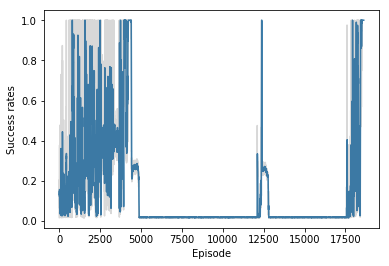

In [202]:
eps, arr = np.array(rates_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Success rates')

Text(0,0.5,'Success rates')

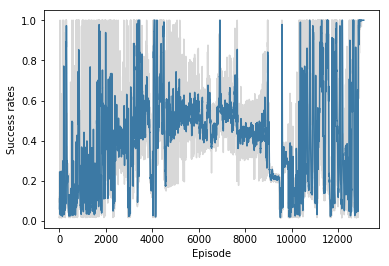

In [187]:
eps, arr = np.array(rates_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Success rates')

Text(0,0.5,'Success rates')

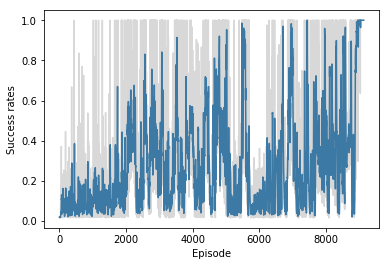

In [170]:
eps, arr = np.array(rates_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Success rates')

Text(0,0.5,'Total rewards')

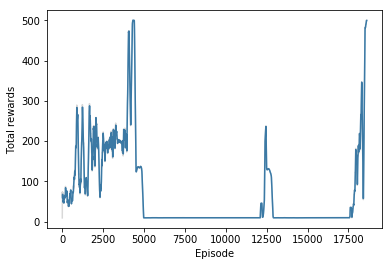

In [203]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

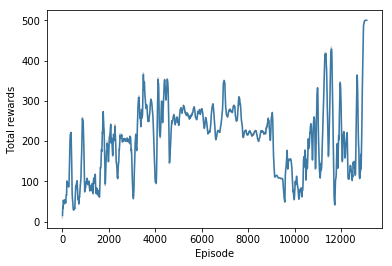

In [188]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

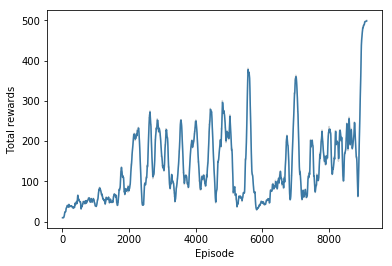

In [165]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

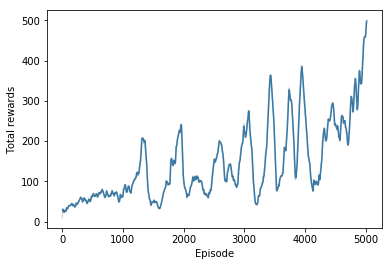

In [126]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

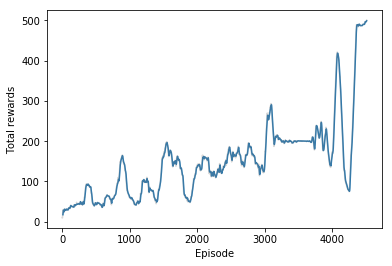

In [109]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

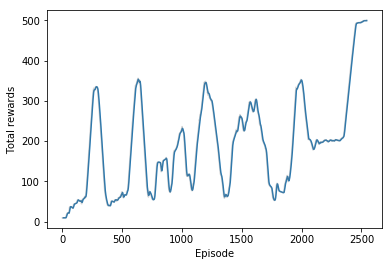

In [84]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

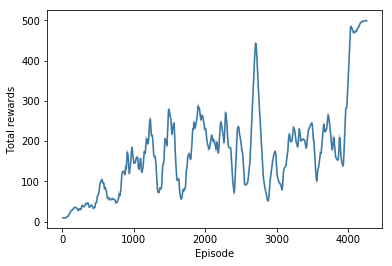

In [64]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

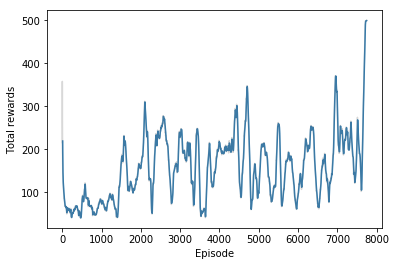

In [44]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

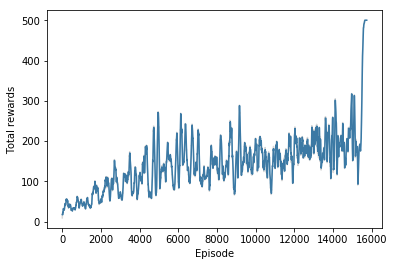

In [29]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

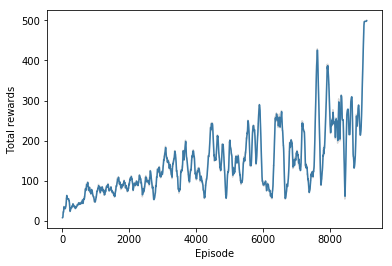

In [29]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

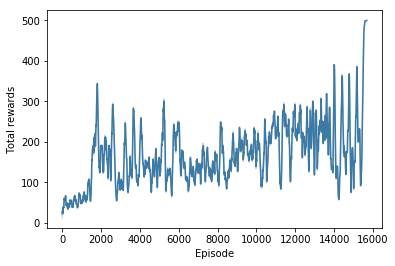

In [46]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

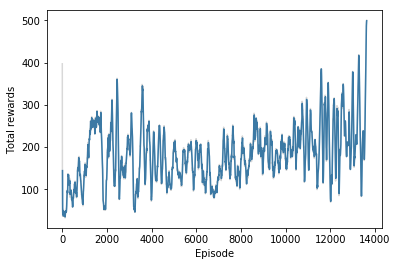

In [32]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

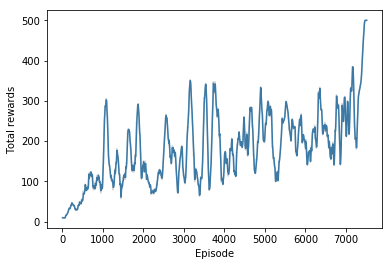

Text(0,0.5,'G losses')

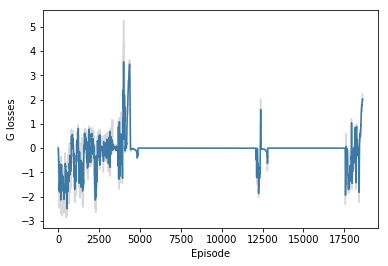

In [204]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

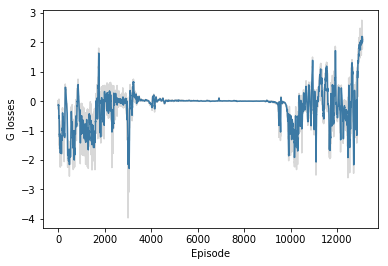

In [189]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

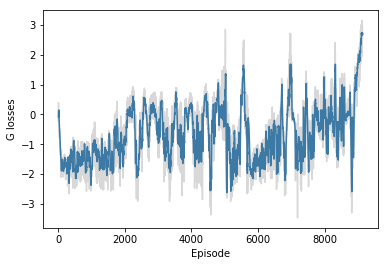

In [166]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

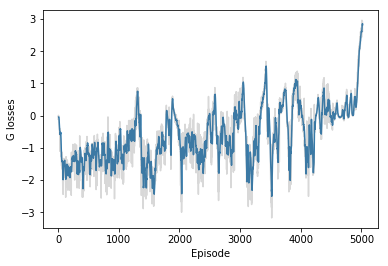

In [129]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

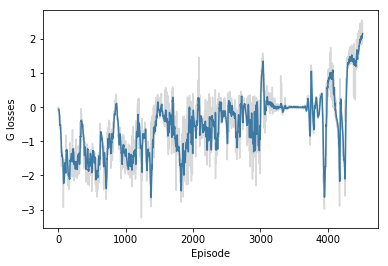

In [110]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

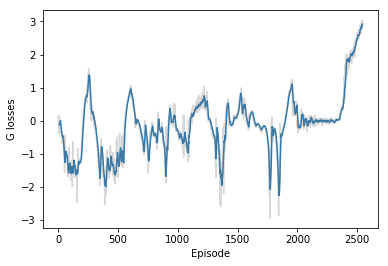

In [85]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

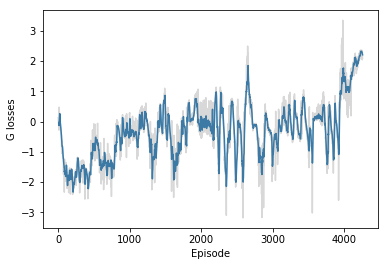

In [65]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

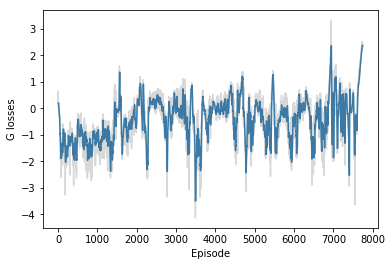

In [45]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

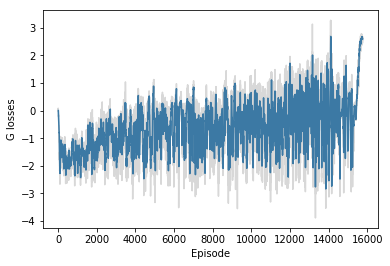

In [30]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

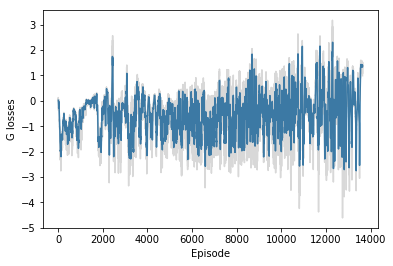

In [33]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

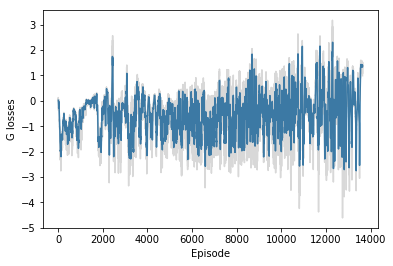

In [30]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

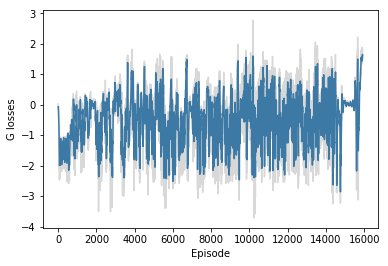
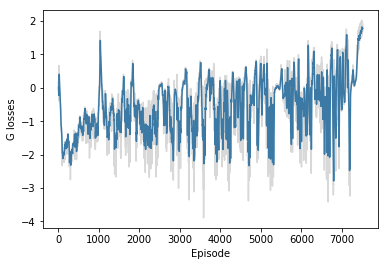

Text(0,0.5,'D losses')

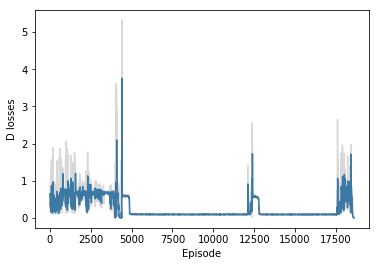

In [205]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

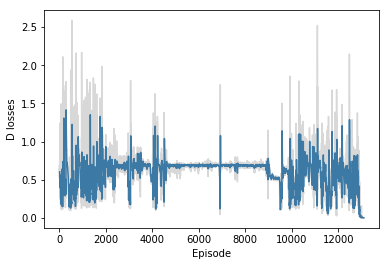

In [190]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

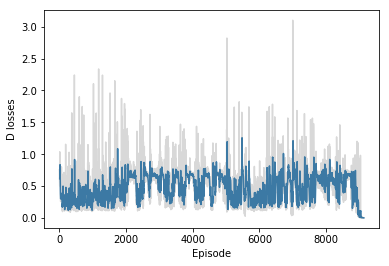

In [167]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

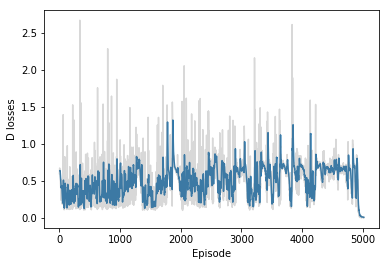

In [130]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

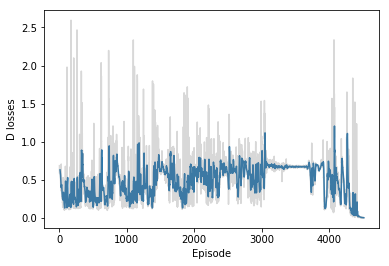

In [111]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

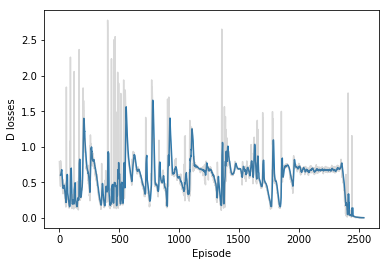

In [86]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

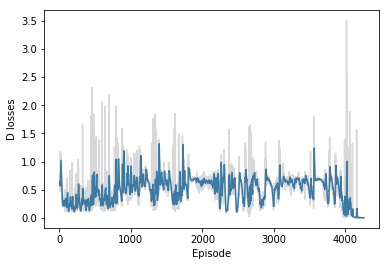

In [66]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

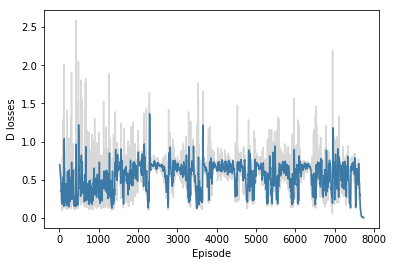

In [46]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

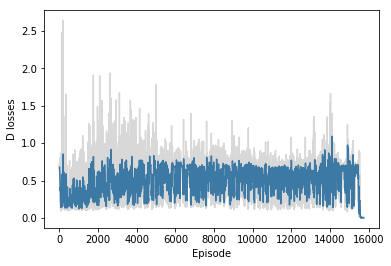

In [31]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

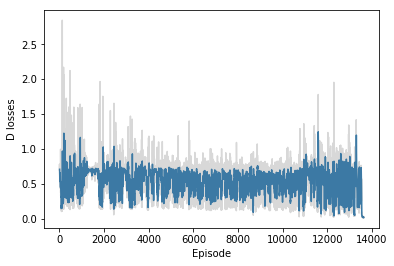

In [34]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

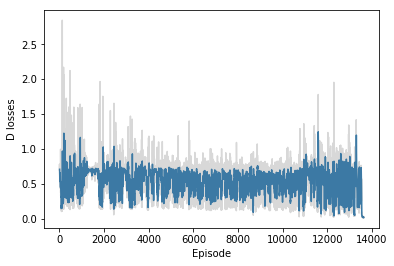

In [31]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

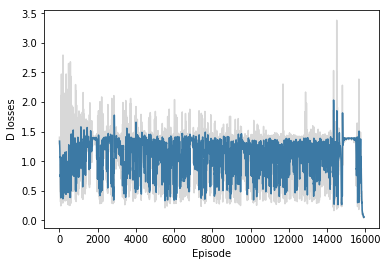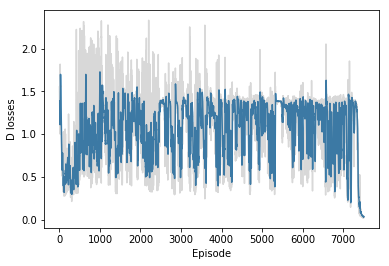

Text(0,0.5,'D losses R')

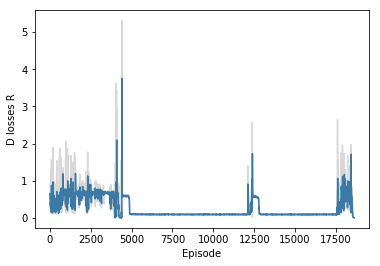

In [207]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

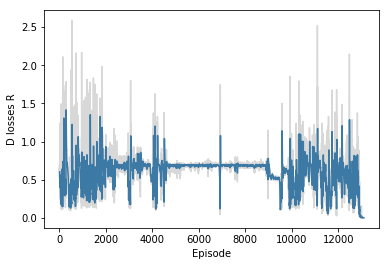

In [191]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

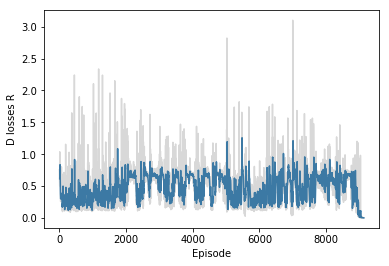

In [168]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

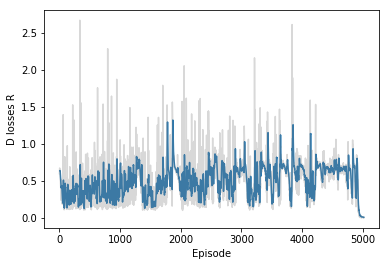

In [131]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

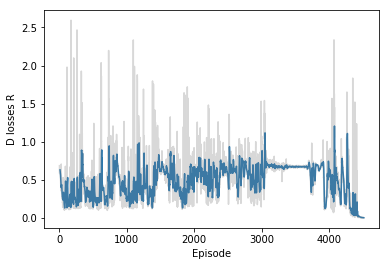

In [112]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

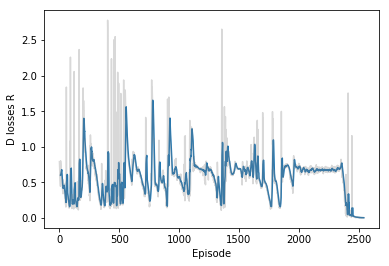

In [87]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

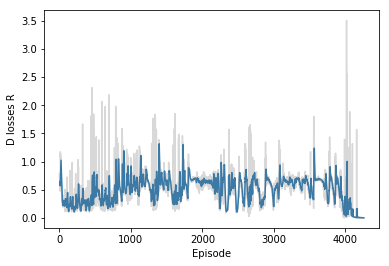

In [67]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

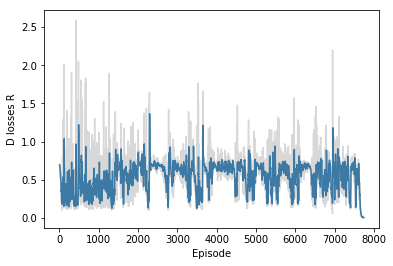

In [47]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

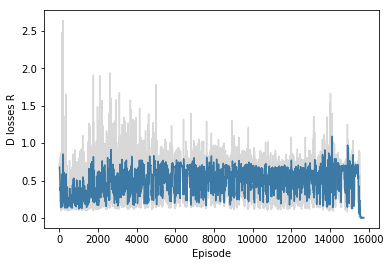

In [32]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

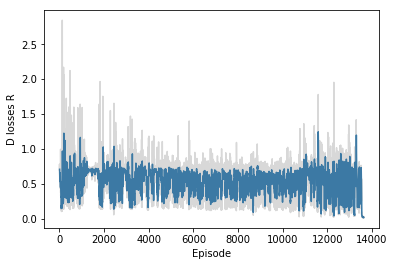

In [35]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

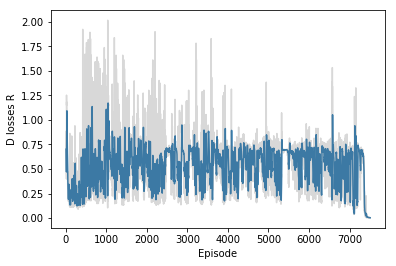

In [32]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses Q')

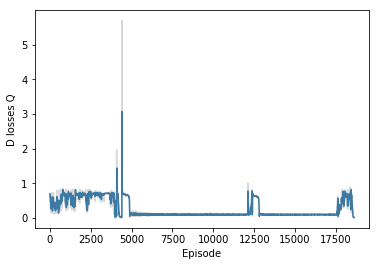

In [208]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

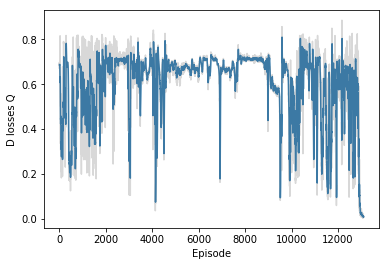

In [192]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

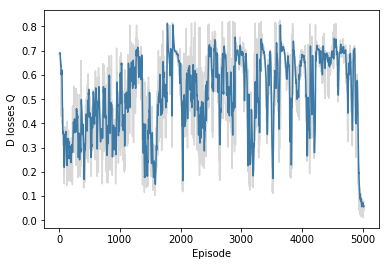

In [132]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

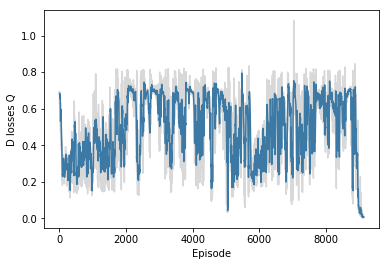

In [169]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

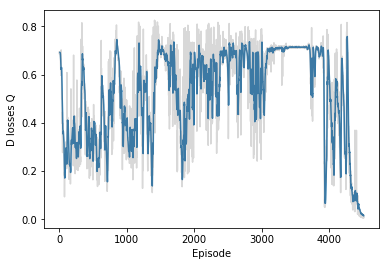

In [113]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

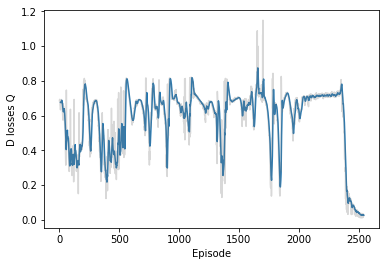

In [88]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

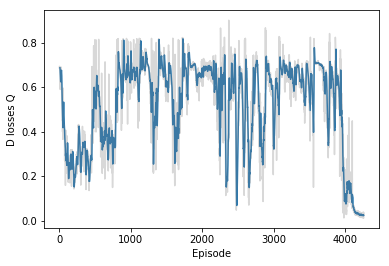

In [68]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

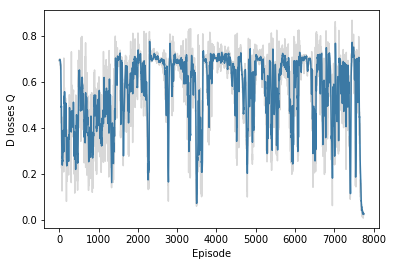

In [48]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

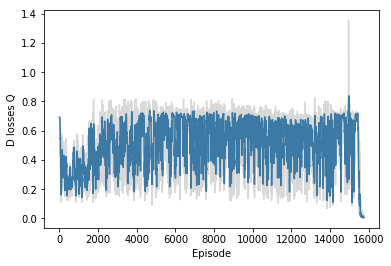

In [33]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

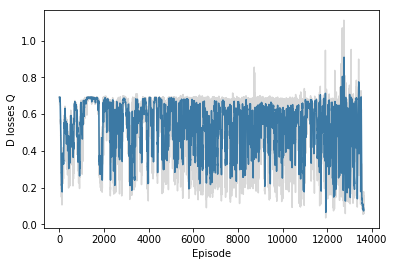

In [36]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

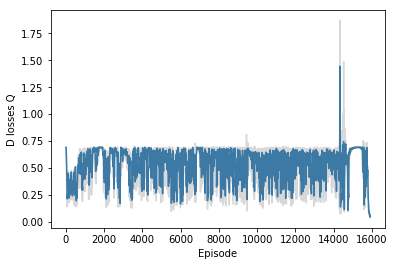

In [33]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

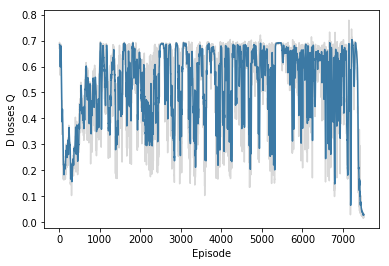

In [33]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

## Testing

Let's checkout how our trained agent plays the game.

In [34]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(100):
    #while True:
        state = env.reset()
        total_reward = 0

        # Steps/batches
        #for _ in range(111111111111111111):
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # Print and break condition
        print('total_reward: {}'.format(total_reward))
        # if total_reward == 500:
        #     break
                
# Closing the env
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.